# Tanzania Tourism Prediction Challenge - Proposed Solution

This notebook is a proposed solution for the final project of the course, based on the Tanzania Tourism Prediction Challenge.

## Dataset and project aim

The dataset describes $6476$ rows of up-to-date information on tourist expenditure collected by the _National Bureau of Statistics_ (NBS) in Tanzania. The dataset was collected to gain a better understanding of the status of the tourism sector and provide an instrument that will enable sector growth.

The objective of this project is to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.
The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania

Below is the proposed solution for this project.

In [1]:
# Importing the necessary libraries
from typing import Dict, TypeVar, Union
import warnings

import pandas as pd
import numpy as np
import joblib

from itertools import cycle
import pycountry
import pycountry_convert as pc

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
                OneHotEncoder,
                OrdinalEncoder,
                LabelEncoder,
                LabelBinarizer,
                RobustScaler,
                FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

import xgboost as xgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

SeriesStr = TypeVar("pandas.core.series.Series(str)")
Pipe = TypeVar("sklearn.pipeline.Pipeline")

## Load data

As usual, we import data. 
We start by building dataframes to perform the Exploratory Data Analysis.

In [2]:
# Loading datasets
data_path = "../../data/"
train_df=pd.read_csv(data_path + "Train.csv")
test_df=pd.read_csv(data_path + "Test.csv")
sub_df=pd.read_csv(data_path + "SampleSubmission.csv")
descp=pd.read_csv(data_path + "VariableDefinitions.csv")

## Exploratory Data Analysis

By the tools we studied, one can perform some data analysis. 
This operation has a twofold goal:

1. Better understaing of the data available.
2. Extracting useful information and converting in a suitable format.

### Numerical analysis of the dataframes

First of all, we are interested in countings, that is we want to count the number of rows, the number of features available, how many non-valid values we have, etc.

Let's start by _dataframe shapes_.

In [3]:
print(train_df.shape)
print(test_df.shape)

(18506, 21)
(6169, 20)


Now, let's check for _null values_.

In [4]:
print(train_df.isnull().sum())

Tour_ID                     0
country                     0
age_group                   0
travel_with              1075
total_female                2
total_male                  6
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category               0
dtype: int64


In [5]:
# same for test dataset
print(test_df.isnull().sum())

Tour_ID                    0
country                    0
age_group                  0
travel_with              361
total_female               2
total_male                 1
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
first_trip_tz              0
dtype: int64


We need to decide how to handle such cases with missing pieces of information.

Let's explore a bit further.

In [6]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [7]:
train_df.describe(include=object)

Tour_ID                   country age_group travel_with  \
count             18506                     18506     18506       17431   
unique            18506                       131         5           5   
top     tour_id1hffseyw  UNITED STATES OF AMERICA     25-44       Alone   
freq                  1                      2846      9047        7590   

                     purpose    main_activity                  info_source  \
count                  18506            18506                        18506   
unique                     8               10                            8   
top     Leisure and Holidays  Widlife Tourism  Travel agent, tour operator   
freq                   11755             5988                         8005   

       tour_arrangement package_transport_int package_accomodation  \
count             18506                 18506                18506   
unique                2                     2                    2   
top        Package Tour                    No                   No   
freq               9295                 12238                 9541   

       package_food package_transport_tz package_sightseeing  \
count         18506                18506               18506   
unique            2                    2                   2   
top              No                   No                  No   
freq          10143                10873               12786   

       package_guided_tour package_insurance first_trip_tz cost_category  
count                18506             18506         18506         18506  
unique                   2                 2             2             6  
top                     No                No           Yes   Normal Cost  
freq                 12447             15809         12737          5471

In [8]:
train_df.describe()

total_female    total_male  night_mainland  night_zanzibar
count  18504.000000  18500.000000    18506.000000    18506.000000
mean       0.936230      0.998757        9.141576        2.493516
std        1.215582      1.173177       14.127449        5.275156
min        0.000000      0.000000        0.000000        0.000000
25%        0.000000      1.000000        3.000000        0.000000
50%        1.000000      1.000000        6.000000        0.000000
75%        1.000000      1.000000       11.000000        4.000000
max       49.000000     58.000000      365.000000      240.000000

### Split in train and dev_test set

We do not have access to test labels, so, we need to create a `development_test` set in order to have something to measure our performances on and to build a metric to make comparisons.

In [9]:
X, y = train_df.drop("cost_category", axis=1).values, train_df.cost_category.values
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

print("Train set shape: ", X_train.shape)
print("Dev-test set shape: ", X_devtest.shape)

print("Train labels shape: ", y_train.shape)
print("Dev-test labels shape: ", y_devtest.shape)

Train set shape:  (11103, 20)
Dev-test set shape:  (7403, 20)
Train labels shape:  (11103,)
Dev-test labels shape:  (7403,)


### Imputing missing values

Since we want to build a pipeline, we need to use `sklearn` objects. 
Even if it seems a great limitation at this stage, this will simplify our training and predicting procedures afterwards.

#### Imputing strategy

One thing one can do is to look at the missing values rows and adopt a specific strategy for the imputation. 
For example, if the `travel_with` information is missing, one can look at the `total_male` and `total_female` fields and impute such that this is consistent.

This is certainly a good thing to do.
However, we want to keep the preprocessing as simple as possible and eventually go back after measuring the model performances.

Hence, also considering the number of missing values, we simply drop the rows containing null values.

In [10]:
train_df = train_df.dropna()
X, y = train_df.drop("cost_category", axis=1).values, train_df.cost_category.values
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.33, random_state=42)

print("Train set shape: ", X_train.shape)
print("Dev-test set shape: ", X_devtest.shape)

print("Train labels shape: ", y_train.shape)
print("Dev-test labels shape: ", y_devtest.shape)

print("Total number of examples ", train_df.shape[0])

Train set shape:  (11674, 20)
Dev-test set shape:  (5750, 20)
Train labels shape:  (11674,)
Dev-test labels shape:  (5750,)
Total number of examples  17424


As one can see, the number of rows has decreased, but not dramatically. On the other hand, no missing value is present anymore.

In [11]:
assert ~pd.isnull(X).any(), "You have null values in your array."

To conclude, let's print the head of our dataset to check that everything is ok.

In [12]:
train_df.head()

Tour_ID                   country age_group  \
0  tour_id1hffseyw                     ITALY     45-64   
1  tour_idnacd7zag            UNITED KINGDOM     25-44   
2  tour_id62vz7e71  UNITED STATES OF AMERICA       65+   
3  tour_idrc76tzix                    RWANDA     25-44   
4  tour_idn723m0n9  UNITED STATES OF AMERICA     45-64   

                travel_with  total_female  total_male  \
0             With Children           0.0         2.0   
1               With Spouse           1.0         1.0   
2               With Spouse           1.0         1.0   
3  With Spouse and Children           3.0         1.0   
4                     Alone           0.0         1.0   

                          purpose     main_activity  \
0  Visiting Friends and Relatives     Beach Tourism   
1            Leisure and Holidays  Wildlife Tourism   
2            Leisure and Holidays   Widlife Tourism   
3            Leisure and Holidays     Beach Tourism   
4            Leisure and Holidays   Widlife Tourism   

                   info_source tour_arrangement  ... package_accomodation  \
0           Friends, relatives     Package Tour  ...                  Yes   
1  Travel agent, tour operator     Package Tour  ...                  Yes   
2  Travel agent, tour operator     Package Tour  ...                  Yes   
3               Radio, TV, Web      Independent  ...                   No   
4  Travel agent, tour operator     Package Tour  ...                  Yes   

  package_food package_transport_tz package_sightseeing package_guided_tour  \
0          Yes                  Yes                  No                  No   
1          Yes                  Yes                  No                  No   
2          Yes                  Yes                 Yes                 Yes   
3           No                   No                  No                  No   
4          Yes                  Yes                  No                 Yes   

  package_insurance night_mainland  night_zanzibar  first_trip_tz  \
0                No              0               7            Yes   
1                No              0               7            Yes   
2                No              6               6            Yes   
3                No              3               0             No   
4               Yes              7               0            Yes   

  cost_category  
0     High Cost  
1     High Cost  
2   Higher Cost  
3    Lower Cost  
4   Higher Cost  

[5 rows x 21 columns]

### Class balance

Let's analyse the number of elements we have in each classes.

We can do that in several ways, here we choose a simple histogram.


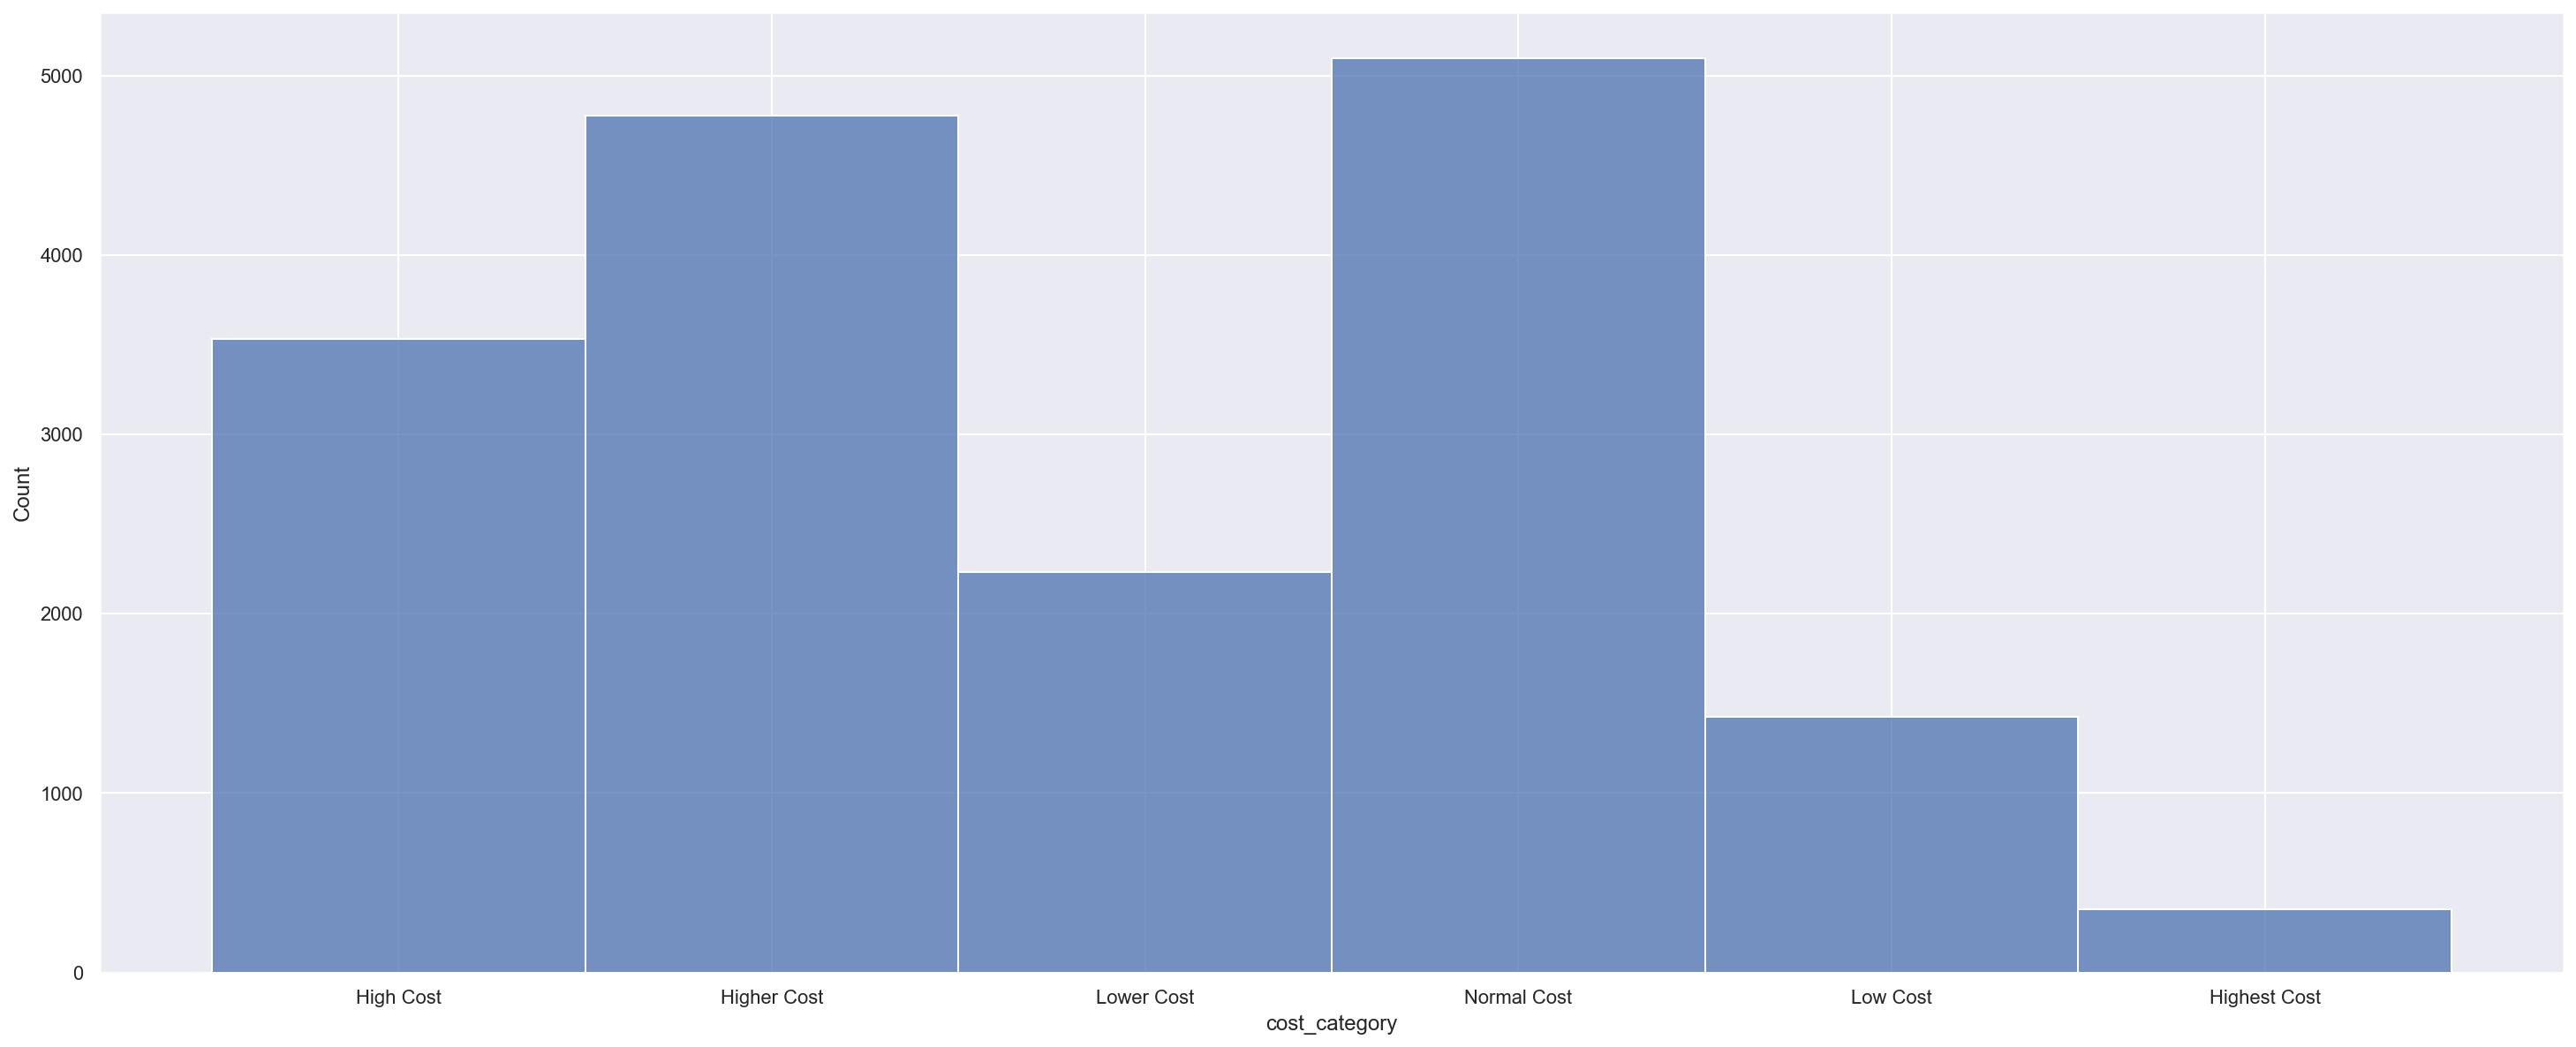

In [13]:
sns.histplot(train_df, x="cost_category");

As one can notice, the "Highest Cost" class is poorly represented.

In particular, one can print the percentage weight of each class with respect to the total number of examples.

In [14]:
for category in train_df.cost_category.unique():
    percentage = (len(train_df[train_df.cost_category == category])/len(train_df))*100
    print(f"Percentage of \033[1m{category}\033[0m over the total number of elements: {percentage:.2f}")

Percentage of High Cost over the total number of elements: 20.29
Percentage of Higher Cost over the total number of elements: 27.42
Percentage of Lower Cost over the total number of elements: 12.82
Percentage of Normal Cost over the total number of elements: 29.26
Percentage of Low Cost over the total number of elements: 8.20
Percentage of Highest Cost over the total number of elements: 2.01


This will be the main issue that affects our model, we will choose how to handle this later on.

### Categorical and numerical variables

We need to identify categorical variables, in particular the binary ones, as these will be treated with two different encodings.

It is noteworthy to point out that in this phase we are only "exploring" data, hence we do not transform anything. This will be done in the later section on _Feature Engineering_.

In [15]:
numeric_variables = [col for col in train_df.select_dtypes(include=['int', 'float'])]
print(f"Number of numerical features: {len(numeric_variables)}\n")

numeric_variables

Number of numerical features: 4



['total_female', 'total_male', 'night_mainland', 'night_zanzibar']

In [16]:
categorical_variables = [col for col in train_df.drop("cost_category", axis=1).select_dtypes(include=['object'])]
print(f"Number of categorical features: {len(categorical_variables)}\n")

categorical_variables.pop(0) # We remove Tour_ID as it is not a proper feature.
categorical_variables

Number of categorical features: 16



['country',
 'age_group',
 'travel_with',
 'purpose',
 'main_activity',
 'info_source',
 'tour_arrangement',
 'package_transport_int',
 'package_accomodation',
 'package_food',
 'package_transport_tz',
 'package_sightseeing',
 'package_guided_tour',
 'package_insurance',
 'first_trip_tz']

Between categorical variables, let's distinguish between binary and non-binary.

In [17]:
binary_cols = []
non_binary_cols = []

for col in categorical_variables:
    if len(train_df[col].unique()) == 2:
        binary_cols.append(col)
    else:
        non_binary_cols.append(col)

print(f"Number of binary features: {len(binary_cols)}")
print(f"Number of non binary features: {len(non_binary_cols)}\n")

print(binary_cols)
print(non_binary_cols)

Number of binary features: 9
Number of non binary features: 6

['tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'first_trip_tz']
['country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source']


#### Correlations

Let's study correlation between variables and specially between features and target.

First of all we can do a pairplot for __numerical variables__.

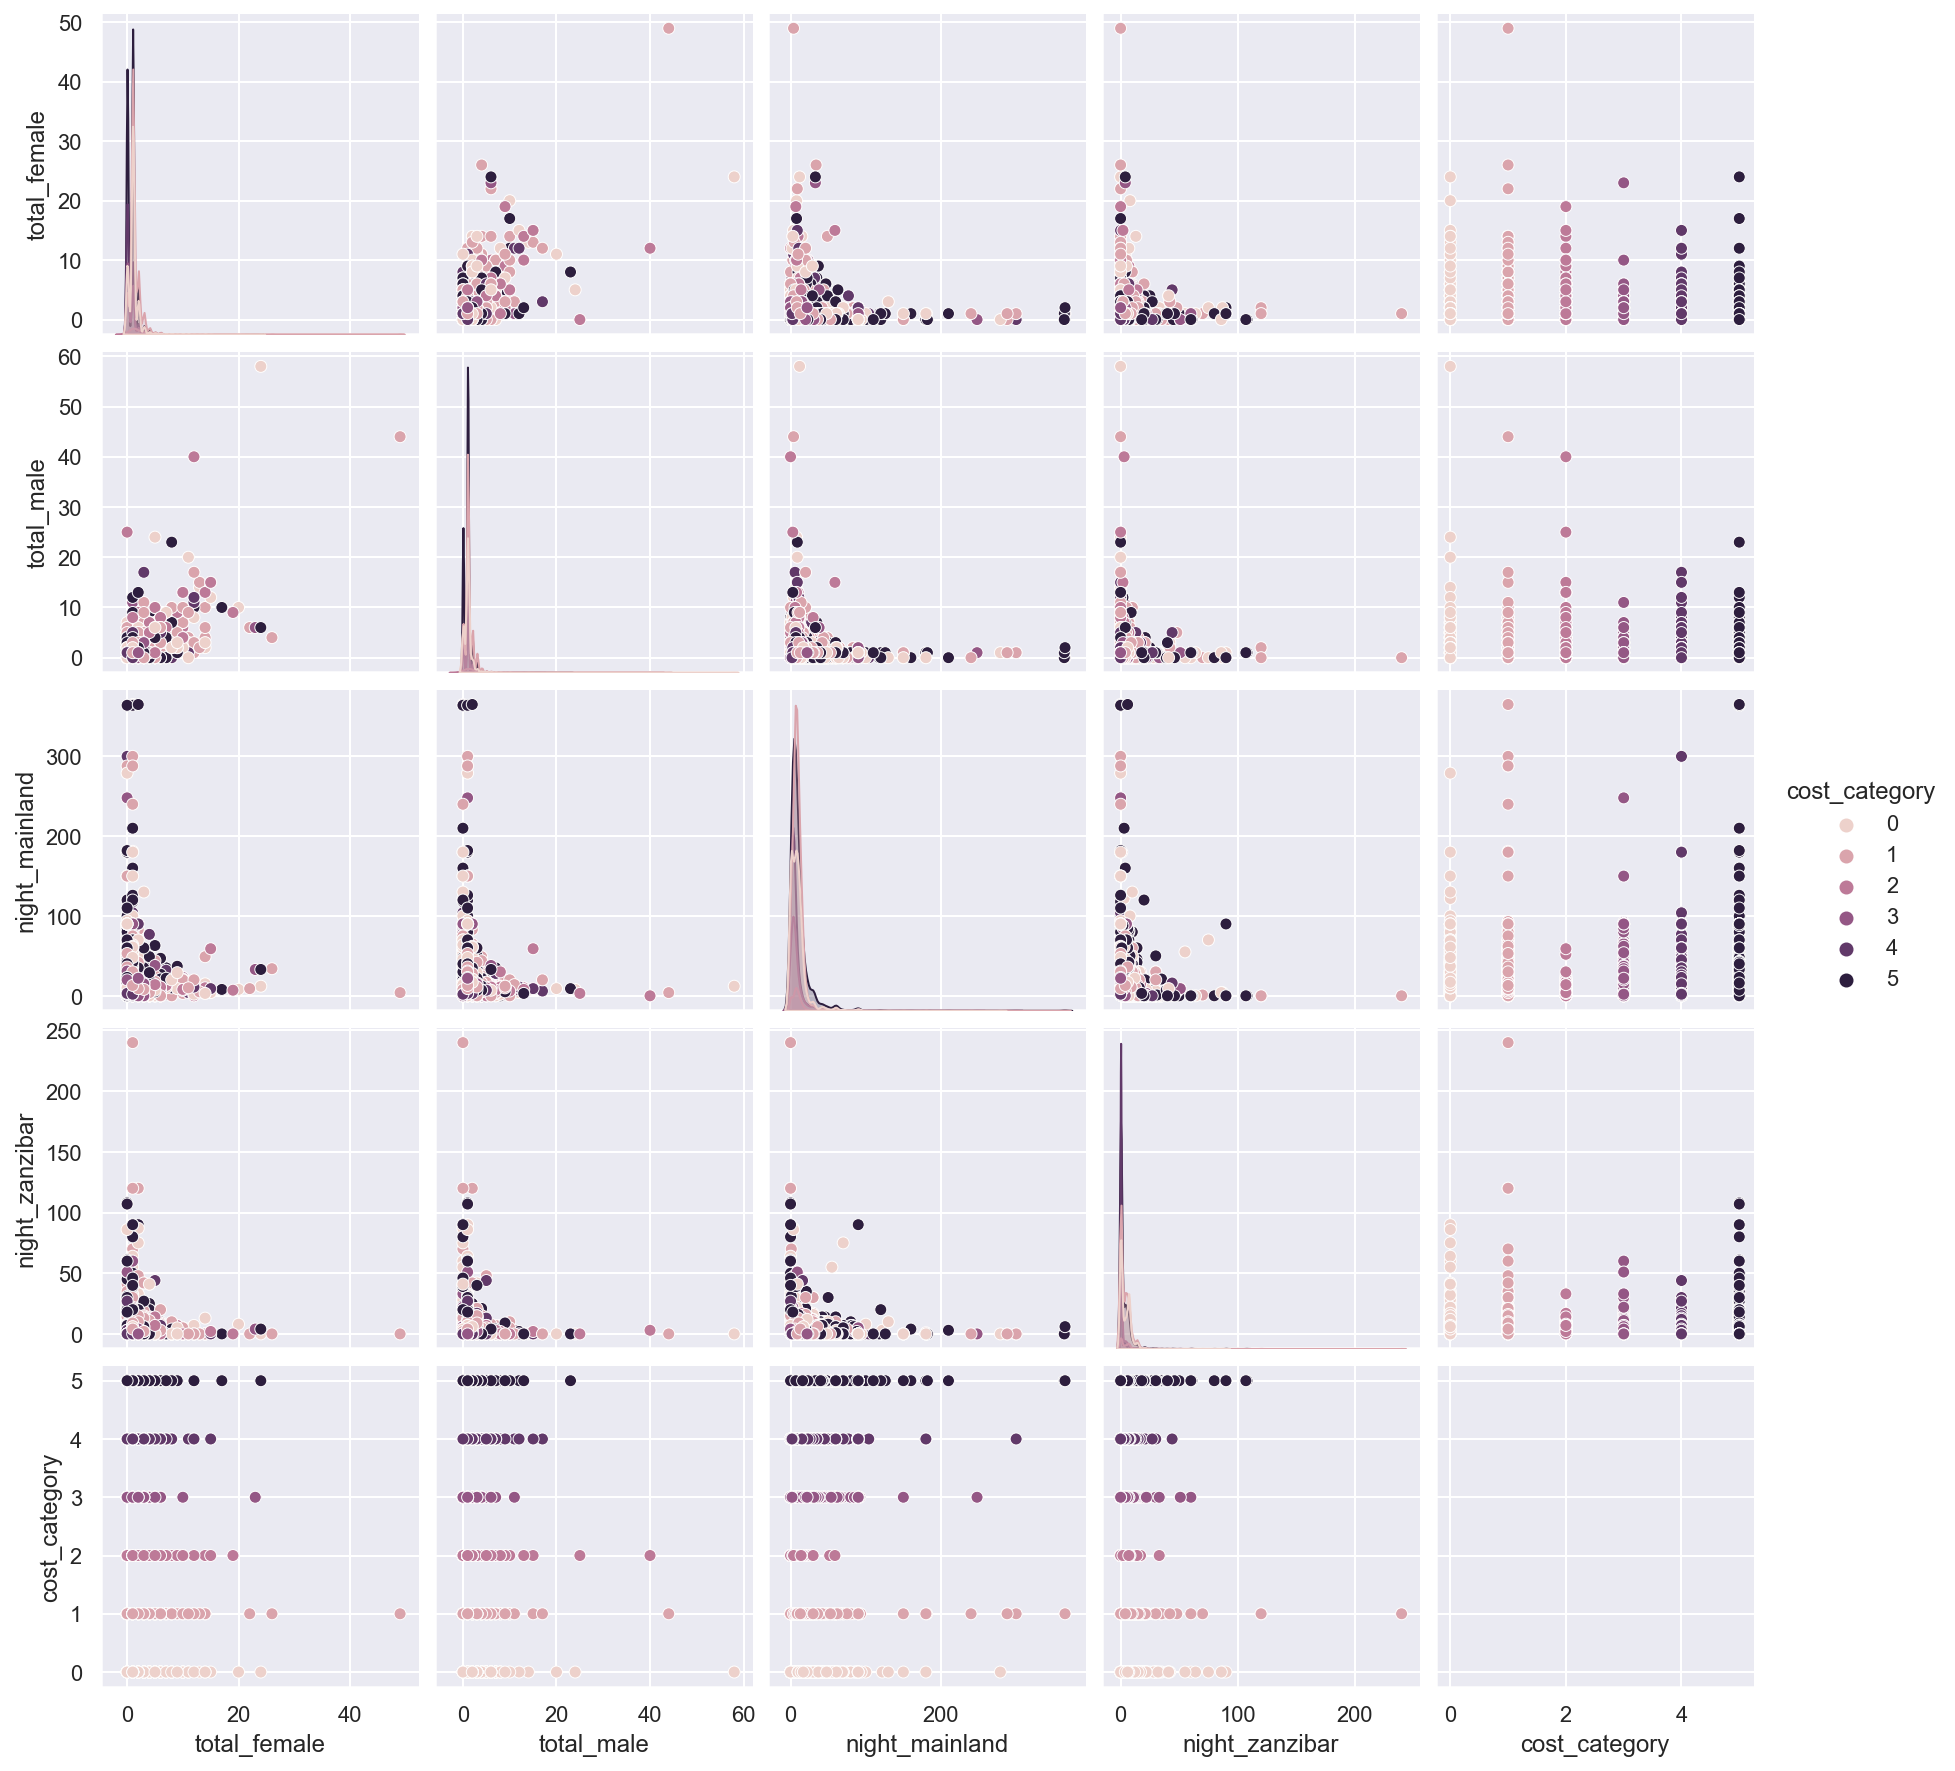

In [18]:
df = train_df.copy()

df["cost_category"] = LabelEncoder().fit_transform(y)

sns.pairplot(df, vars=numeric_variables + ["cost_category"], hue="cost_category");

As one can see the number of nights one spends in mainland is quite predictive.
We will come back on this later, let's now study categorical variable correlations.

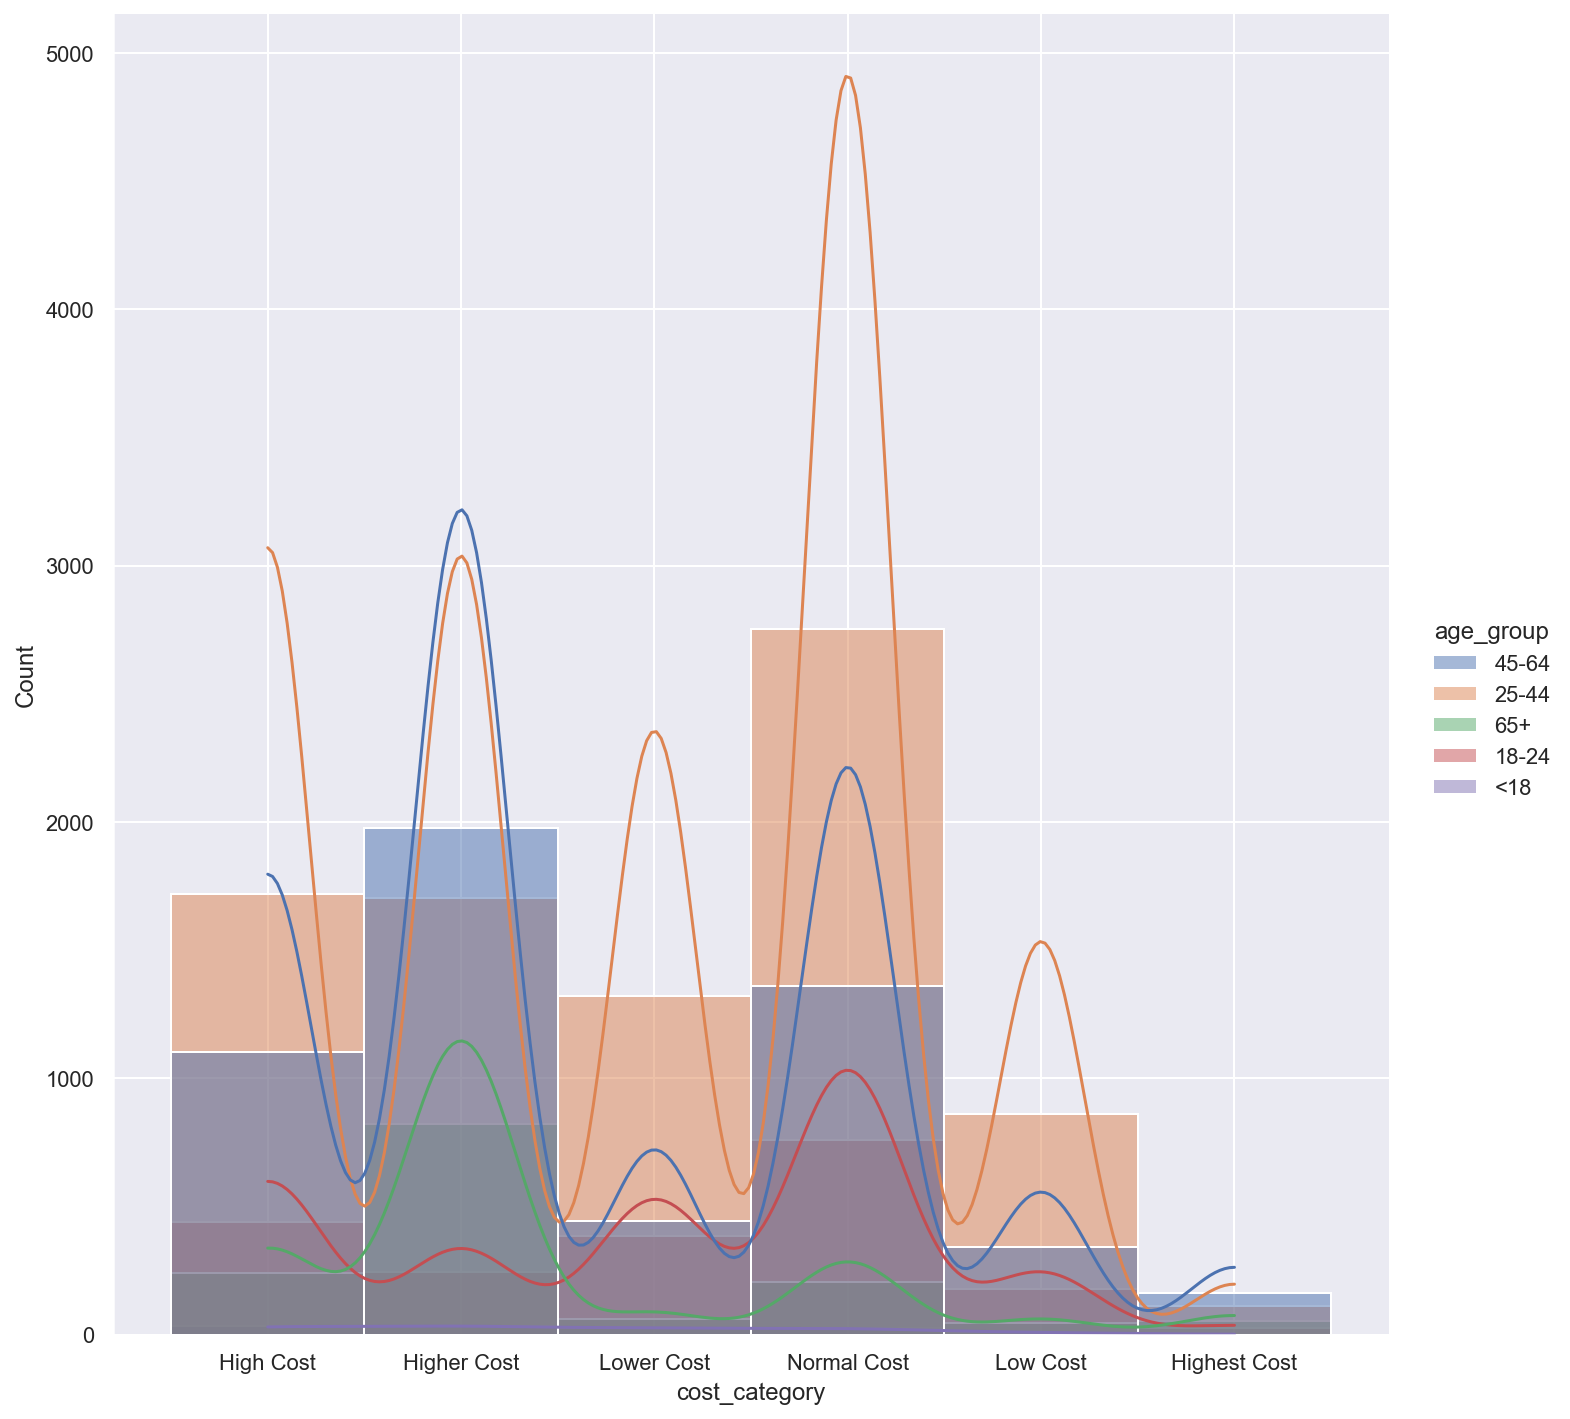

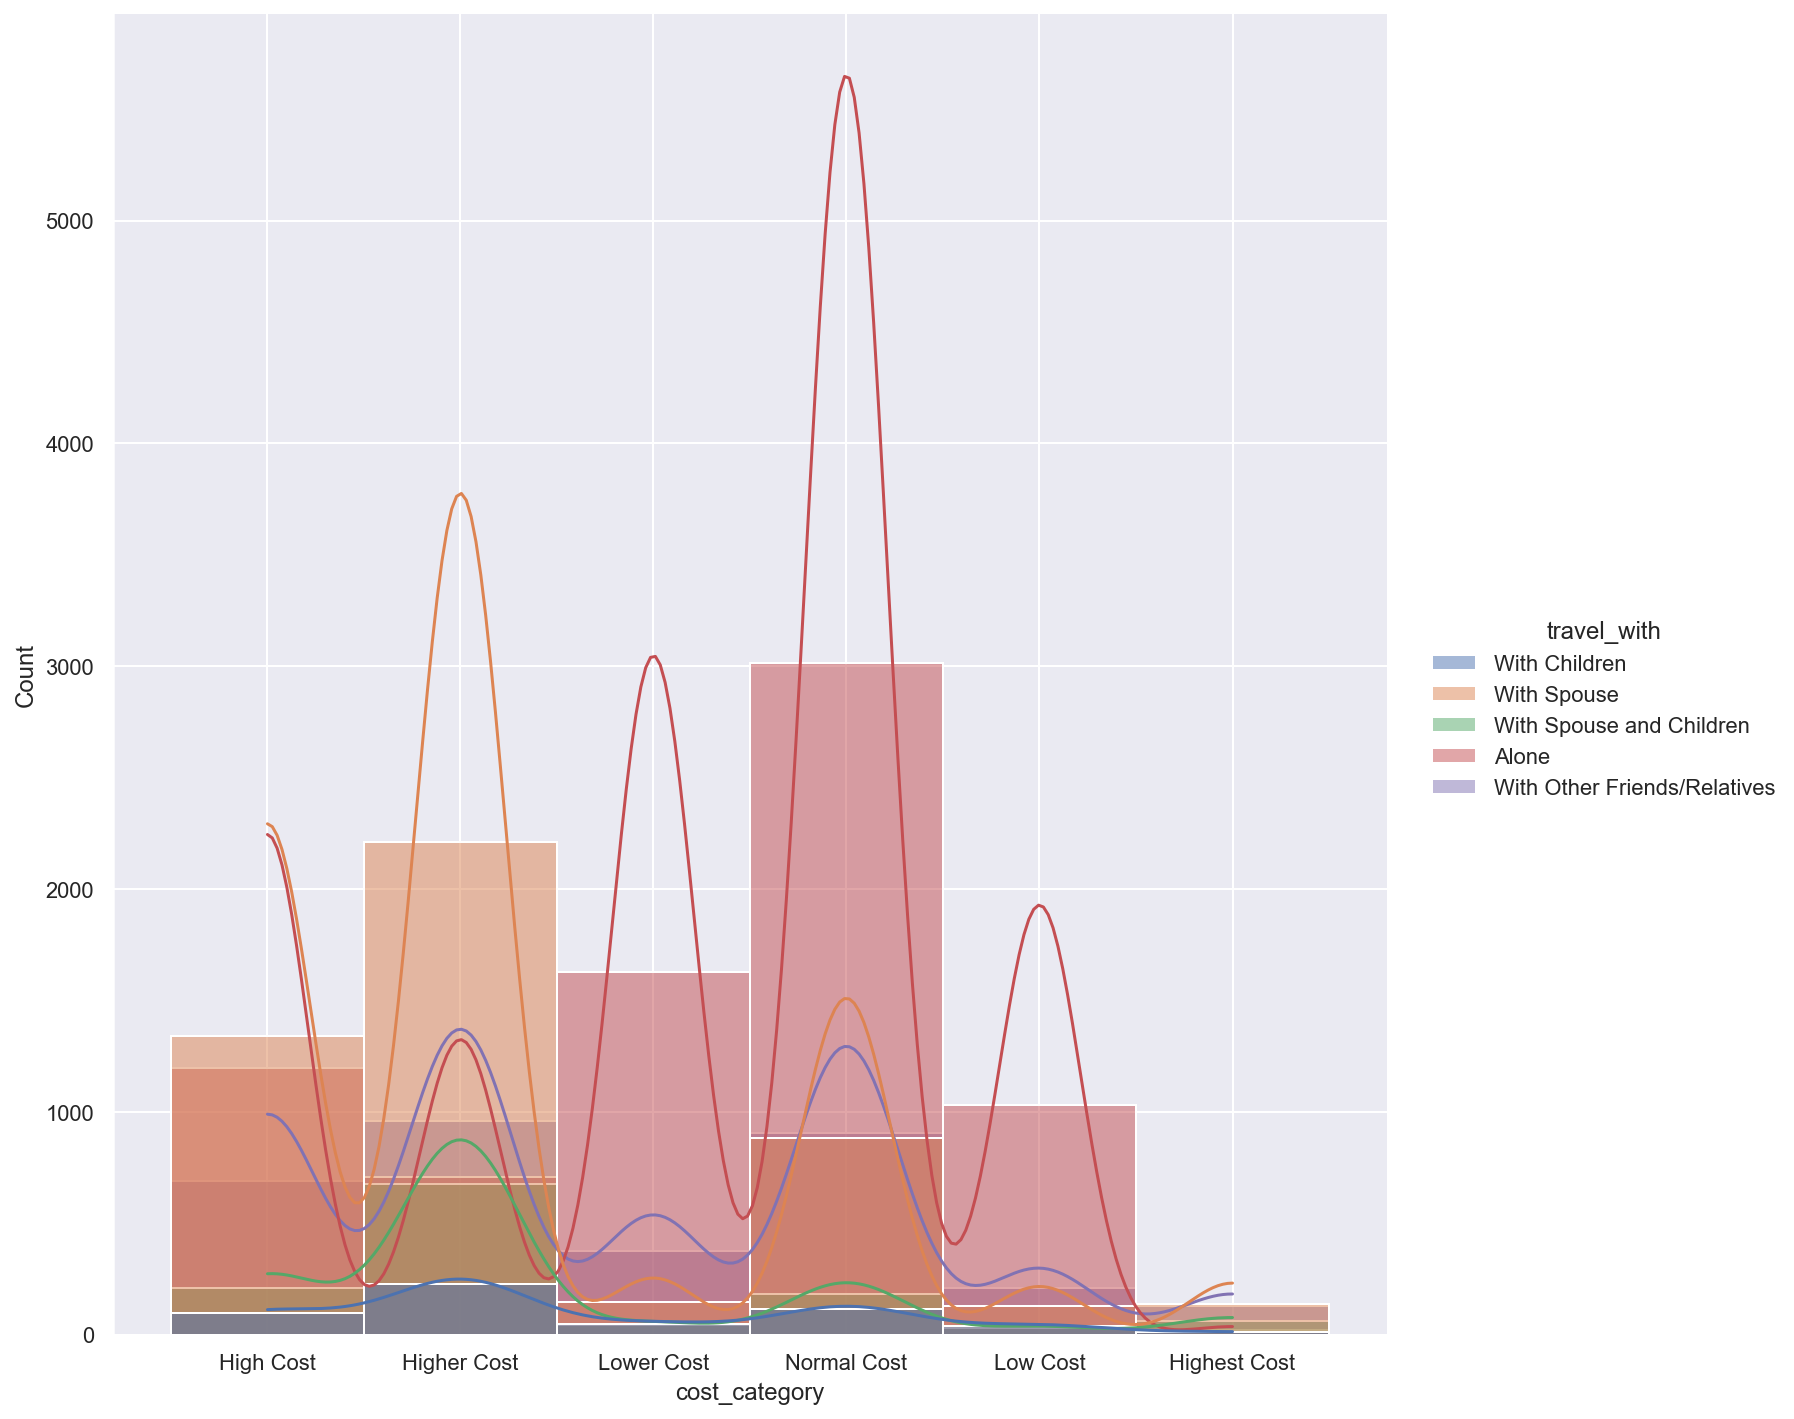

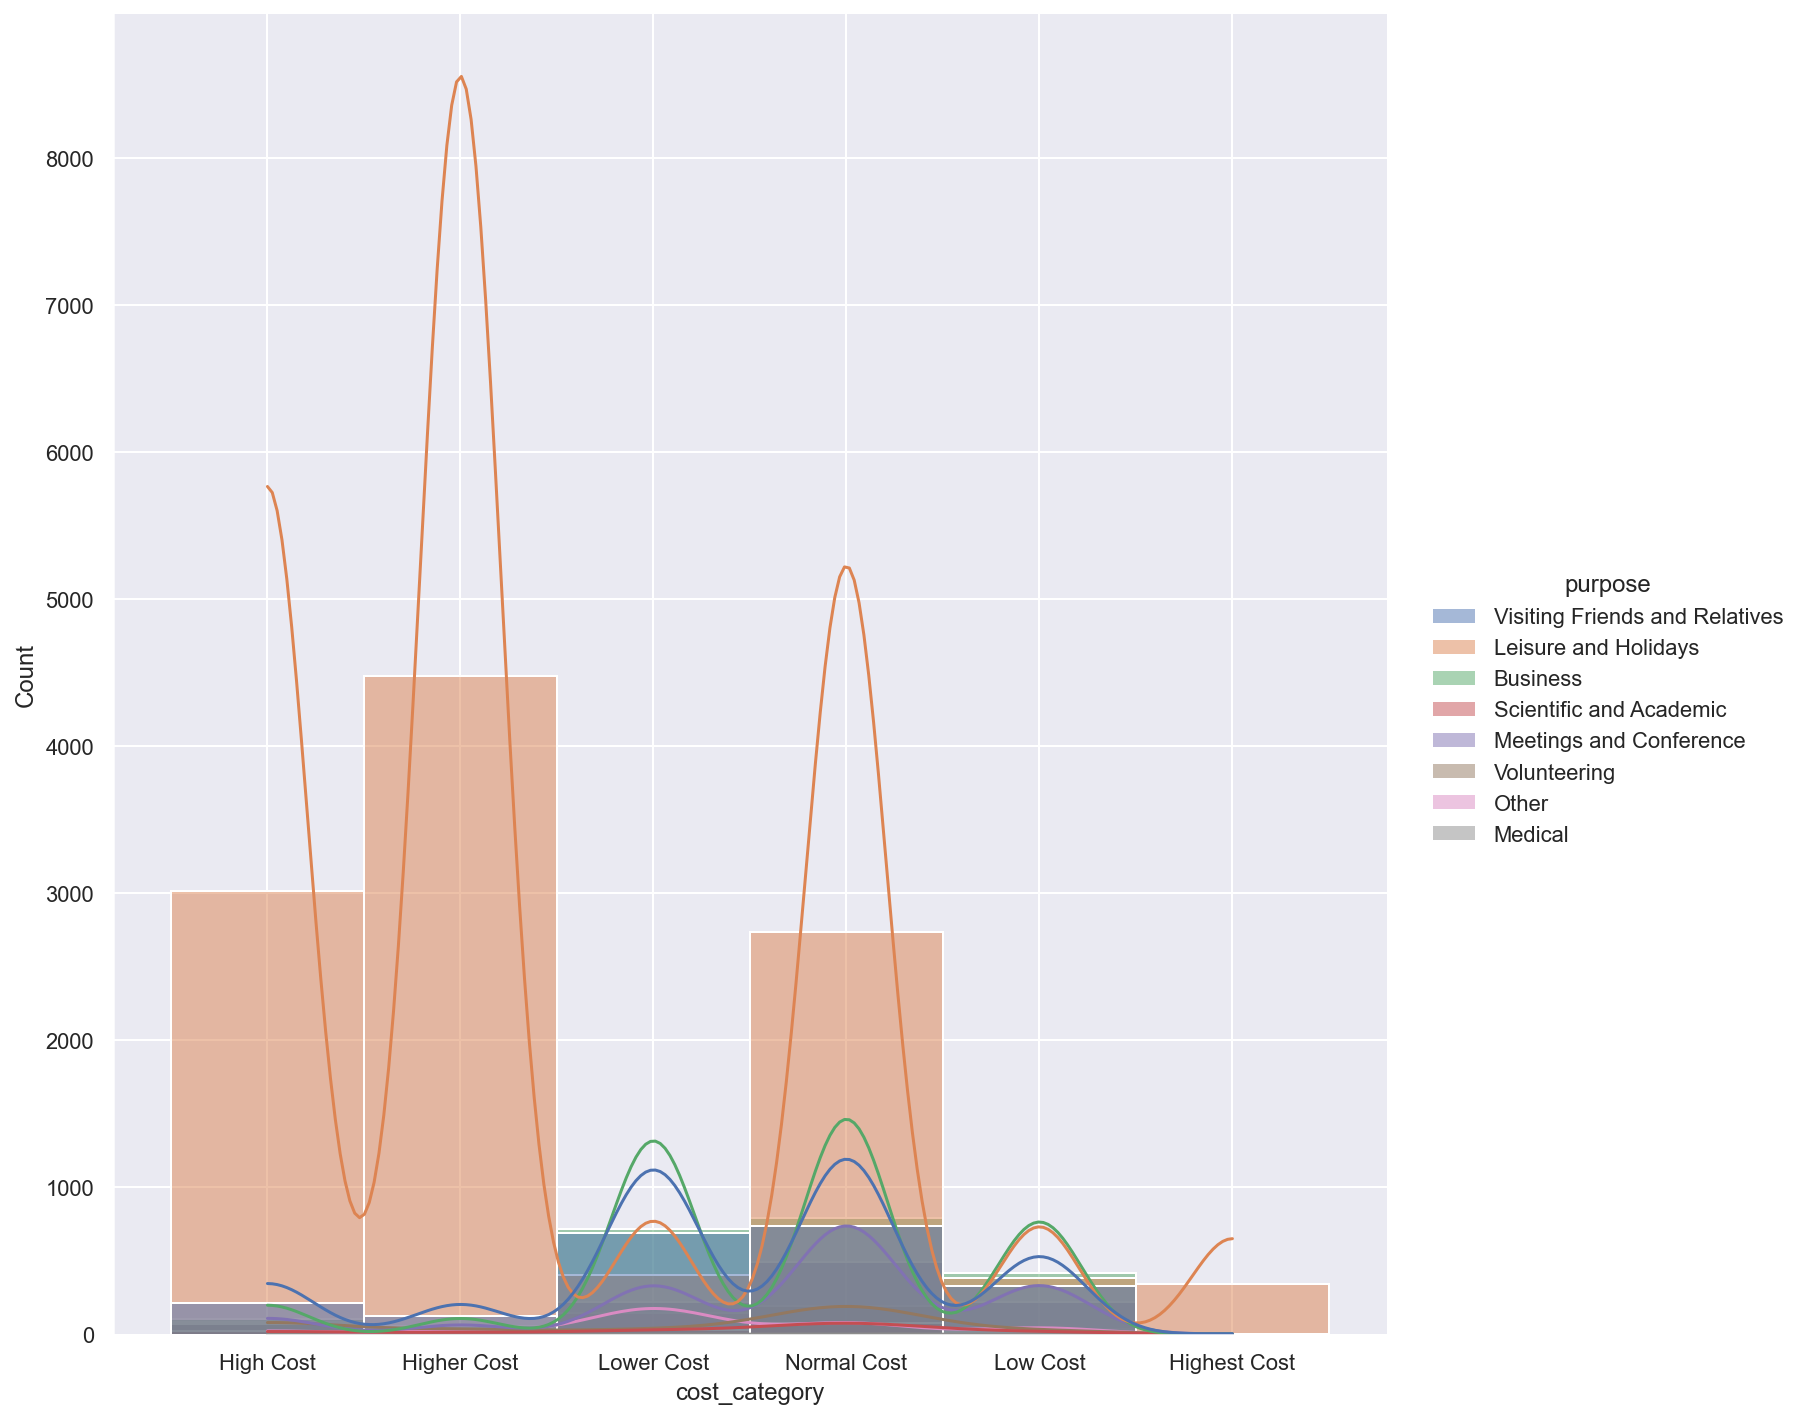

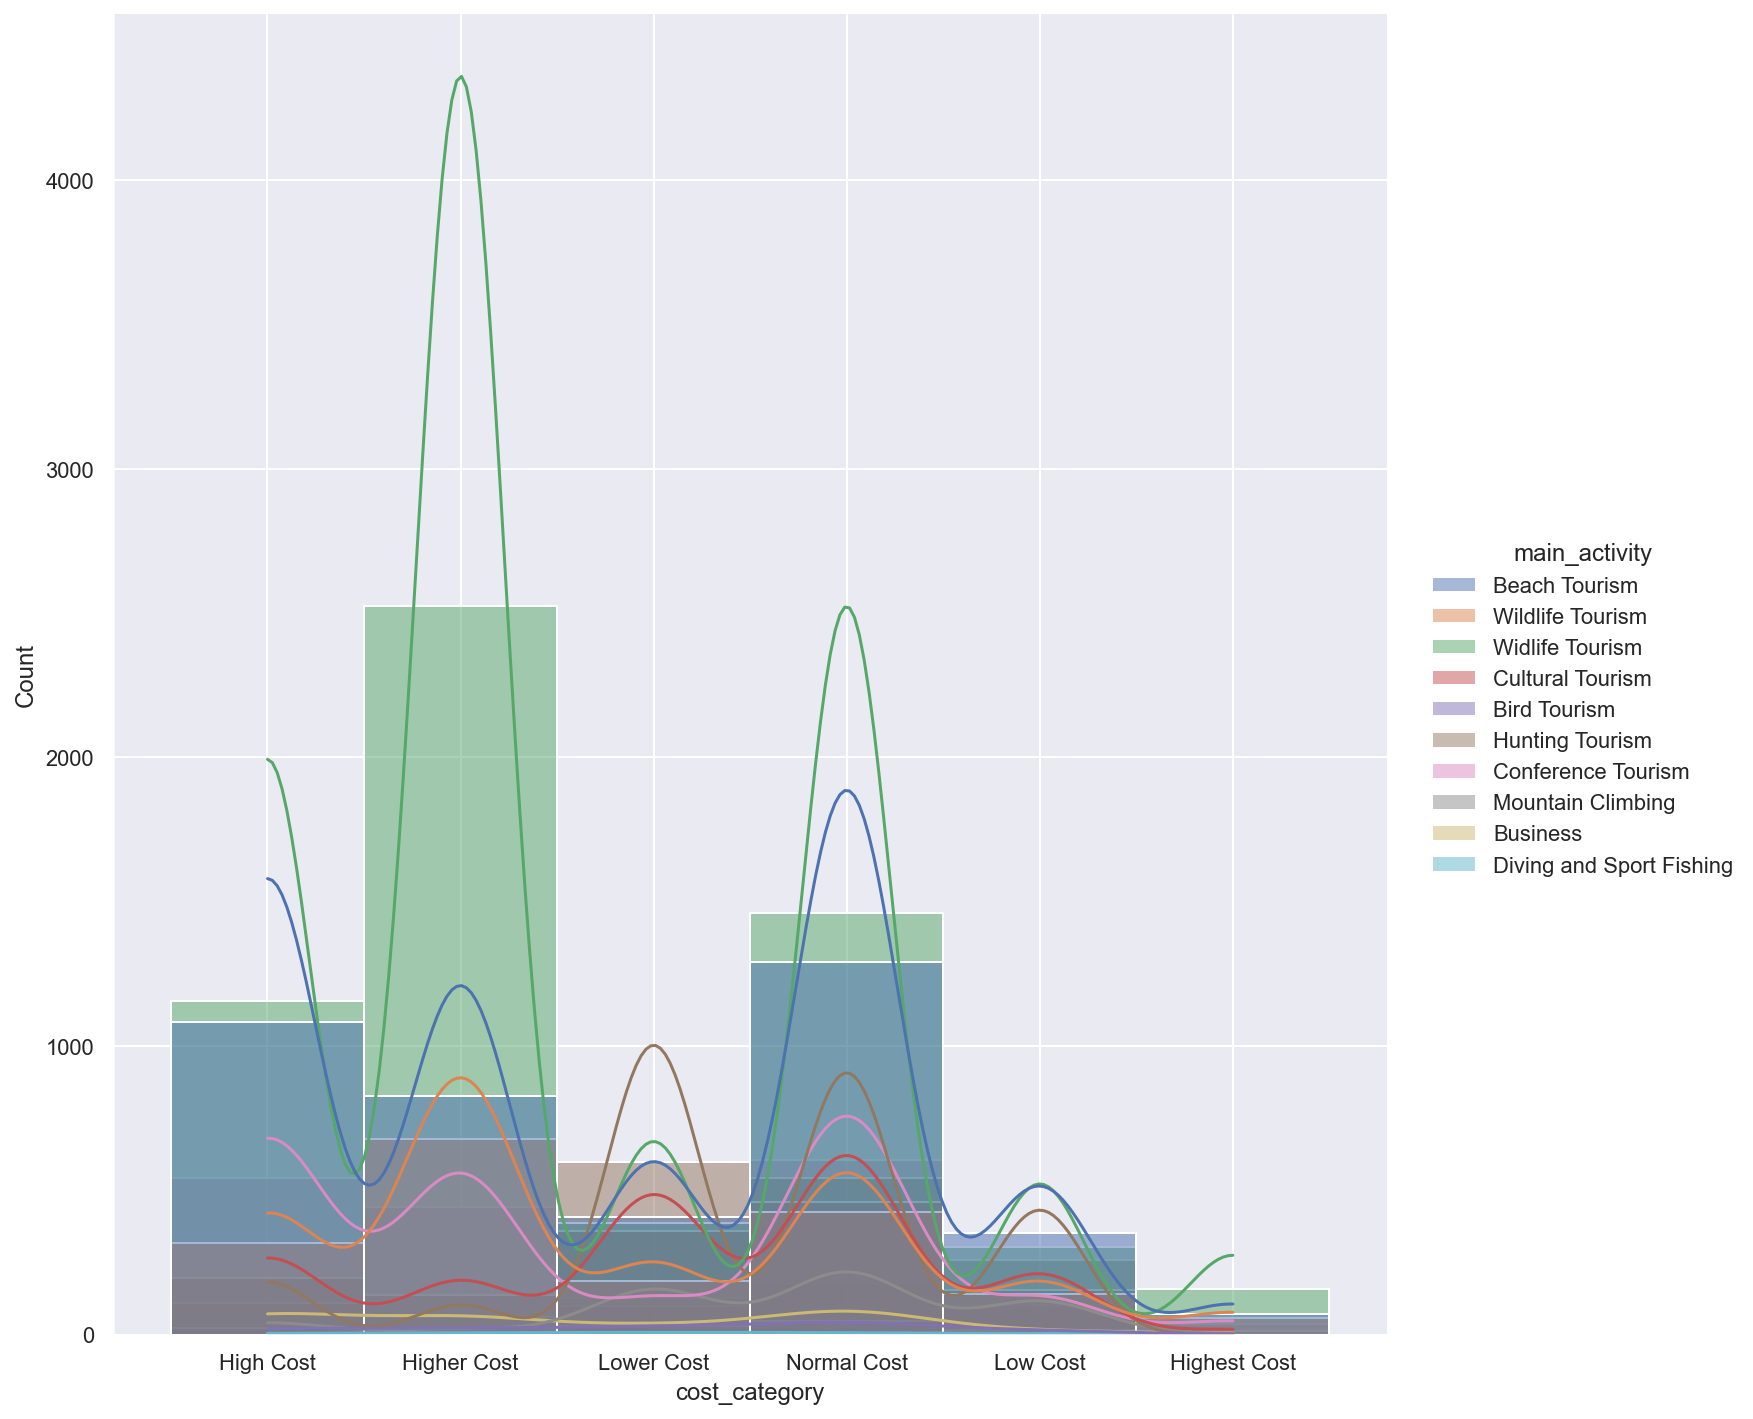

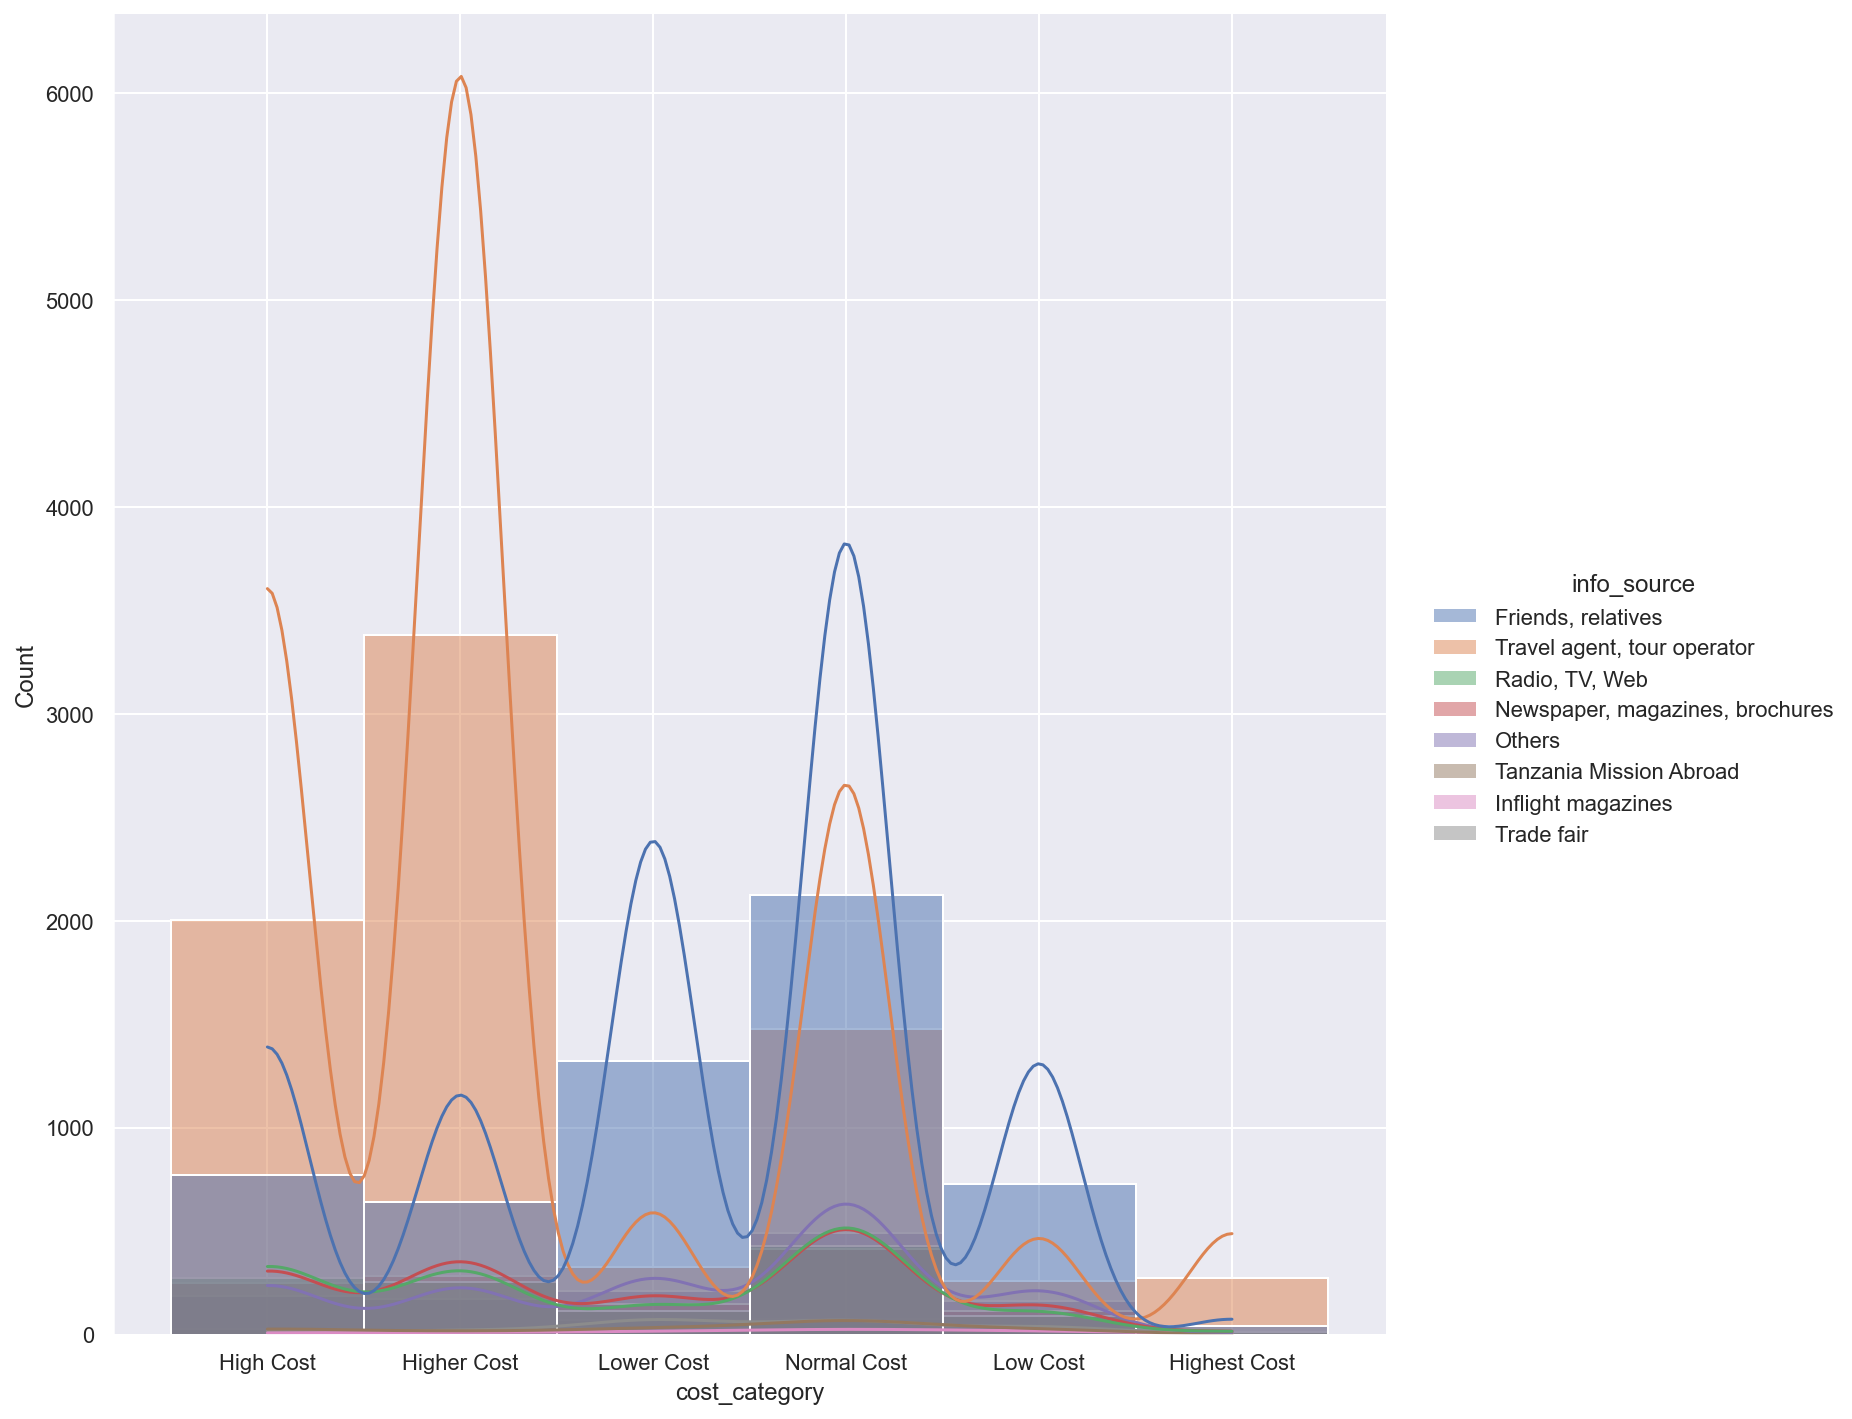

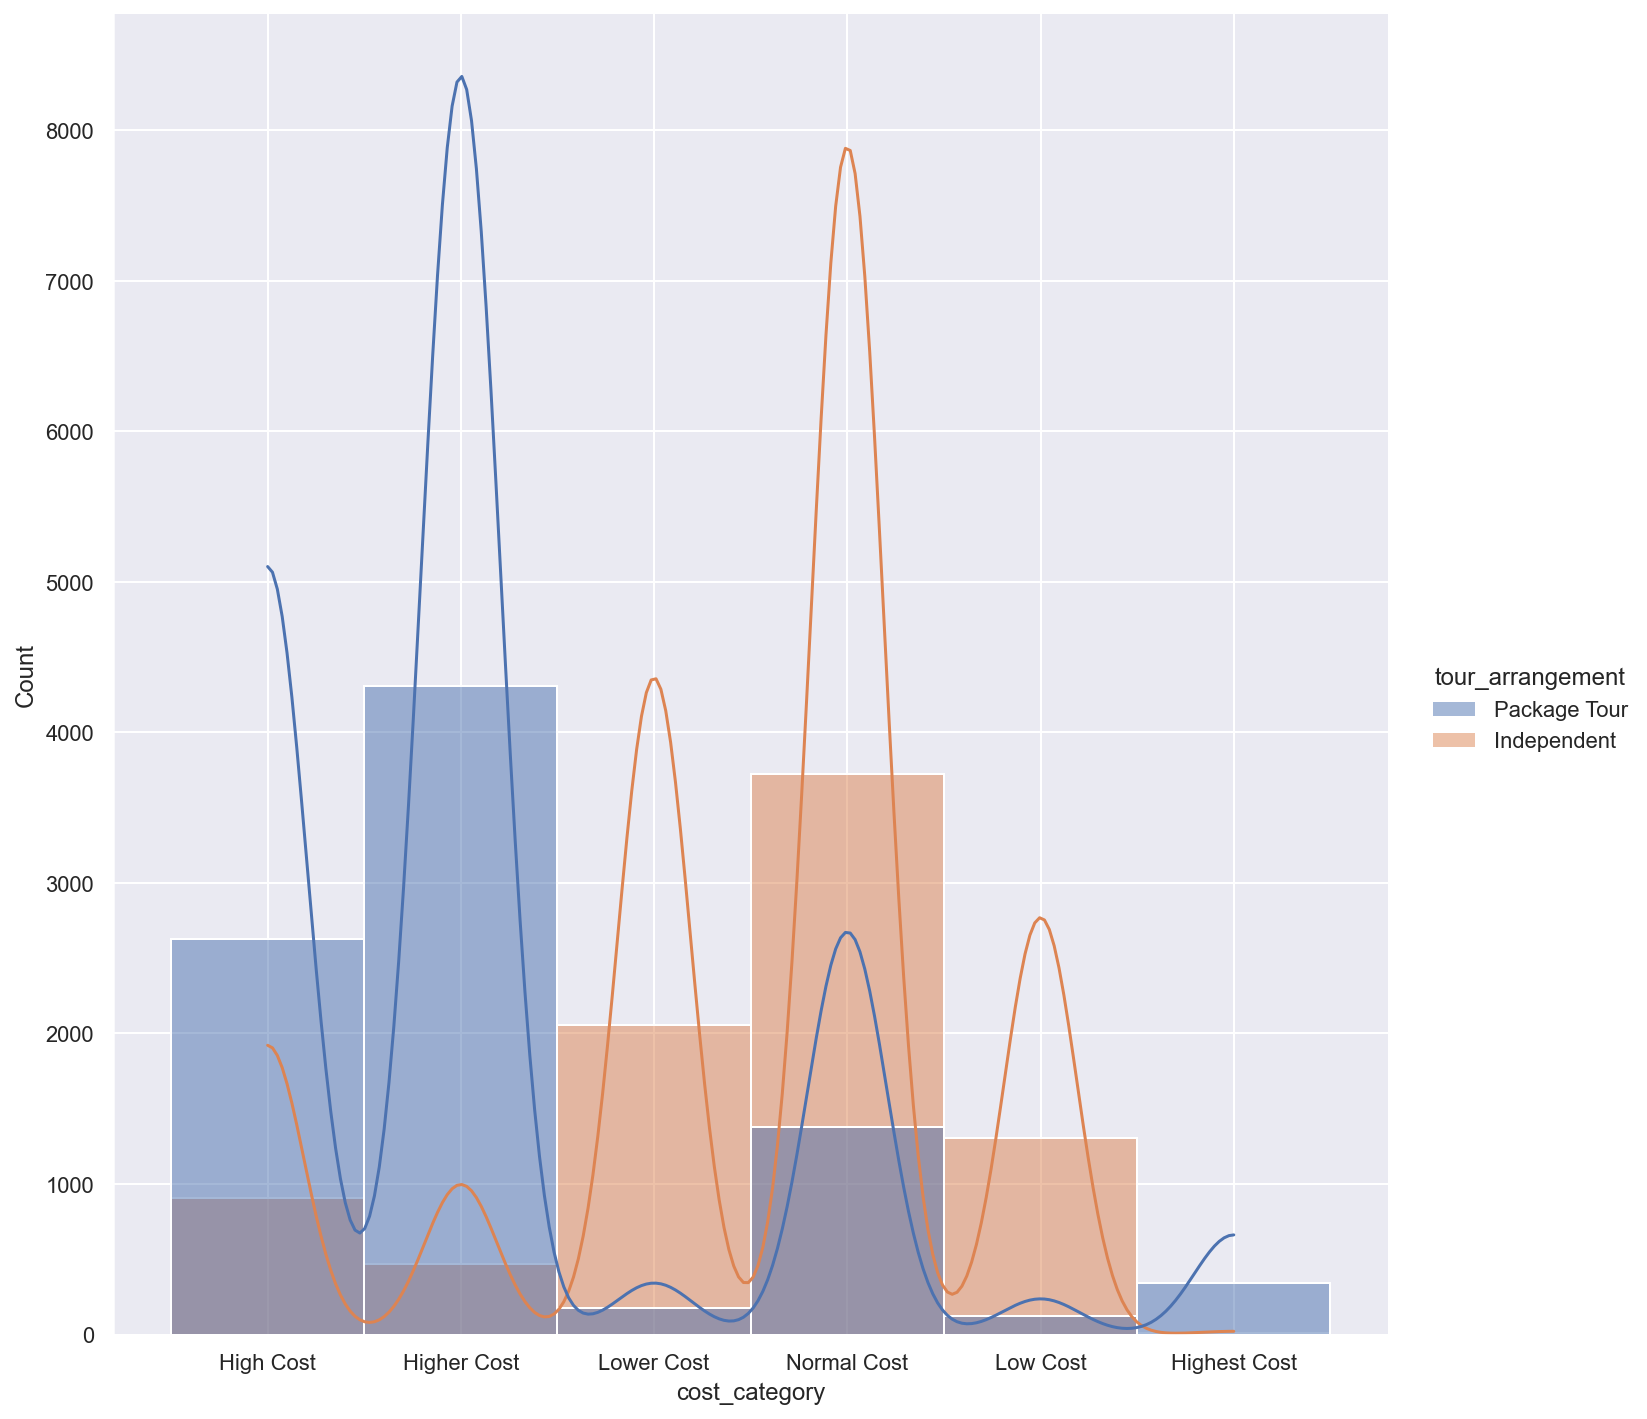

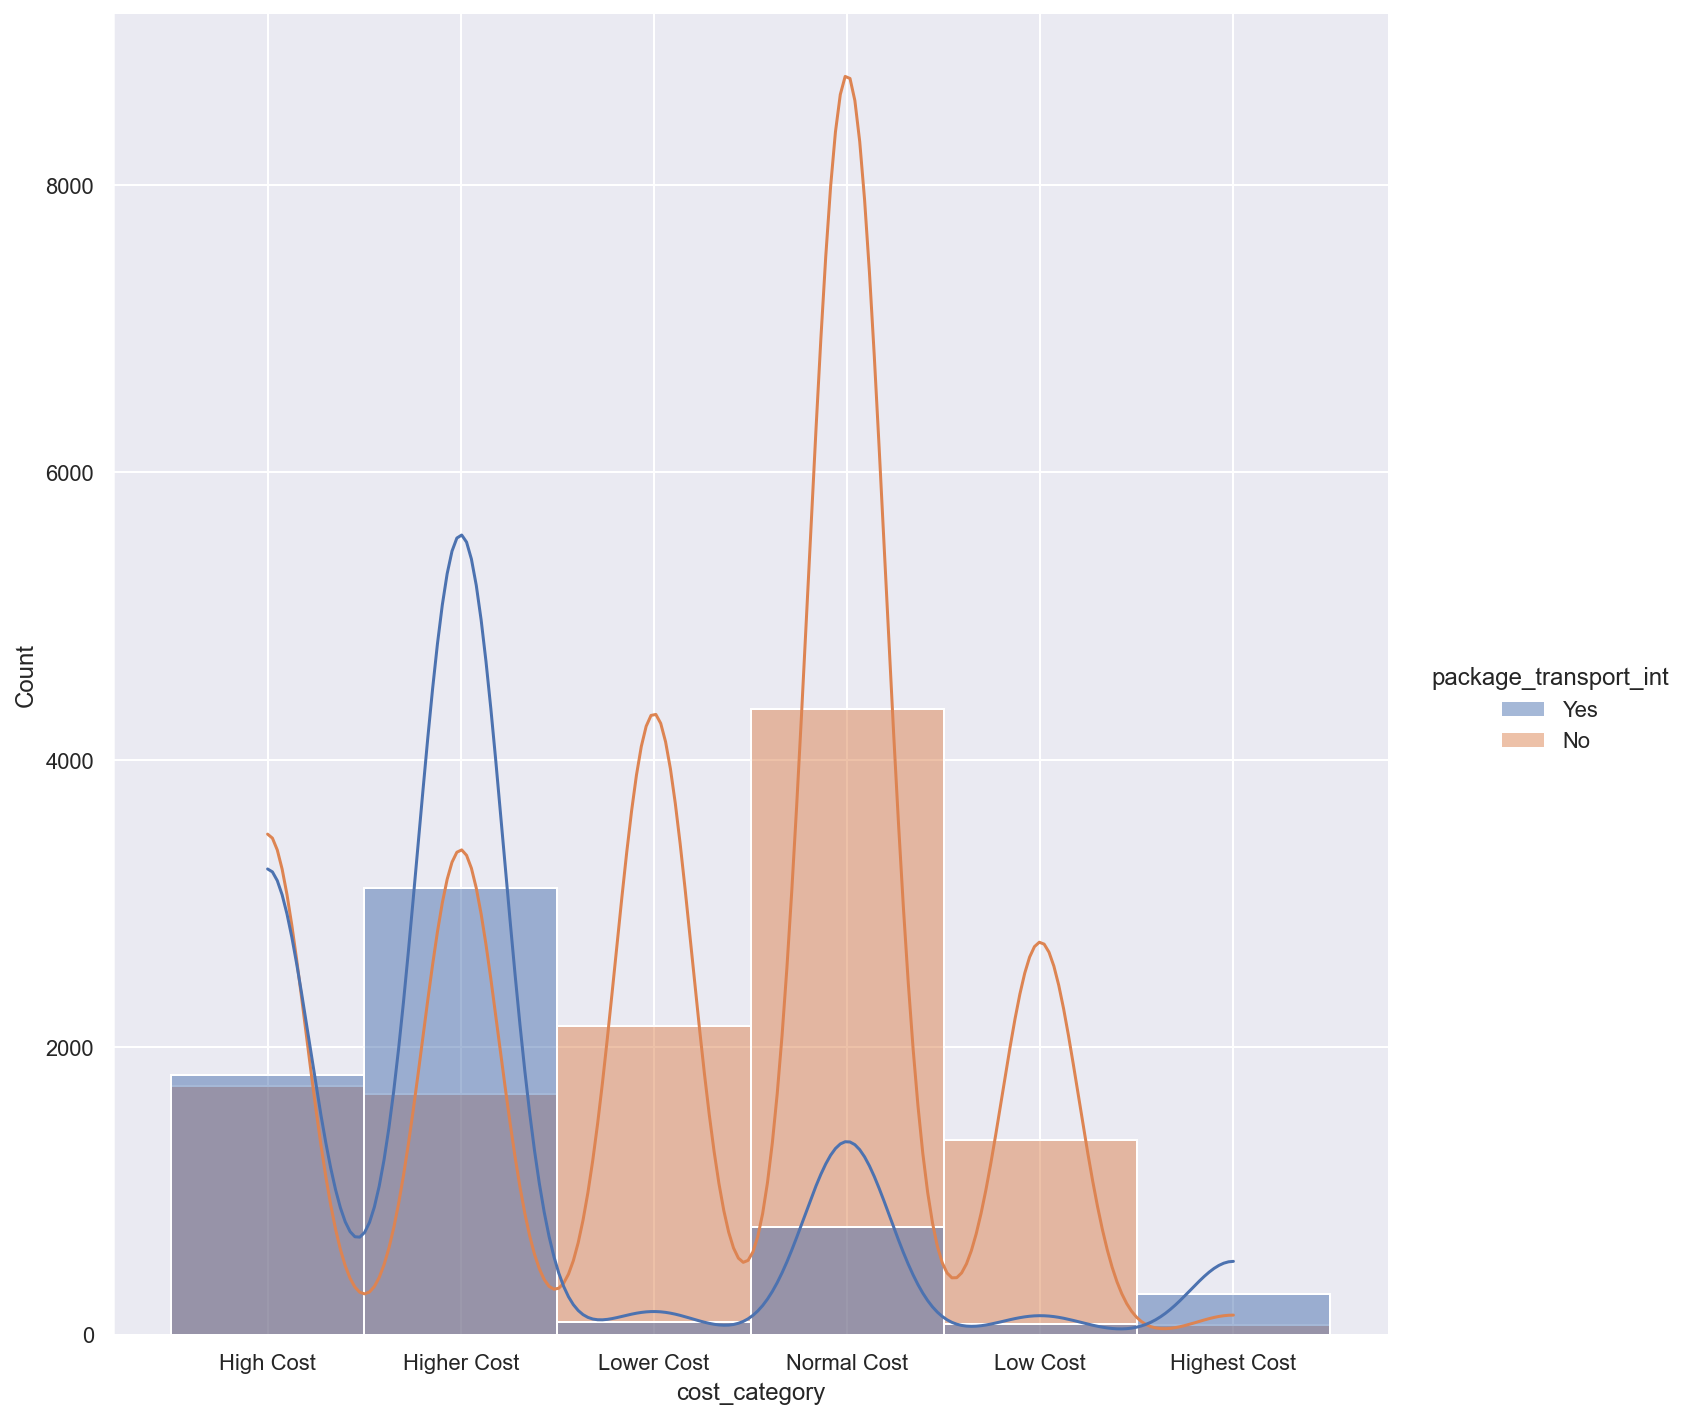

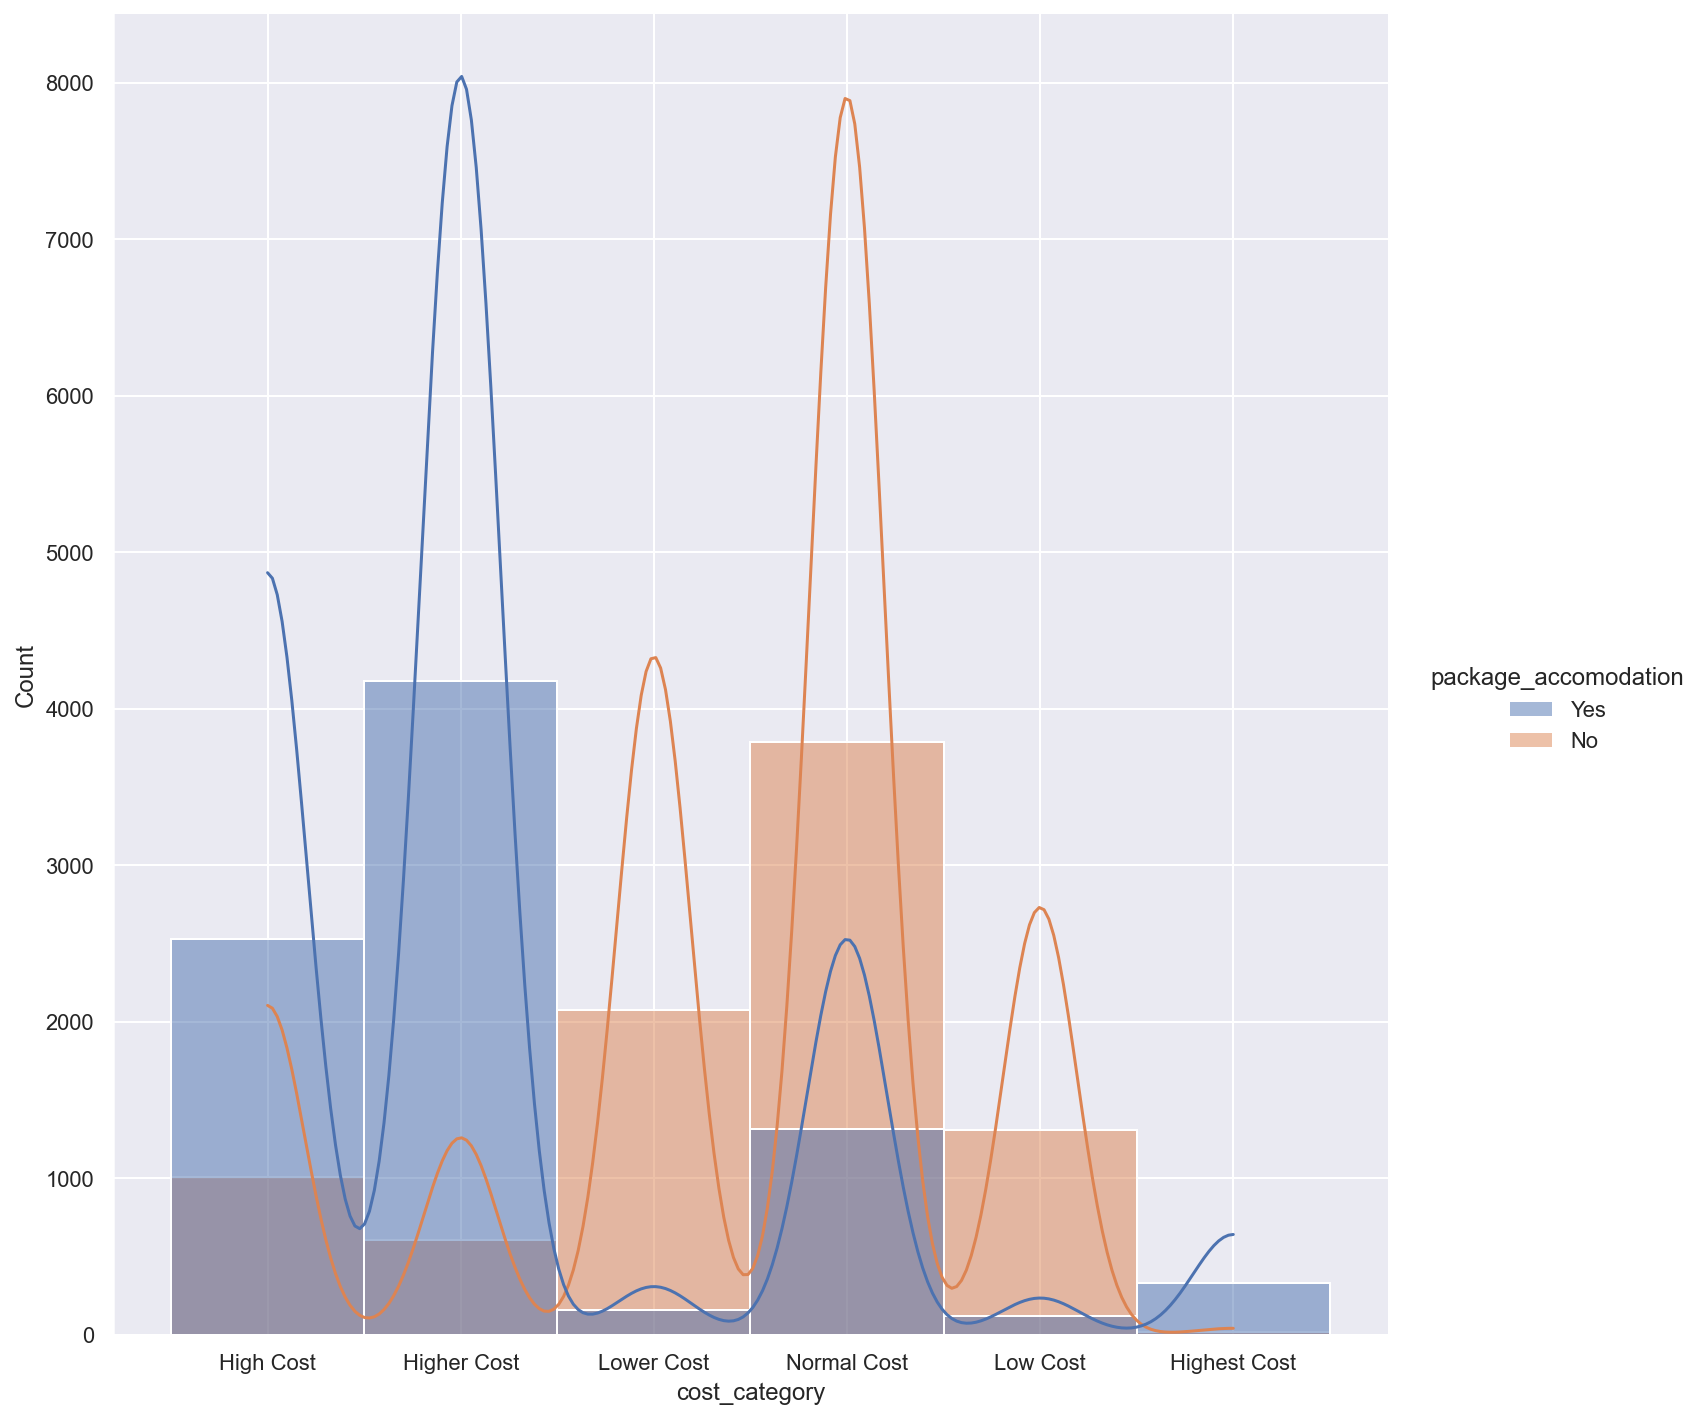

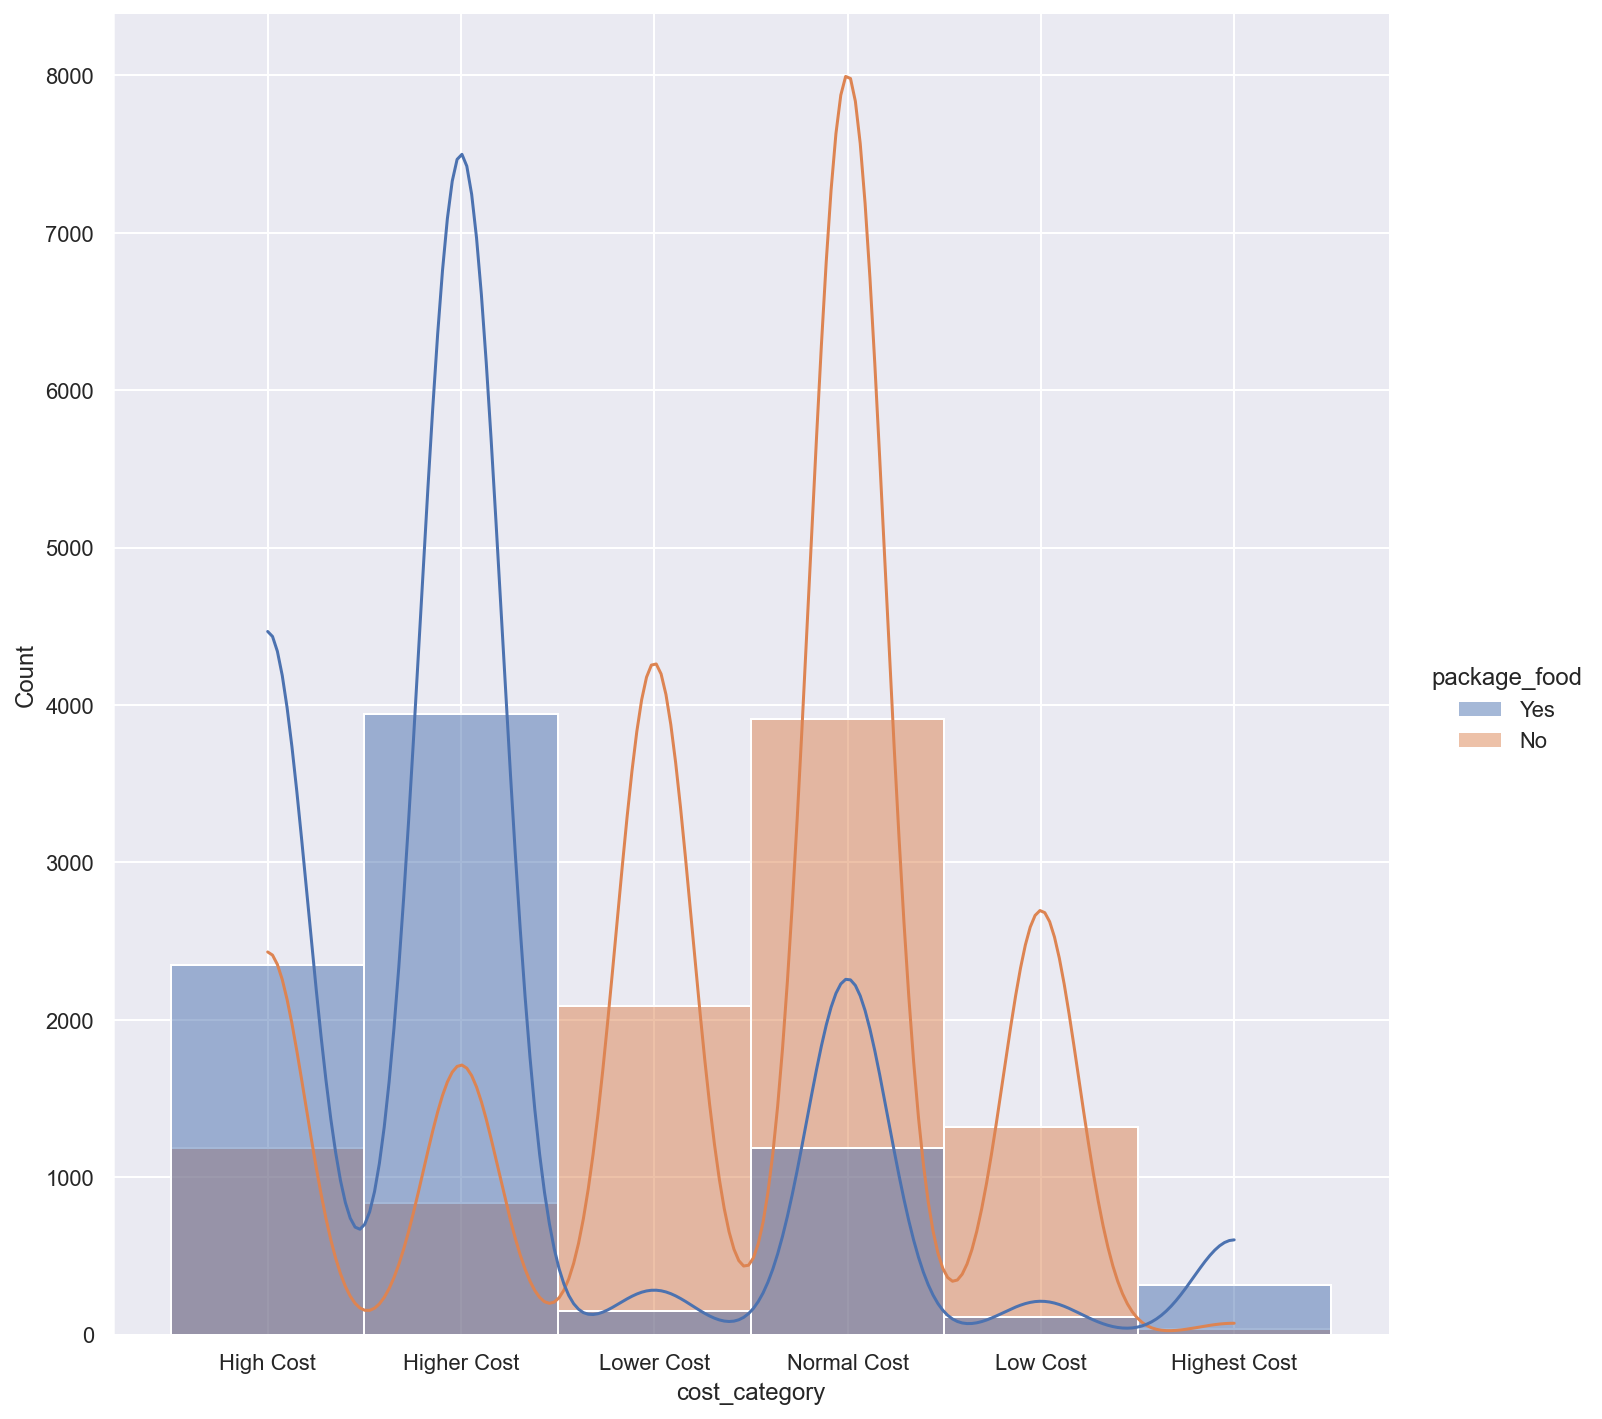

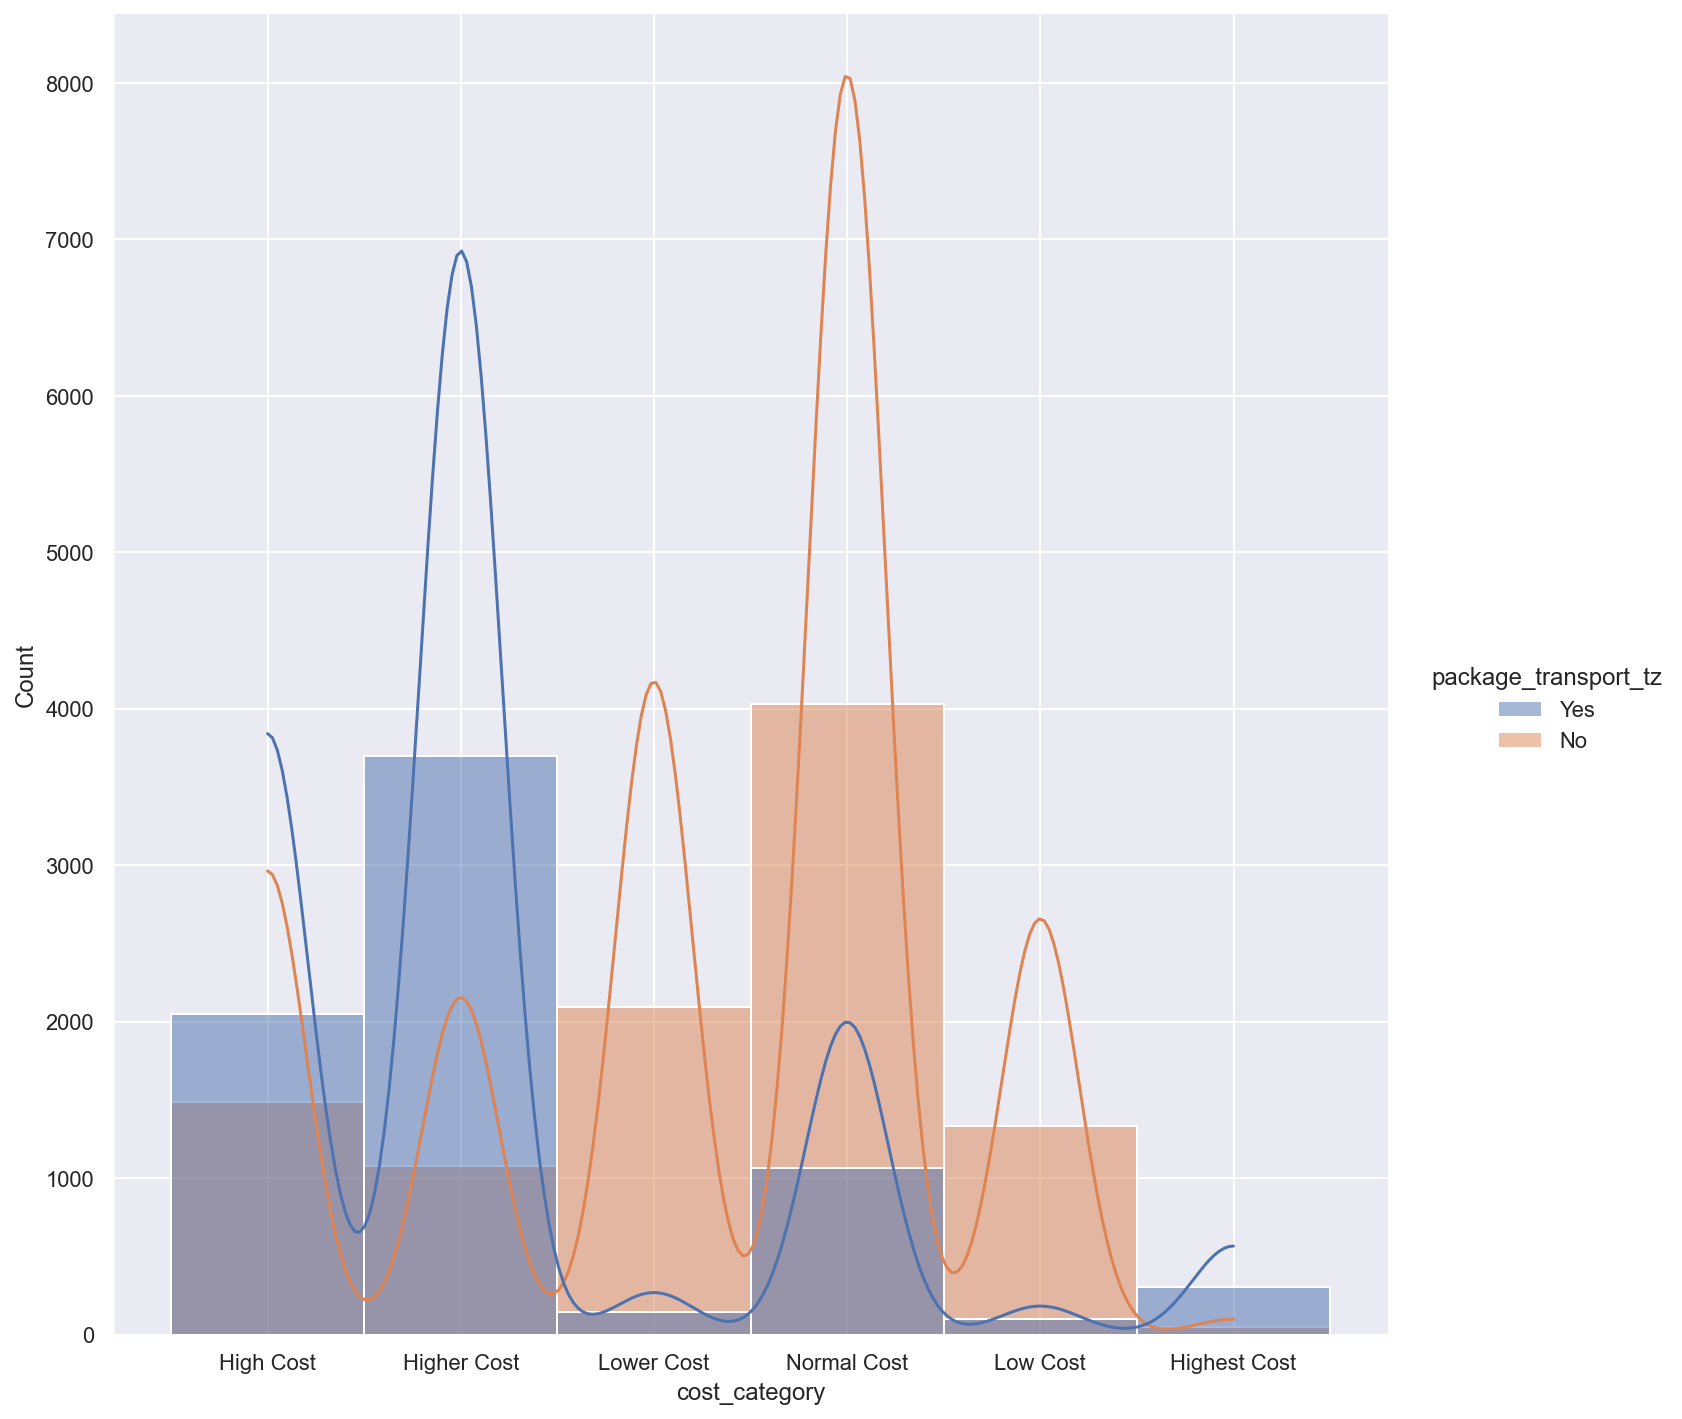

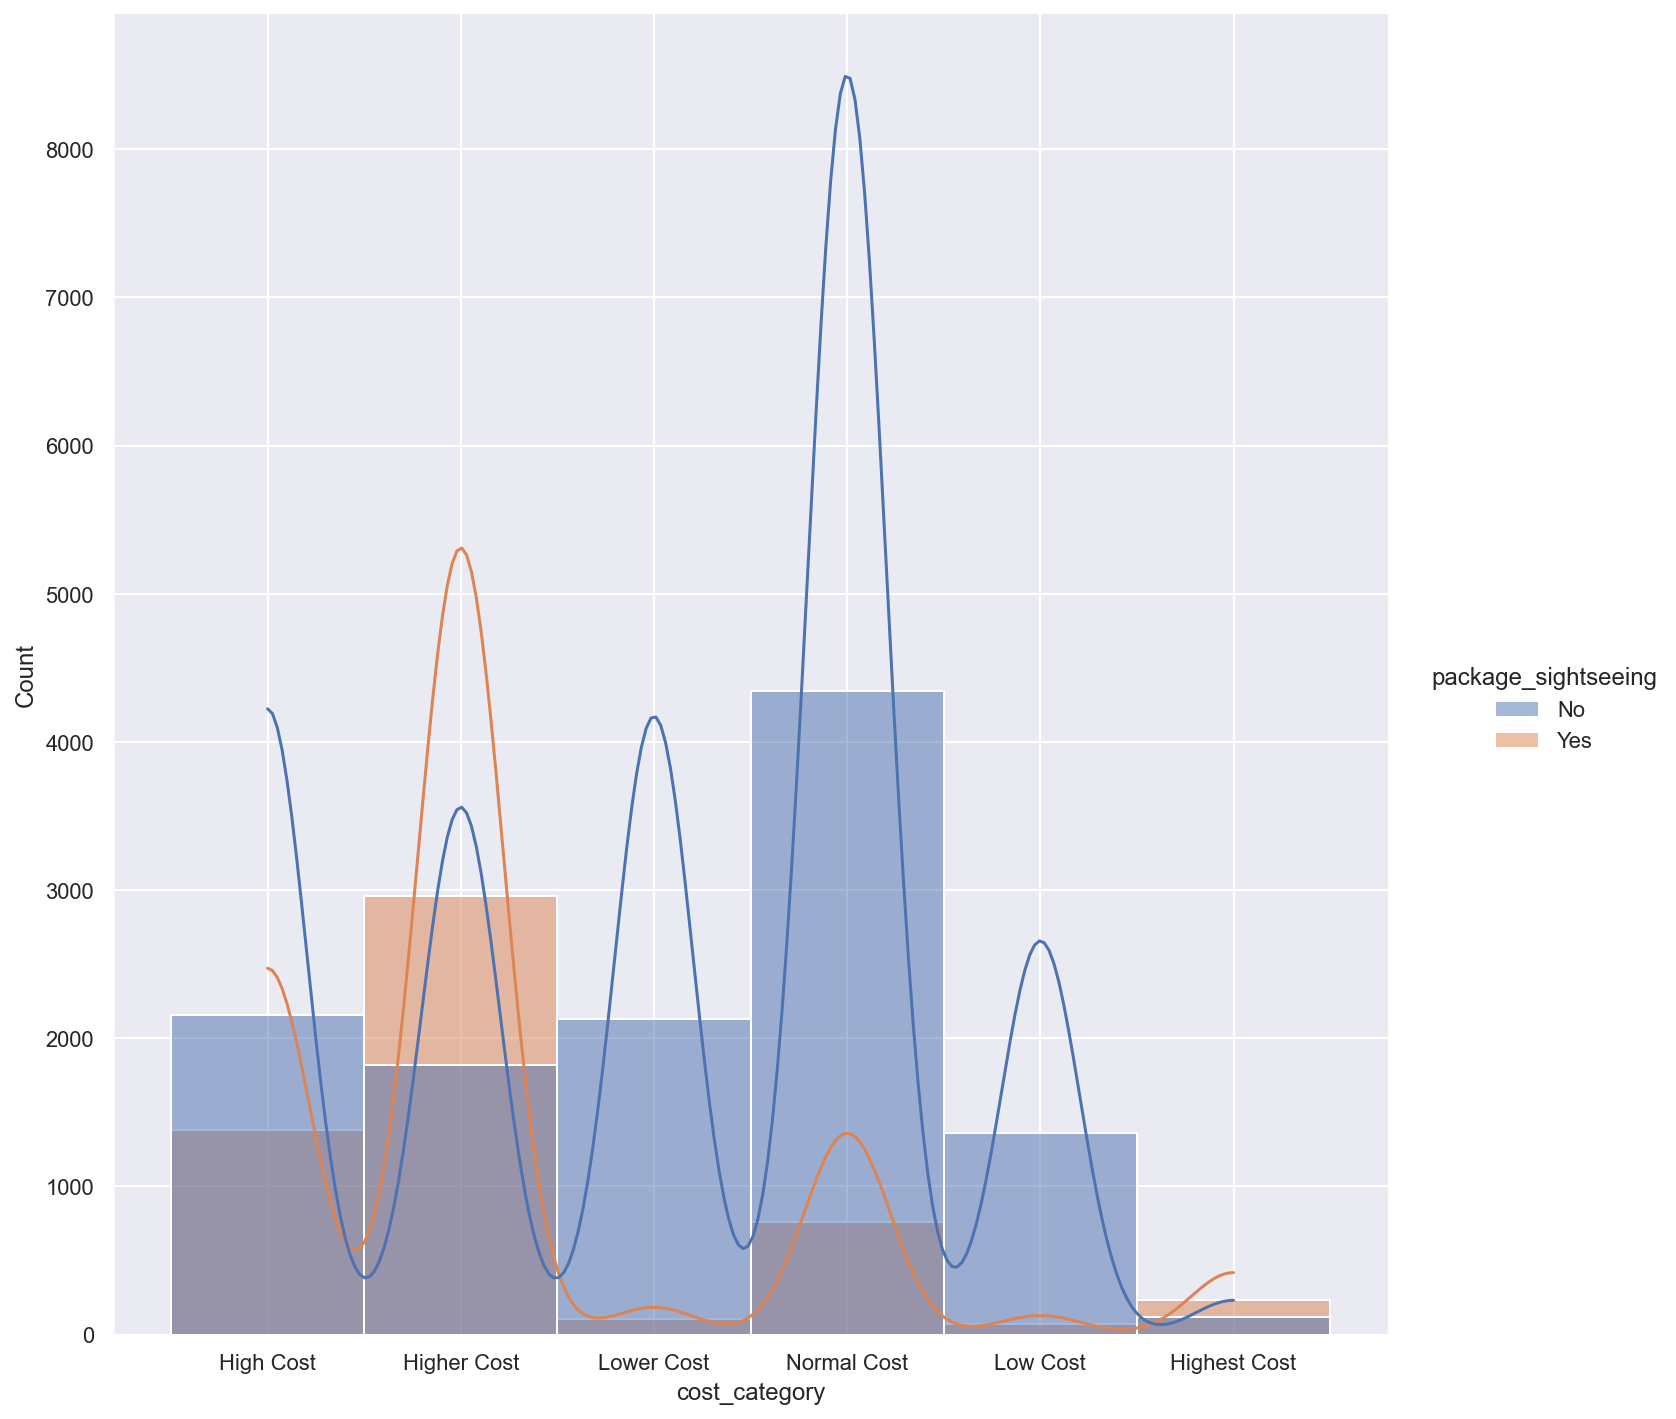

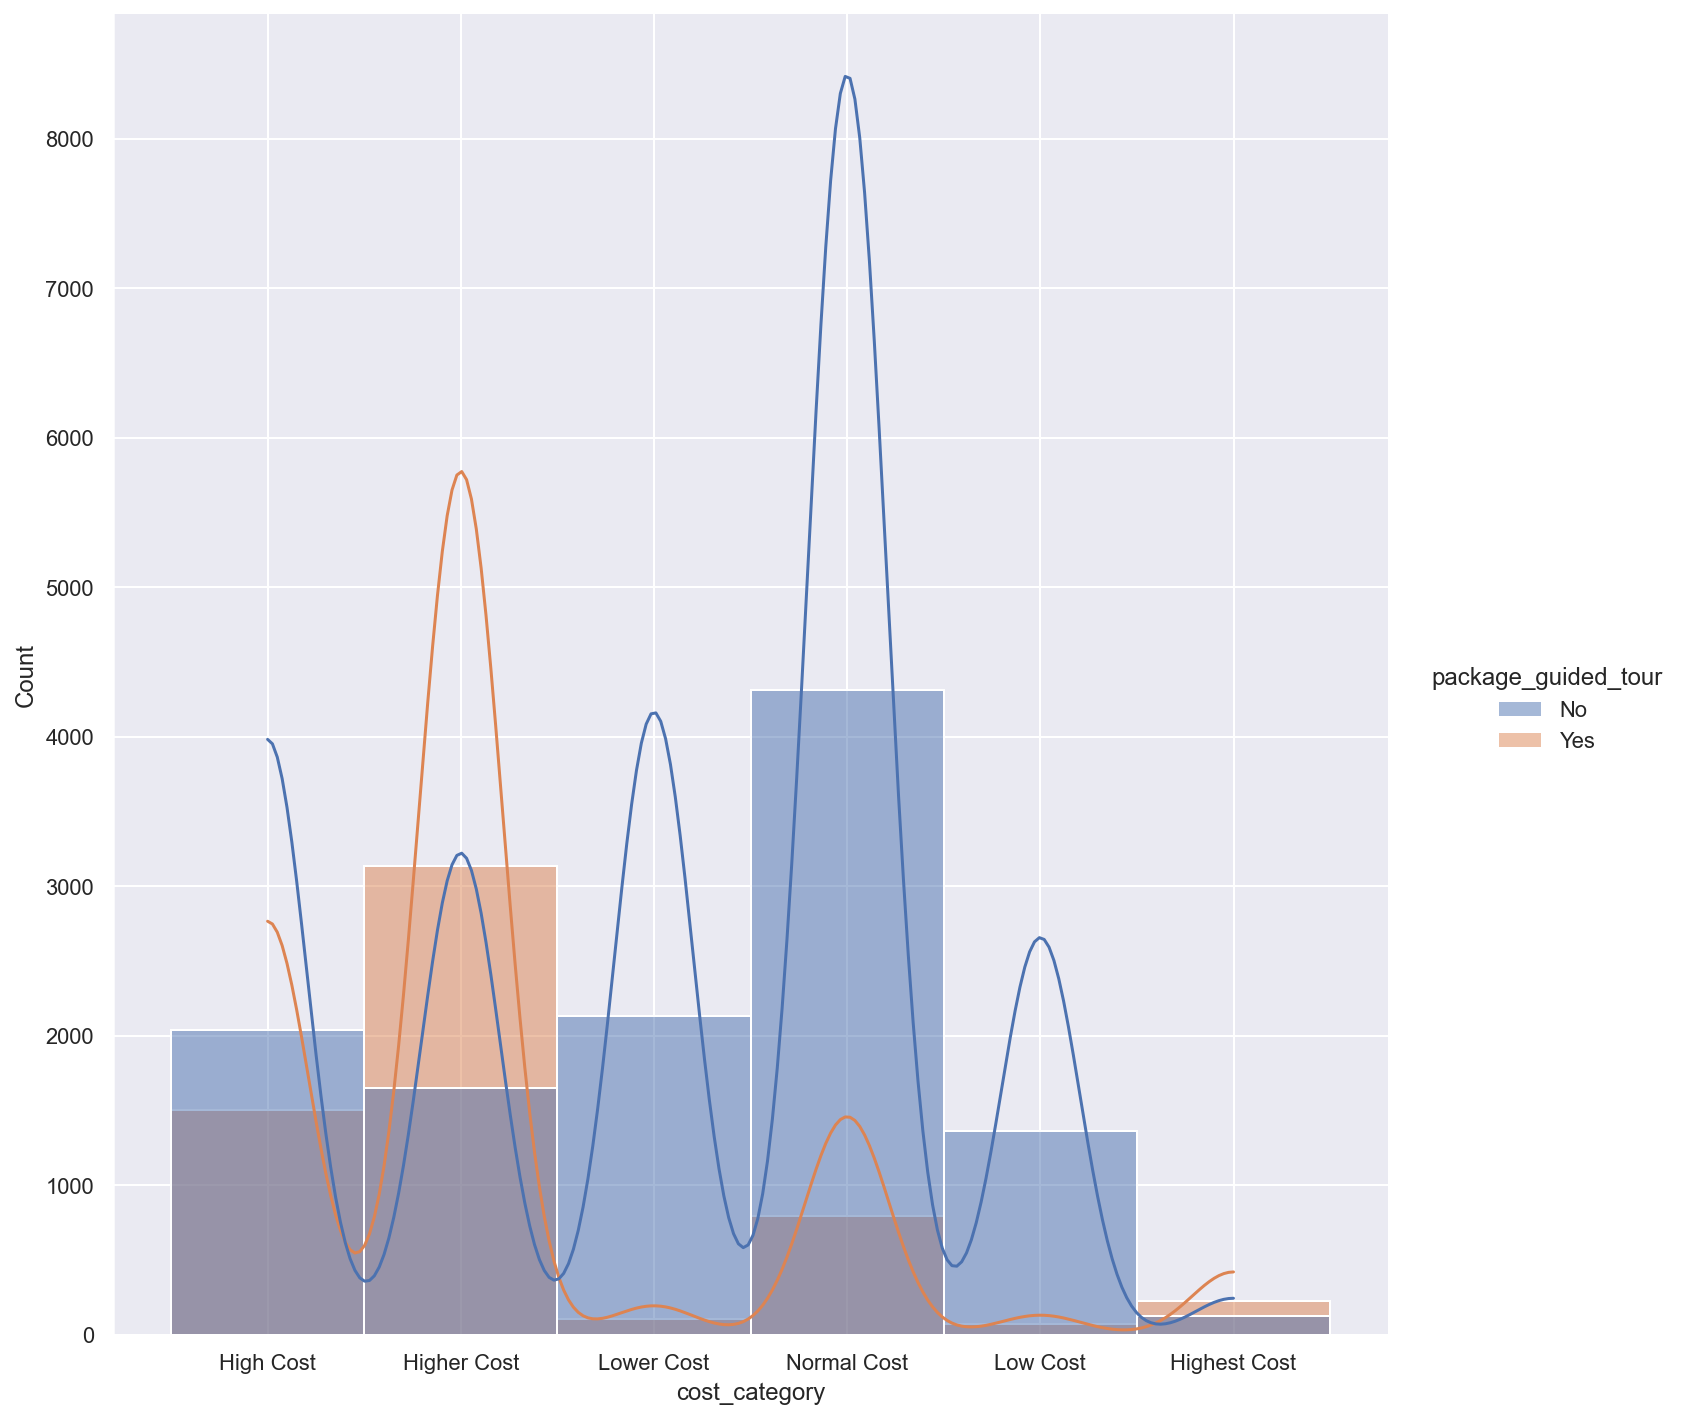

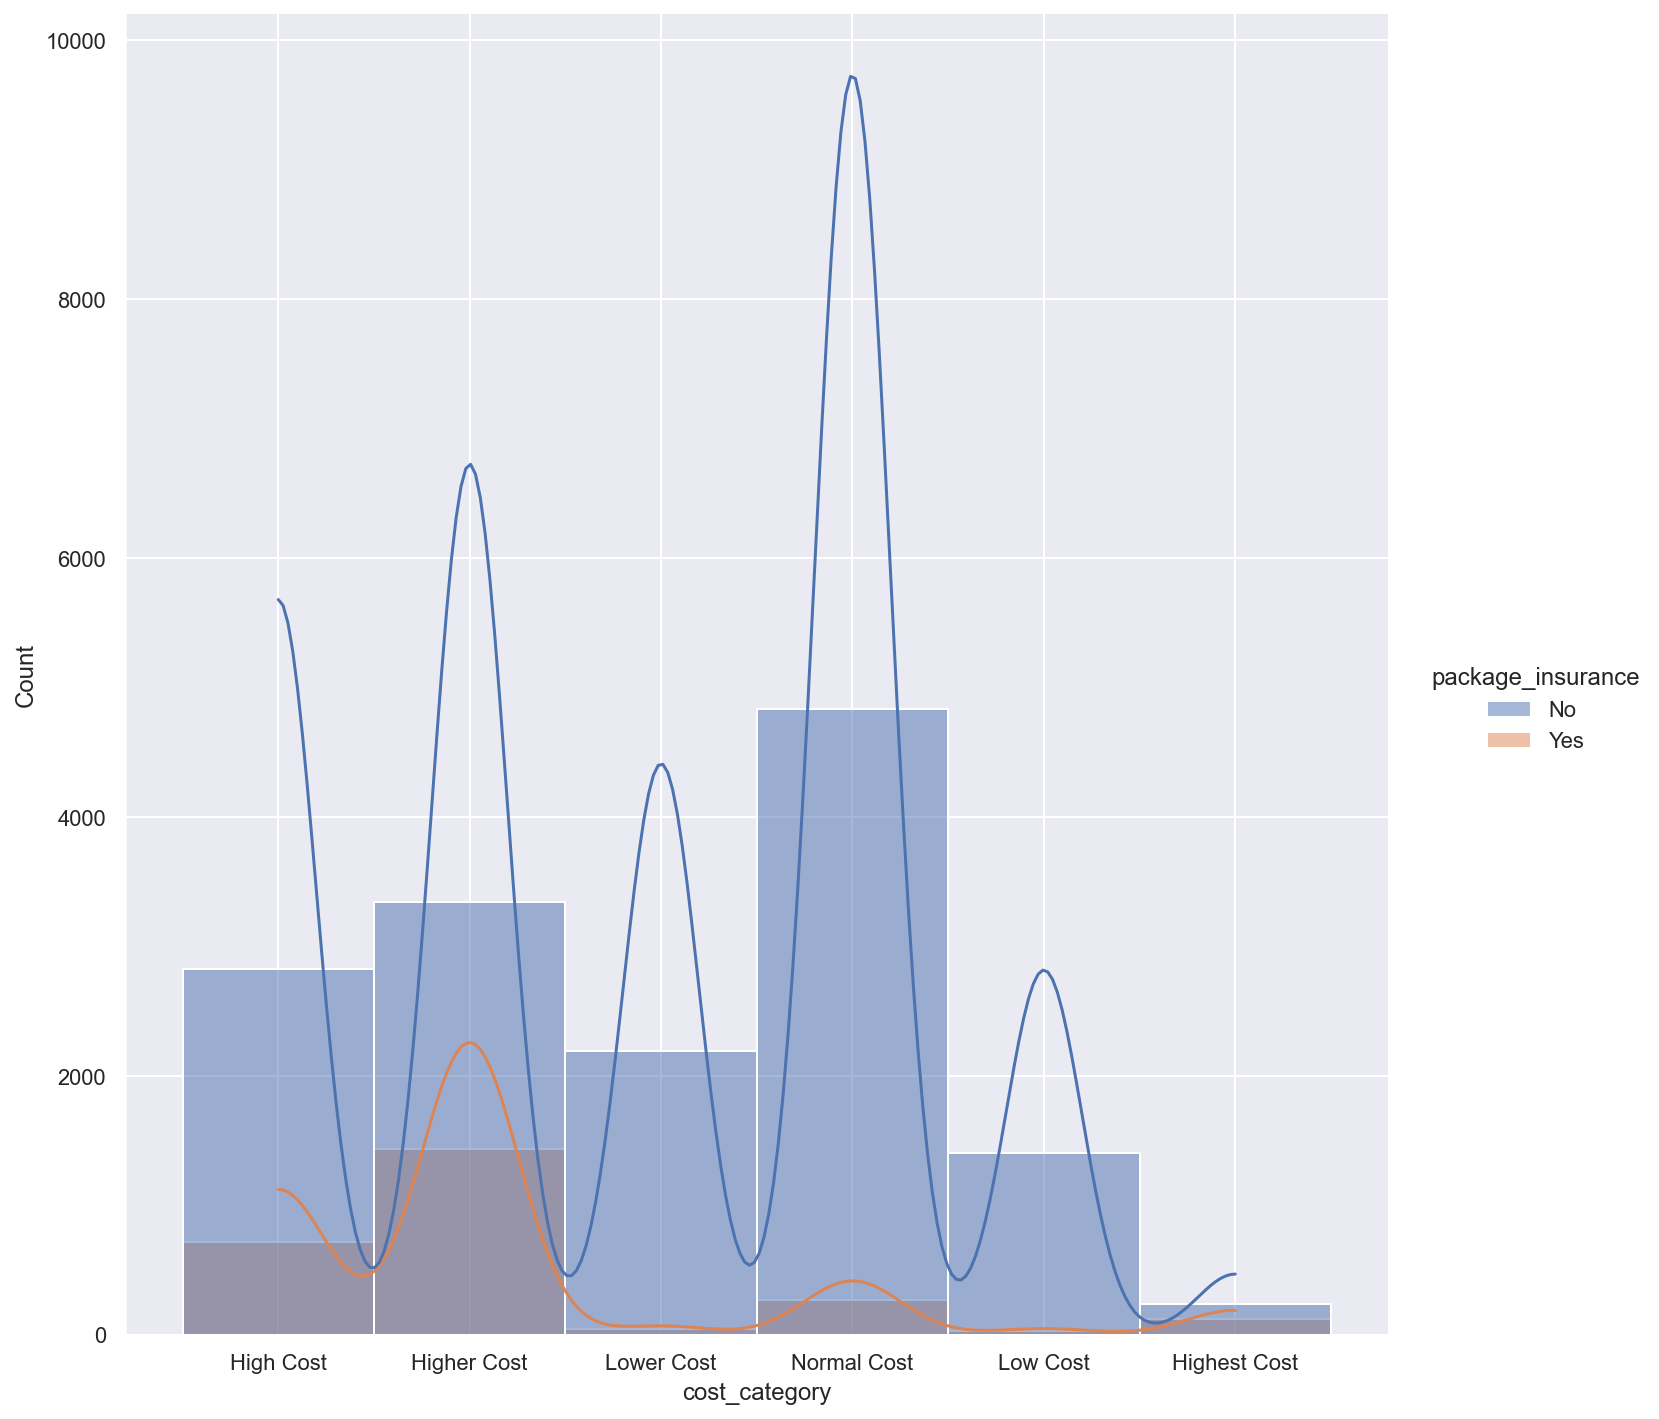

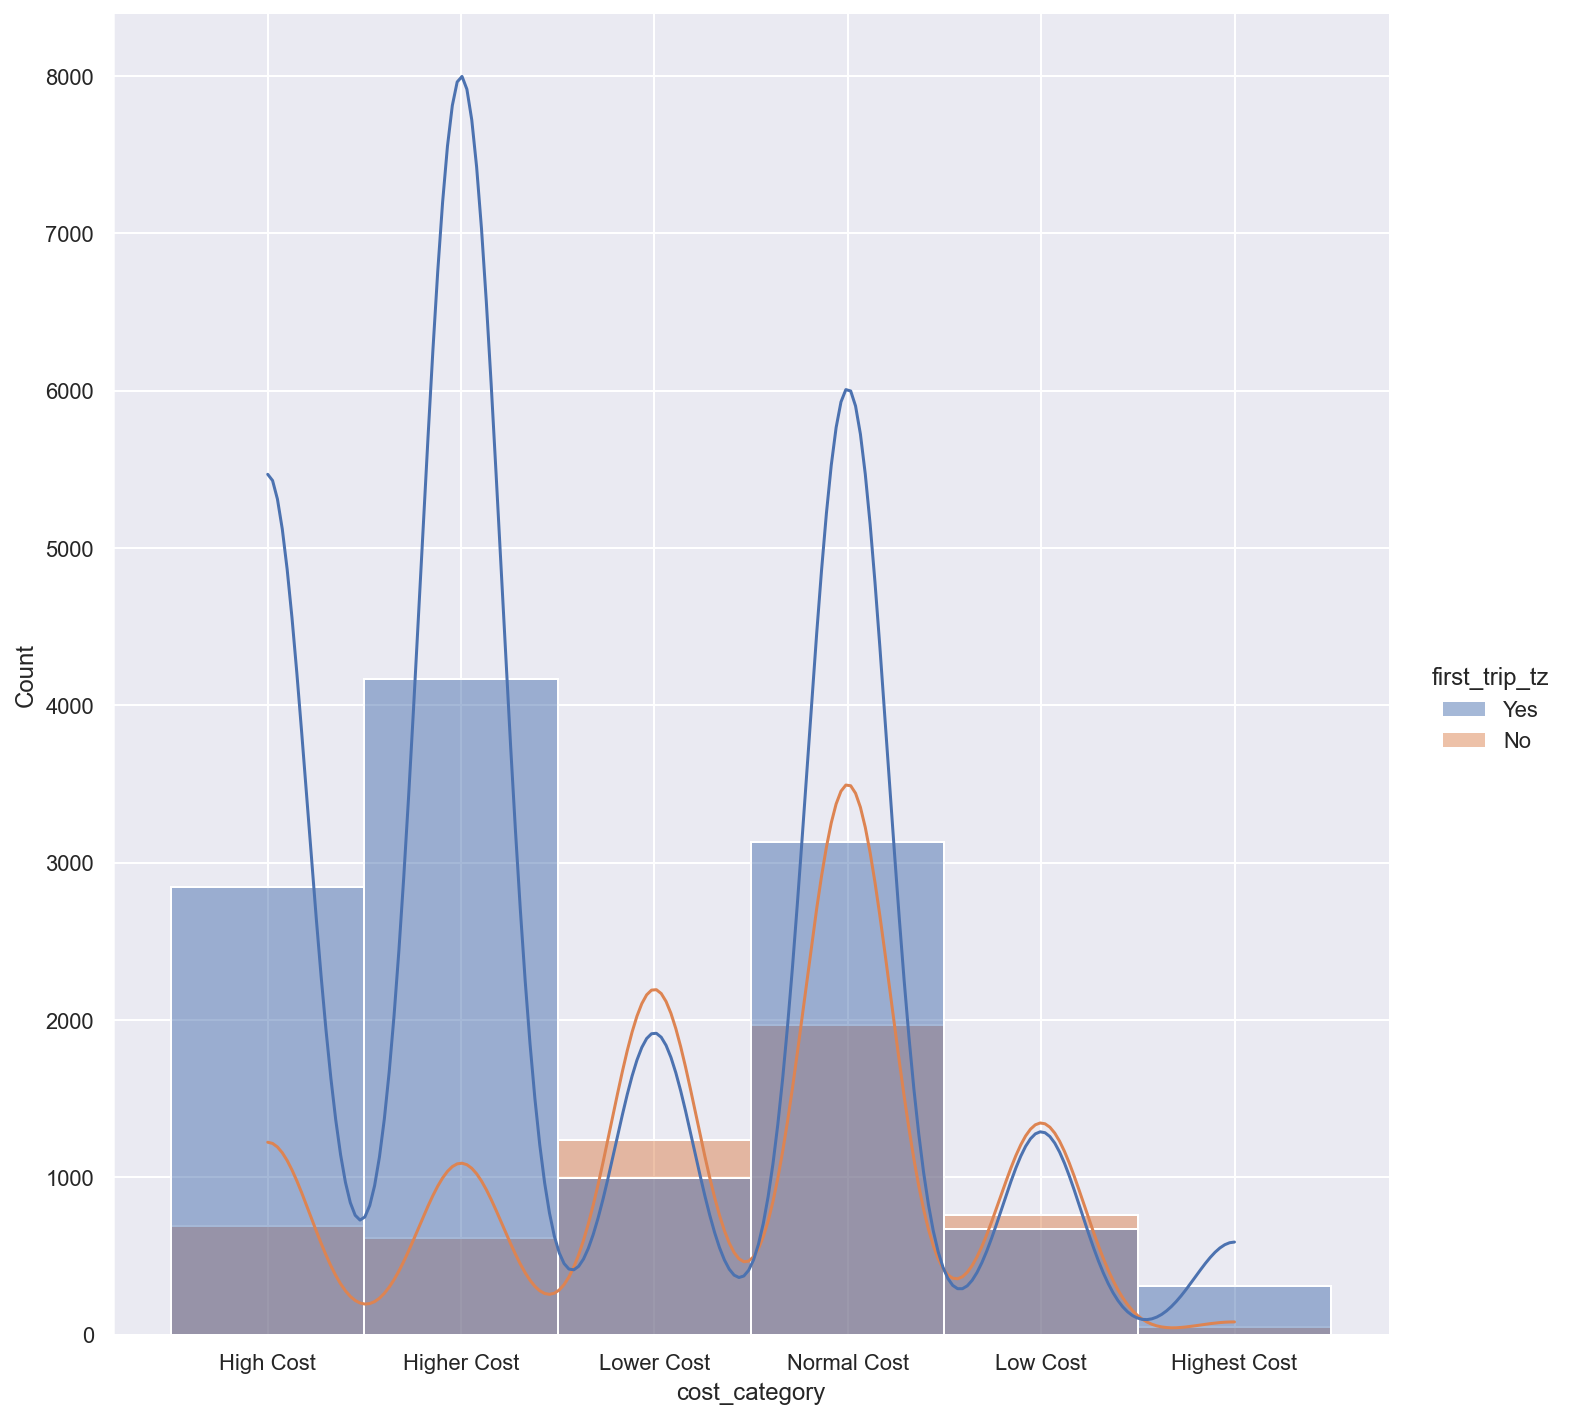

In [19]:
for col in categorical_variables[1:]:
    sns.displot(train_df, x="cost_category", hue=col, kde=True, height=10);

A lot of interesting information here. Also we spotted a data inconsistency due to a typo: _Widlife Tourism_ vs _Wildlife Tourism_ in the main activity column, we are going to fix this immediately.

In [20]:
train_df.main_activity = train_df.main_activity.replace("Widlife Tourism", "Wildlife Tourism")

We repeat the same plot as above for this column.

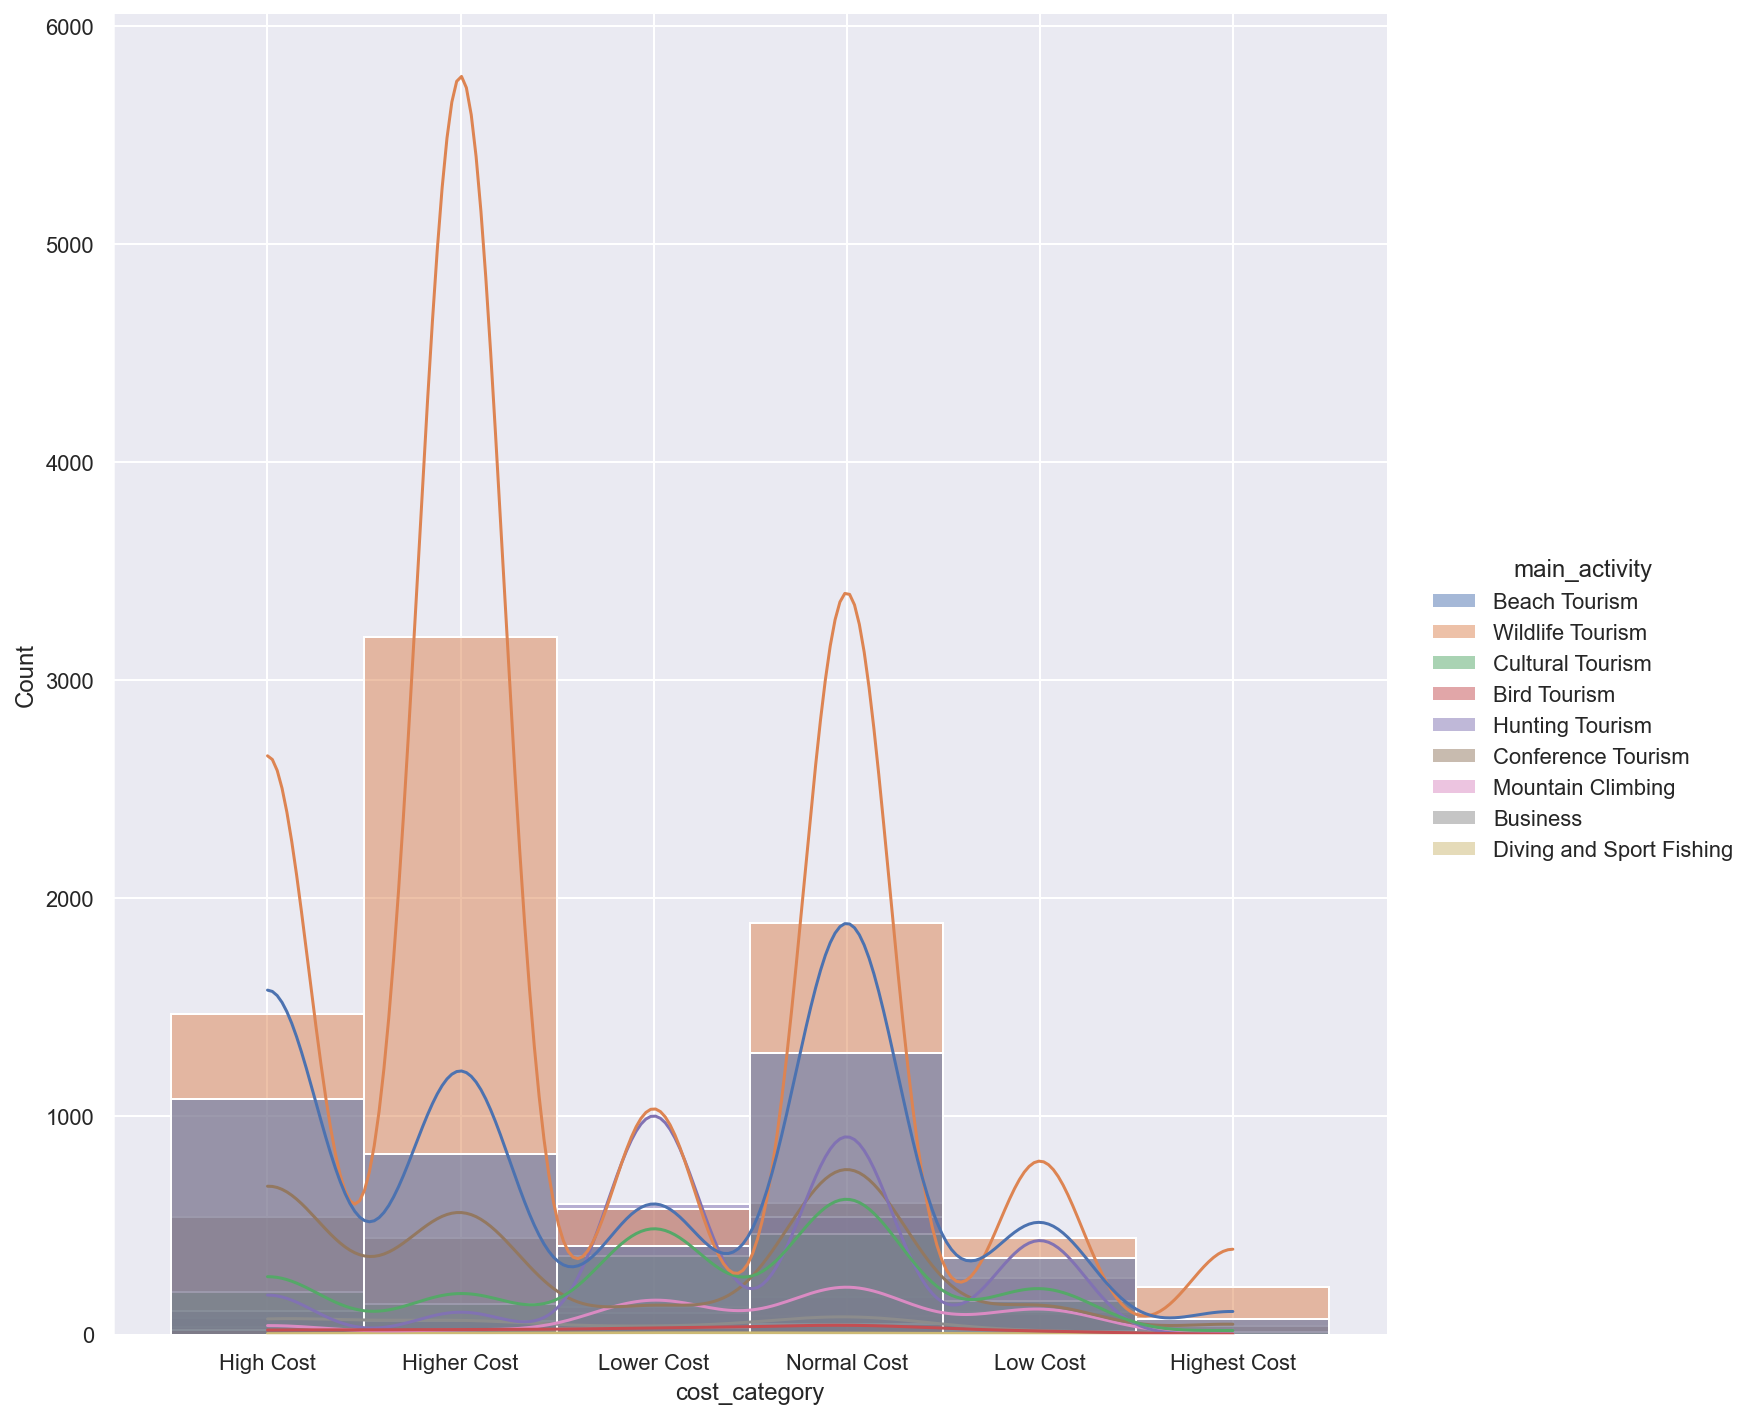

In [21]:
sns.displot(train_df, x="cost_category", hue="main_activity", kde=True, height=10);

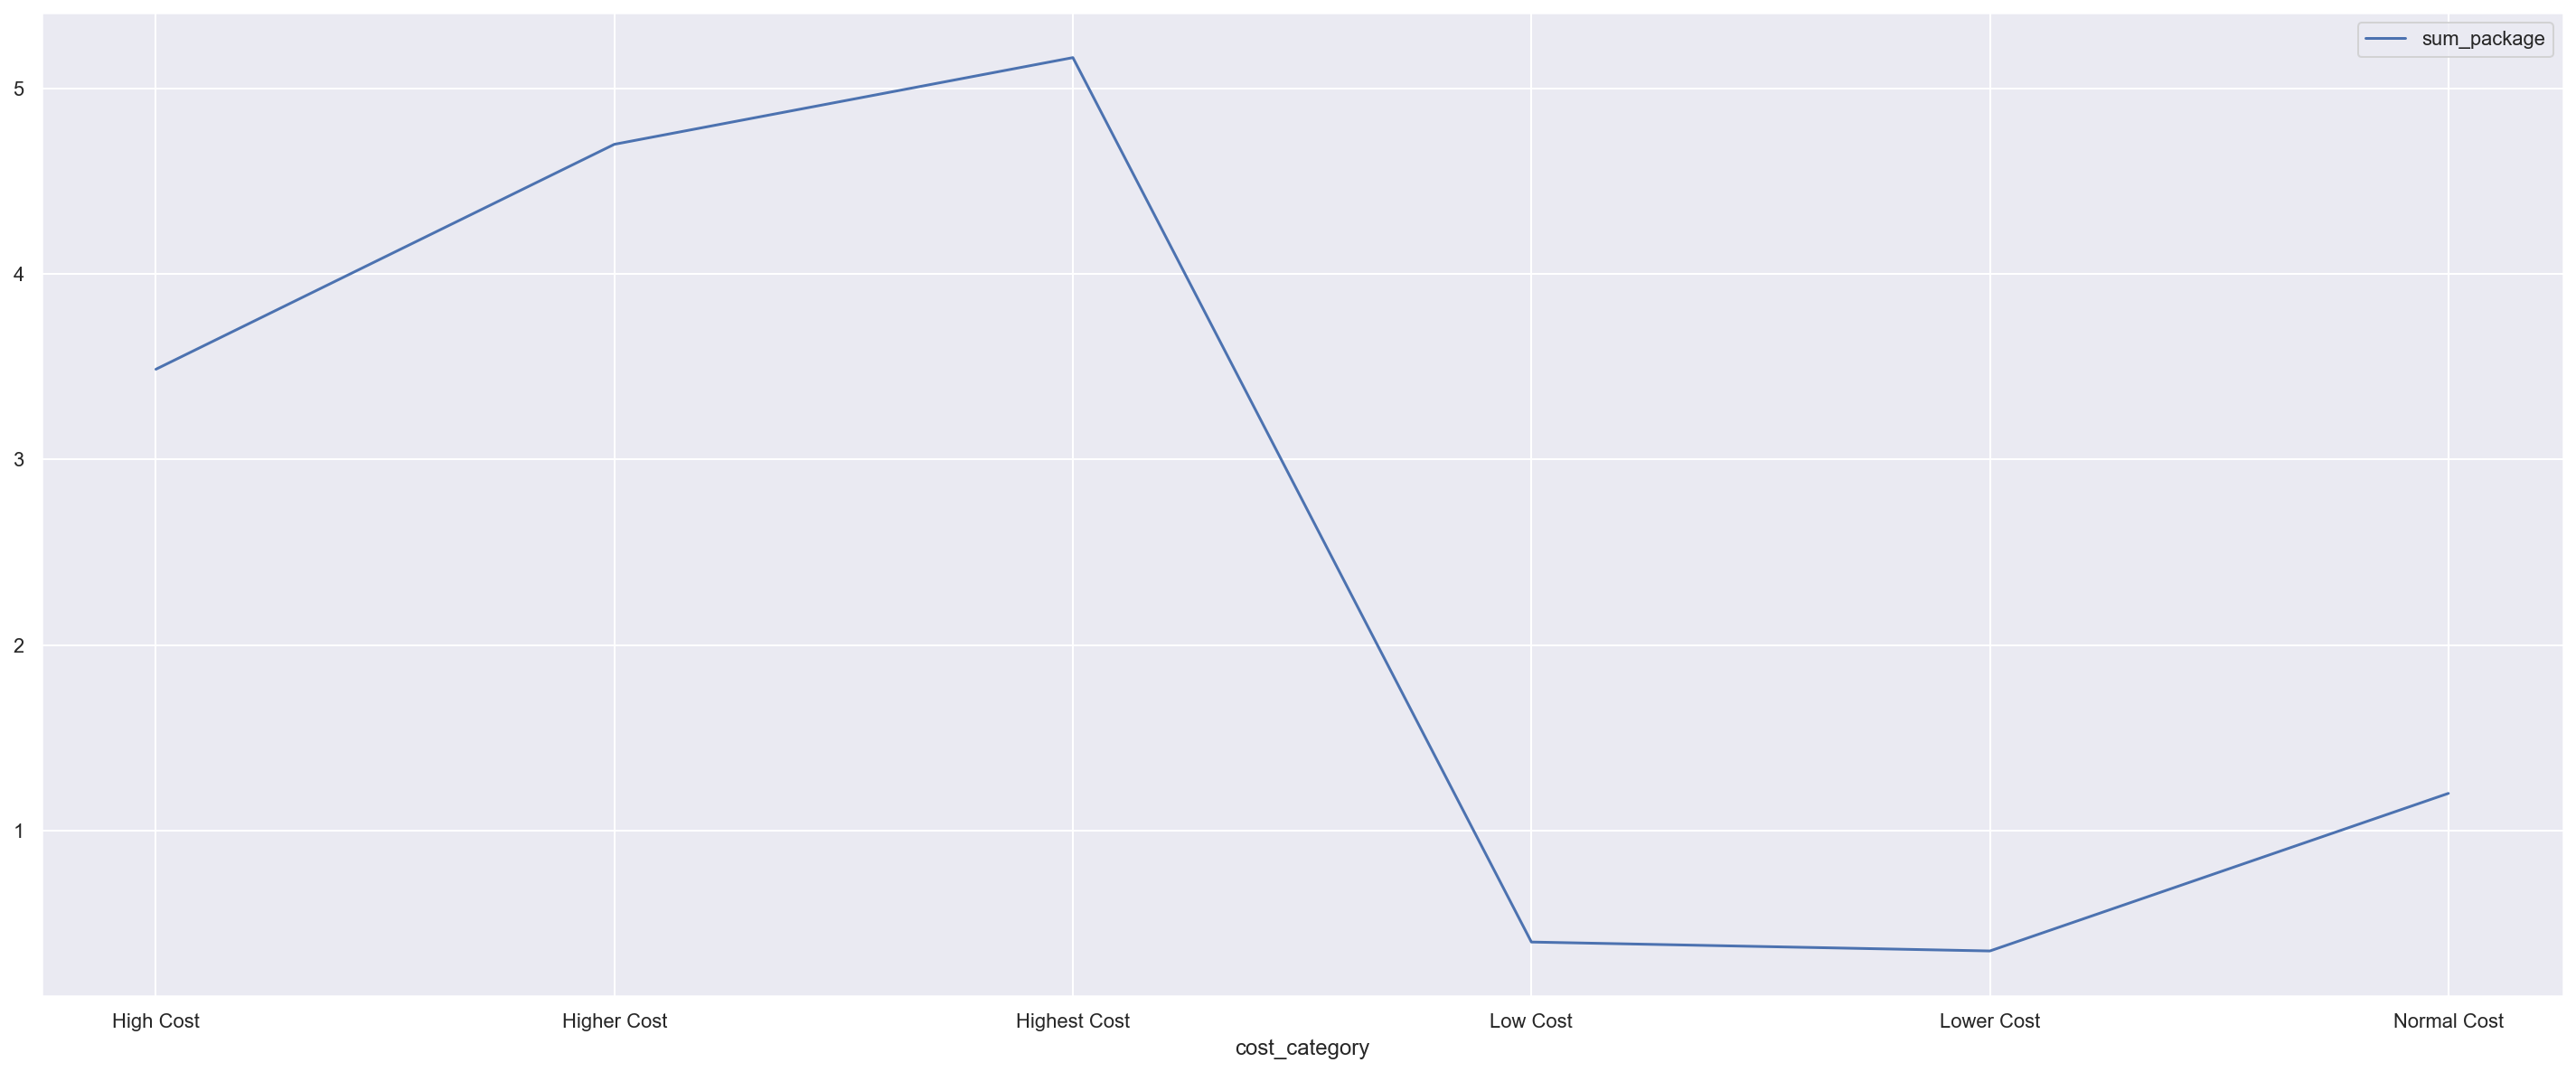

In [22]:
df['sum_package'] = np.sum(df[[c for c in train_df.columns if 'package' in c]].replace({"Yes": 1, "No": 0}).values, axis=-1)
df["cost_category"] = LabelEncoder().fit(train_df["cost_category"]).inverse_transform(df["cost_category"]) # Just to show readable labels

df[["sum_package", "cost_category"]].groupby("cost_category").mean().plot();


As on can see this is a good predictive variable (tourists with package options will spend more). 
This will be included in our feature engineering.

#### Aggregate countries in continents.

It might be useful to aggregate countries in bigger groups, as our work hypothesis is that a tourist from Italy would behave much more like one from France rather than one from Australia or Japan.

This can be easily done by a nice library called [pycountry](https://pypi.org/project/pycountry/), or composing an hard coded dictionary. 
With little surprise, the reader can imagine we choose the first option.

In [23]:
# We replace some country names as these are
# not recognised by pycountry otherwise
country_sub = {
  'Bosnia': 'Bosnia and Herzegovina',
  'Burgaria': 'Bulgaria',
  'Cape Verde': 'Cabo Verde',
  'Comoro': 'Comoros',
  'Costarica': 'Costa Rica',
  'Czech Republic': 'Czechia', 
  'Djibout': 'Djibouti', 
  'Drc': 'Congo', 
  'Ecuado': 'Ecuador', 
  'Ivory Coast': "Côte d'Ivoire",
  'Macedonia': 'North Macedonia', 
  'Malt': 'Malta', 
  'Monecasque': 'Monaco',
  'Morroco': 'Morocco', 
  'Philipines': 'Philippines', 
  'Russia': 'Russian Federation', 
  'Saud Arabia': 'Saudi Arabia',
  'Scotland': 'United Kingdom', 
  'Somali': 'Somalia',
  'Swaziland': 'Eswatini', 
  'Swizerland': 'Switzerland', 
  'Trinidad Tobacco': 'Trinidad and Tobago', 
  'Uae': 'United Arab Emirates', 
  'Ukrain': 'Ukraine',
  'United States Of America': 'United States', 
  'Vietnam': 'Viet Nam', 
}

countries = {}
for country in pycountry.countries:
  countries[country.name.split(',')[0].strip()] = country.alpha_2

def get_country(x: str) -> str:
  """Function to correct the country name spelling in the dataframe.

  Parameters
  ----------
  x : str
      The name of the country as the keys in the dictionary country_sub.

  Returns
  -------
  str
      The name of the country correctly spelled.
  """
  return country_sub.get(x.title(), x.title())

def get_alpha2(x: str) -> str:
  """Function to get the country name in the format of pycountry.

  Parameters
  ----------
  x : str
      The name of the country.

  Returns
  -------
  str
      The name of the country in the desired format.
  """
  return countries.get(x, x)

def get_continent(x: str) -> str:
  """Function to get the continent correspondig to the input country.
  This function is a wrapper of the pycountry library method country_alpha2_to_continent_code.

  Parameters
  ----------
  x : str
      The name of the country whose continent has to be determined.

  Returns
  -------
  str
      The code of the continent.
  """
  return pc.country_alpha2_to_continent_code(x)

# Vectorise the function to apply to np.arrays
get_cont_vec = np.vectorize(lambda x: get_continent(get_alpha2(get_country(x))))

train_df["continent"] = train_df["country"].apply(get_country).apply(get_alpha2).apply(get_continent)
test_df["continent"] = test_df["country"].apply(get_country).apply(get_alpha2).apply(get_continent)

Let's now explore how continets are related to category cost.

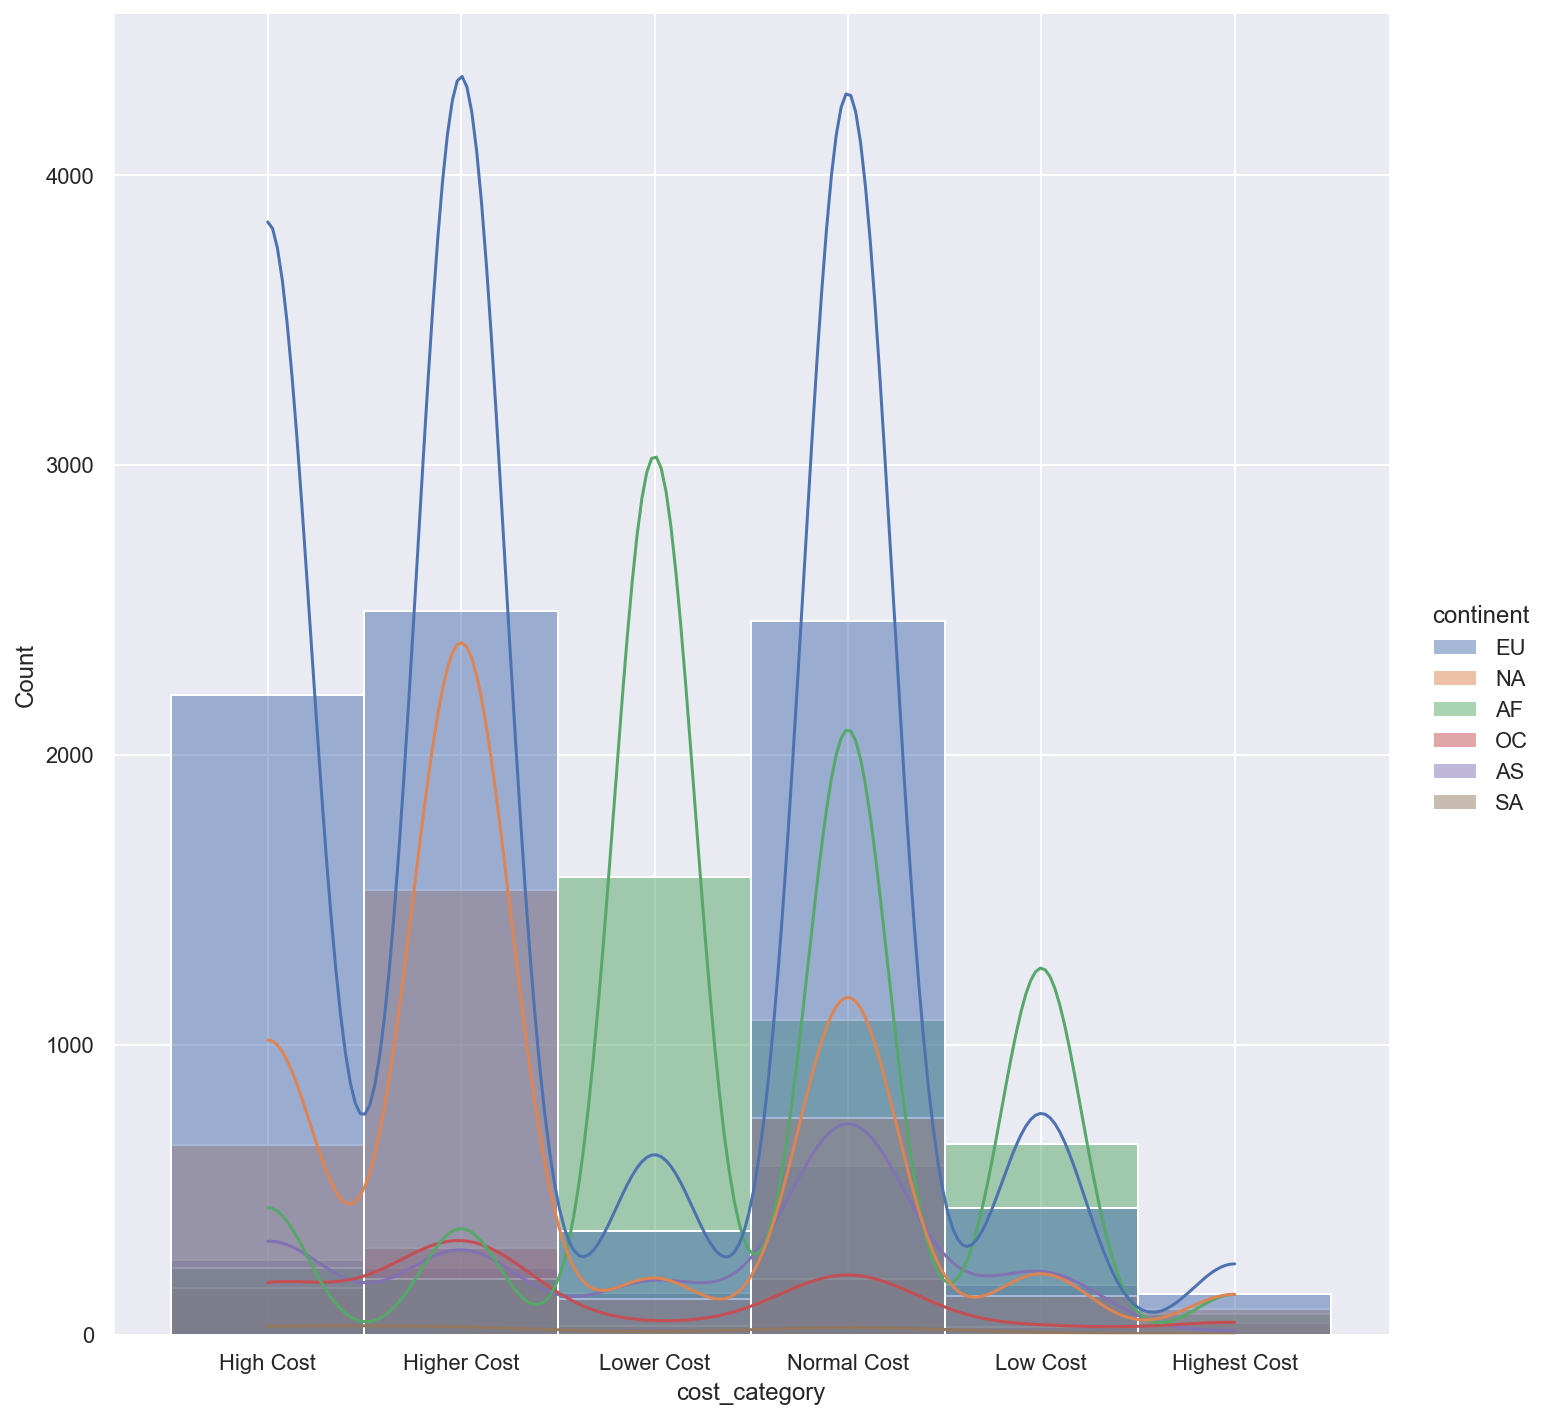

In [24]:
sns.displot(train_df, x="cost_category", hue="continent", kde=True, height=10);

Really useful information that we will encode in our dataset.

It is noteworthy that of $130$ countries, we have the $3$rd quartile only at $62$, meaning that there are few countries with a lot of tourists, while the majority of countries represented in the dataset has only few rows each.

This is another hint that the "continent" feature might be a good one.

In [25]:
train_df.country.value_counts().sort_values(ascending=True).describe()

count     130.000000
mean      134.030769
std       363.045792
min         1.000000
25%         4.000000
50%        12.000000
75%        62.000000
max      2685.000000
Name: country, dtype: float64

## Feature Engineering

This section aim is to perform some operations and modify features in order to get our model to learn more and more effectively.

### Scaling and Encoding

We procede first to scaling numerical variables and encoding categorical ones.

#### StandardScaler

Numerical variables do present some outliers, (look at the pairplot above) so in order to take these into account we choose the `StandardScaler` in order to not "compress" our values too much.

#### OneHot and Ordinal Encoding

We split categorical variables in two sets: 

1. Binary variables
2. Non-binary variables

For the first category, we can use one-hot encoding as we map "Yes" into $1$ and "No" into $0$.
On the other hand, the non-binary variables are often indicating an order, hence the ordinal encoding seems to be more approriate.

#### Labels

Finally, we use [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode target values.

In [26]:
# Label Encoder for targets
le = LabelEncoder()
y = le.fit_transform(y)

### New features

Here we try to come up with new features from existing ones in order to improve on the training process of our dataset.

We have already seen how the information about continent is higly distinctive to separate different class of tourists.
We are going to create such a field thanks to FunctionTransformer in scikit-learn and insert such an object into column transformers and pipelines.

#### Continent

Let's start by replacing the column _country_ with the _continent_ one, we have seen in the section above how this is more predictive than the country information especially in the case of African countries.

In [27]:
def get_continent_function(countries: Union[SeriesStr, np.ndarray]) -> np.ndarray:
    """Funtion that returns an array containing the continent corresponding to the countries passed as inputs.

    Parameters
    ----------
    countries : Union[SeriesStr, np.ndarray]
        Pandas series or numpy array containing the countries to be converted into continents.
        shape: (n_examples, 1)

    Returns
    -------
    np.ndarray
        array containing the continent corresponding to the countries passed as inputs.
        shape: (n_examples, 6)
    """
    continents = get_cont_vec(countries)
    ohe_cont = OneHotEncoder(sparse=False, categories=[['EU', 'NA', 'AF', 'OC', 'AS', 'SA']])
    return ohe_cont.fit_transform(continents)
    
    
cont_transformer = FunctionTransformer(get_continent_function)

#### Total travelers

Another feature we can insert is the number of people composing the trip group. This is given by the sum of the two columns `total_male` and `total_female`.

__Note__: This feature is _added_, it is not replacing another one as the continent above, try to have a look at the returns of the functions and be sure you understand the difference.

In [28]:
def get_num_travelers(X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
    """Funtion that returns a 3-columns array corresponding to the total_male, total_female, total_travelers.

    Parameters
    ----------
    X : Union[pd.DataFrame, np.ndarray]
        Pandas dataframe or numpy array containing two columns: 
            - the total number of male travelers,
            - the total number of female travelers.
        shape: (n_examples, 2)

    Returns
    -------
    np.ndarray
        array containing the inputs and an additional column given by the sum of the two.
        shape: (n_examples, 3)
    """
    try:
        total_male = X[:,0]
        total_female = X[:,1]
    except:
        total_male = X.iloc[:,0].values
        total_female = X.iloc[:, 1].values
        
    return np.column_stack([total_male, total_female, total_male + total_female])
    
    
trav_transformer = FunctionTransformer(get_num_travelers)

#### Total nights spent

In the very same way, one can see that a good composite feature is the total number of night spent in Tanzania, given by the sum of nights spent on mainland and the ones spent in Zanzibar.

Again, we are going to add such a feature.

__Note__ Formally, the function calculating such a feature has exactly the same code than the one above. Here we keep the two functions separated for the sake of clarity, however, it would be wise to write actually _one_ function and use the same transformers on two couple of columns (nights and travelers).

The function should look like

```python
def get_sum_cols(X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
    """Funtion that returns a 3-columns array corresponding to the two input columns stacked with a third column containing their sum.

    Parameters
    ----------
    X : Union[pd.DataFrame, np.ndarray]
        Pandas dataframe or numpy array containing two columns.

    Returns
    -------
    np.ndarray
        array containing the inputs and an additional column given by the sum of the two.
    """
    try:
        a = X[:,0]
        b = X[:,1]
    except:
        a = X.iloc[:,0].values
        b = X.iloc[:, 1].values
    return np.column_stack([a, b, a + b])
```

In [29]:
def get_num_nights(X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
    """Funtion that returns a 3-columns array corresponding to the night_mainland, night_zanzibar, total_nights.

    Parameters
    ----------
    X : Union[pd.DataFrame, np.ndarray]
        Pandas dataframe or numpy array containing two columns: 
            - the total number of nights spent in continental Tanzania,
            - the total number of nights spent in Zanzibar.
        shape: (n_examples, 2)
        
    Returns
    -------
    np.ndarray
        array containing the inputs and an additional column given by the sum of the two.
        shape: (n_examples, 3)
    """
    try:
        night_main = X[:,0]
        night_zanz = X[:,1]
    except:
        night_main = X.iloc[:,0].values
        night_zanz = X.iloc[:, 1].values

    return np.column_stack([night_main, night_zanz, night_main + night_zanz])
    
    
nights_transformer = FunctionTransformer(get_num_nights)

#### Package options sum

As the data analysis suggests, we need a variable taking into account the total number of package options a tour has included.

Also in this case we will work with `FunctionTransformer`.

In [30]:
def get_total_package(X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
    """Function to get an array having the sum of all packages as the last column.
    If the input array has a string format ("yes", "no") it will be transformed in binary numeric values, i.e. (0,1)

    Parameters
    ----------
    X : Union[pd.DataFrame, np.ndarray]
        Pandas dataframe or numpy array containing seven columns: 
            - the package option on transport international
            - the package option on accomodation
            - the package option on food
            - the package option on transport tanzania
            - the package option on sightseeing
            - the package option on guided tours
            - the package option on travel insurance
        shape: (n_examples, 7)

    Returns
    -------
    np.ndarray
        array containing the inputs and an additional column given by the sum of them.
        shape: (n_examples, 8)
    """
    try:
        package_cols = [X[:,k].reshape(-1,1) for k in range(0,7)]
    except:
        package_cols = [X.iloc[:,k].values.reshape(-1,1) for k in range(0,7)]
    
    ohe = OneHotEncoder(drop="if_binary", sparse=False)
    package_cols = [ohe.fit_transform(col) for col in package_cols]
    X_ohe = ohe.fit_transform(X)
    
    return np.column_stack([X_ohe, np.sum(package_cols, axis=0)])
    
    
package_transformer = FunctionTransformer(get_total_package)

#### Identity Encoder

It would be useful to have a transformer that does not do anything: an _identity matrix_ for my feature.
There is nothing like this in sklearn, however we can define it.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array

__Note__: This could also be achieved by a simple `FunctionTransformer` as

```python
identity_transformer = FunctionTransformer(lambda x: x)
```

We defined a new object for the sake of diversity in approach.

---

### Pipeline composition

We are ready to compose the preprocessing pipeline to put all of this together.

We proceed as follows:

- Create a baseline pipeline with no preprocessing steps but the necessary ones (namely encodings) with a logistic regression model giving a baseline score.
- Create a column transformer collecting all the feature engineering procedures (function transformers, encondings, scalers, etc.)
- Create a pipeline encapsulating such a column transformer.

#### Baseline pipe

As said, we propose a baseline pipe in order to have a "score to beat".

First of all, we print the columns and their indices as we want to operate with numpy arrays.

In [32]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17424 entries, 0 to 18505
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                17424 non-null  object 
 1   country                17424 non-null  object 
 2   age_group              17424 non-null  object 
 3   travel_with            17424 non-null  object 
 4   total_female           17424 non-null  float64
 5   total_male             17424 non-null  float64
 6   purpose                17424 non-null  object 
 7   main_activity          17424 non-null  object 
 8   info_source            17424 non-null  object 
 9   tour_arrangement       17424 non-null  object 
 10  package_transport_int  17424 non-null  object 
 11  package_accomodation   17424 non-null  object 
 12  package_food           17424 non-null  object 
 13  package_transport_tz   17424 non-null  object 
 14  package_sightseeing    17424 non-null  object 
 15  pa

Then we built the column transformer. 

Note that the order of columns and the order of tuples is important. 
The first tuple will correspond to the first column(s) of the output array.

It is also noteworthy that we have chosen to drop the untouched columns (this is the reason why we defined the `IdentityTransformer` above), hence the column `0`, namely the ID will not be in the output.

In [33]:
# Baseline pipe

preprocessing_base = ColumnTransformer(transformers=[
                                ("ohe_country", OneHotEncoder(sparse=False, handle_unknown="ignore"), [1]),
                                ("ord_age", OrdinalEncoder(categories=[['<18', '18-24', '25-44', '45-64', '65+']]), [2]),
                                ("ohe_travel_with", OneHotEncoder(sparse=False), [3]),
                                ("do_nothing", IdentityTransformer(), [4, 5]),
                                ("ohe_purpose_activity", OneHotEncoder(sparse=False), [6, 7]),
                                ("ohe_info_source", OneHotEncoder(sparse=False), [8]),
                                ("ohe_binary", OneHotEncoder(drop="if_binary"), slice(9,17)),
                                ("do_nothing_2", IdentityTransformer(), [17, 18]),
                                ("ohe_first_trip", OneHotEncoder(drop="if_binary"), [19])
                                ])

base_pipe = Pipeline(steps=[("preprocessing", preprocessing_base), ("model", LogisticRegression())])

In [34]:
base_pipe.fit(X_train, y_train)

/Users/oscardefelice/miniconda3/envs/lectures/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe_country',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1]),
                                                 ('ord_age',
                                                  OrdinalEncoder(categories=[['<18',
                                                                              '18-24',
                                                                              '25-44',
                                                                              '45-64',
                                                                              '65+']]),
                                                  [2]),
                                                 ('ohe_travel_with',
                                                  OneHotEncoder(sparse=False),
                                                  [3]),
                                                 ('do_nothing',
                                                  IdentityTransformer(),
                                                  [4, 5]),
                                                 ('ohe_purpose_activity',
                                                  OneHotEncoder(sparse=False),
                                                  [6, 7]),
                                                 ('ohe_info_source',
                                                  OneHotEncoder(sparse=False),
                                                  [8]),
                                                 ('ohe_binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  slice(9, 17, None)),
                                                 ('do_nothing_2',
                                                  IdentityTransformer(),
                                                  [17, 18]),
                                                 ('ohe_first_trip',
                                                  OneHotEncoder(drop='if_binary'),
                                                  [19])])),
                ('model', LogisticRegression())])

## Modeling

Finally, we are ready to work on models.
As in the [Junior Woodchucks Guidebook](https://it.wikipedia.org/wiki/Manuale_delle_Giovani_Marmotte), we define first a baseline model.

<p align="center">
    <img src="https://cdn.custom-cursor.com/packs/3242/ducktales-huey-duck-and--junior-woodchuck-guidebook-pack.png">
</p>

### Baseline model evaluation

Now that we have a model working and running, let's have a look at its performances.

#### Classification Report and $F_1$ score

In [35]:
print(classification_report(base_pipe.predict(X_devtest), y_devtest))

print("Baseline model weighted f1-score: ", f1_score(base_pipe.predict(X_devtest), y_devtest, average="weighted"))

              precision    recall  f1-score   support

   High Cost       0.33      0.47      0.39       808
 Higher Cost       0.76      0.62      0.69      1918
Highest Cost       0.00      0.00      0.00         4
    Low Cost       0.00      0.18      0.01        11
  Lower Cost       0.58      0.58      0.58       737
 Normal Cost       0.70      0.53      0.60      2272

    accuracy                           0.56      5750
   macro avg       0.40      0.40      0.38      5750
weighted avg       0.65      0.56      0.60      5750

Baseline model weighted f1-score:  0.5952801696059677


#### Area under the ROC curve

In [36]:
df.cost_category.unique()

array(['High Cost', 'Higher Cost', 'Lower Cost', 'Normal Cost',
       'Low Cost', 'Highest Cost'], dtype=object)

Let's define a function that will be useful later and will help to visualise auc-roc curve.

In [95]:
def plot_aucroc(pipe: Pipe, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, title: str = None) -> None:
    """Function to plot and show the ROC-AUC curve relative to the classifier used in the pipeline pipe.

    Parameters
    ----------
    pipe : Pipe
        A sklearn pipeline performing classification task.
    X_train : np.ndarray
        Array of train features.
    y_train : np.ndarray
        Array of train labels.
    X_test : np.ndarray
        Array of test features.
    y_test : np.ndarray
        Array of test labels.
    title: str
        The plot title, if None is passed the displayed title will show the model name. 
        default: None
    """

    if title is None:
        try:
            model_name = str(pipe.named_steps["model"]).split("(")[0]
        except: 
            warnings.warn(f"You did not named your model step as 'model'. This will not be shown in plot title.")
            model_name = "model"
        
        title = f"Receiver operating characteristic multiclass for {model_name}"

    # We need to one-hot encode labels for plotting reasons
    ohe_plot = OneHotEncoder(sparse=False)

    # Decision Score
    try:
        y_score = pipe.fit(X_train, y_train).predict_proba(X_test)
    except:
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_score = pipe.fit(X_train, y_train_encoded).predict_proba(X_test)

    y_test_ohe = ohe_plot.fit_transform(y_test.reshape(-1, 1))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 6
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

### Dealing with unbalanced classes

We have seen that there is a big problem of unbalanced classes. 

This is reflected even in the baseline model where some classes have much lower scores than others.

We need to cope with such a problem. There are different techniques to do so, we choose to use the `class_weight` parameter in all sklearn classifiers.

In [38]:
# Baseline model with class weight
base_pipe_weight = Pipeline(steps=[("preprocessing", preprocessing_base), ("model", LogisticRegression(class_weight="balanced"))])
base_pipe_weight.fit(X_train, y_train)

/Users/oscardefelice/miniconda3/envs/lectures/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe_country',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1]),
                                                 ('ord_age',
                                                  OrdinalEncoder(categories=[['<18',
                                                                              '18-24',
                                                                              '25-44',
                                                                              '45-64',
                                                                              '65+']]),
                                                  [2]),
                                                 ('ohe_travel_with',
                                                  OneHotEncoder(sparse=False),
                                                  [3]),
                                                 ('do_nothing',
                                                  IdentityTransformer(),
                                                  [4, 5]),
                                                 ('ohe_purpose_activity',
                                                  OneHotEncoder(sparse=False),
                                                  [6, 7]),
                                                 ('ohe_info_source',
                                                  OneHotEncoder(sparse=False),
                                                  [8]),
                                                 ('ohe_binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  slice(9, 17, None)),
                                                 ('do_nothing_2',
                                                  IdentityTransformer(),
                                                  [17, 18]),
                                                 ('ohe_first_trip',
                                                  OneHotEncoder(drop='if_binary'),
                                                  [19])])),
                ('model', LogisticRegression(class_weight='balanced'))])

In [39]:
print(classification_report(base_pipe_weight.predict(X_devtest), y_devtest))

print("Baseline model with balanced classes weighted f1-score: ", f1_score(base_pipe_weight.predict(X_devtest), y_devtest, average="weighted"))

              precision    recall  f1-score   support

   High Cost       0.41      0.43      0.42      1082
 Higher Cost       0.53      0.65      0.58      1264
Highest Cost       0.63      0.12      0.21       555
    Low Cost       0.41      0.22      0.29       948
  Lower Cost       0.50      0.51      0.50       727
 Normal Cost       0.39      0.57      0.47      1174

    accuracy                           0.45      5750
   macro avg       0.48      0.42      0.41      5750
weighted avg       0.47      0.45      0.43      5750

Baseline model with balanced classes weighted f1-score:  0.4342734748886126


The weighted f1 score is worse, however we can see that score has increased in all classes, so this is due to an accidental unfortunate choice of dev-test example.

To better understand, let's plot caracteristic curves.

/Users/oscardefelice/miniconda3/envs/lectures/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


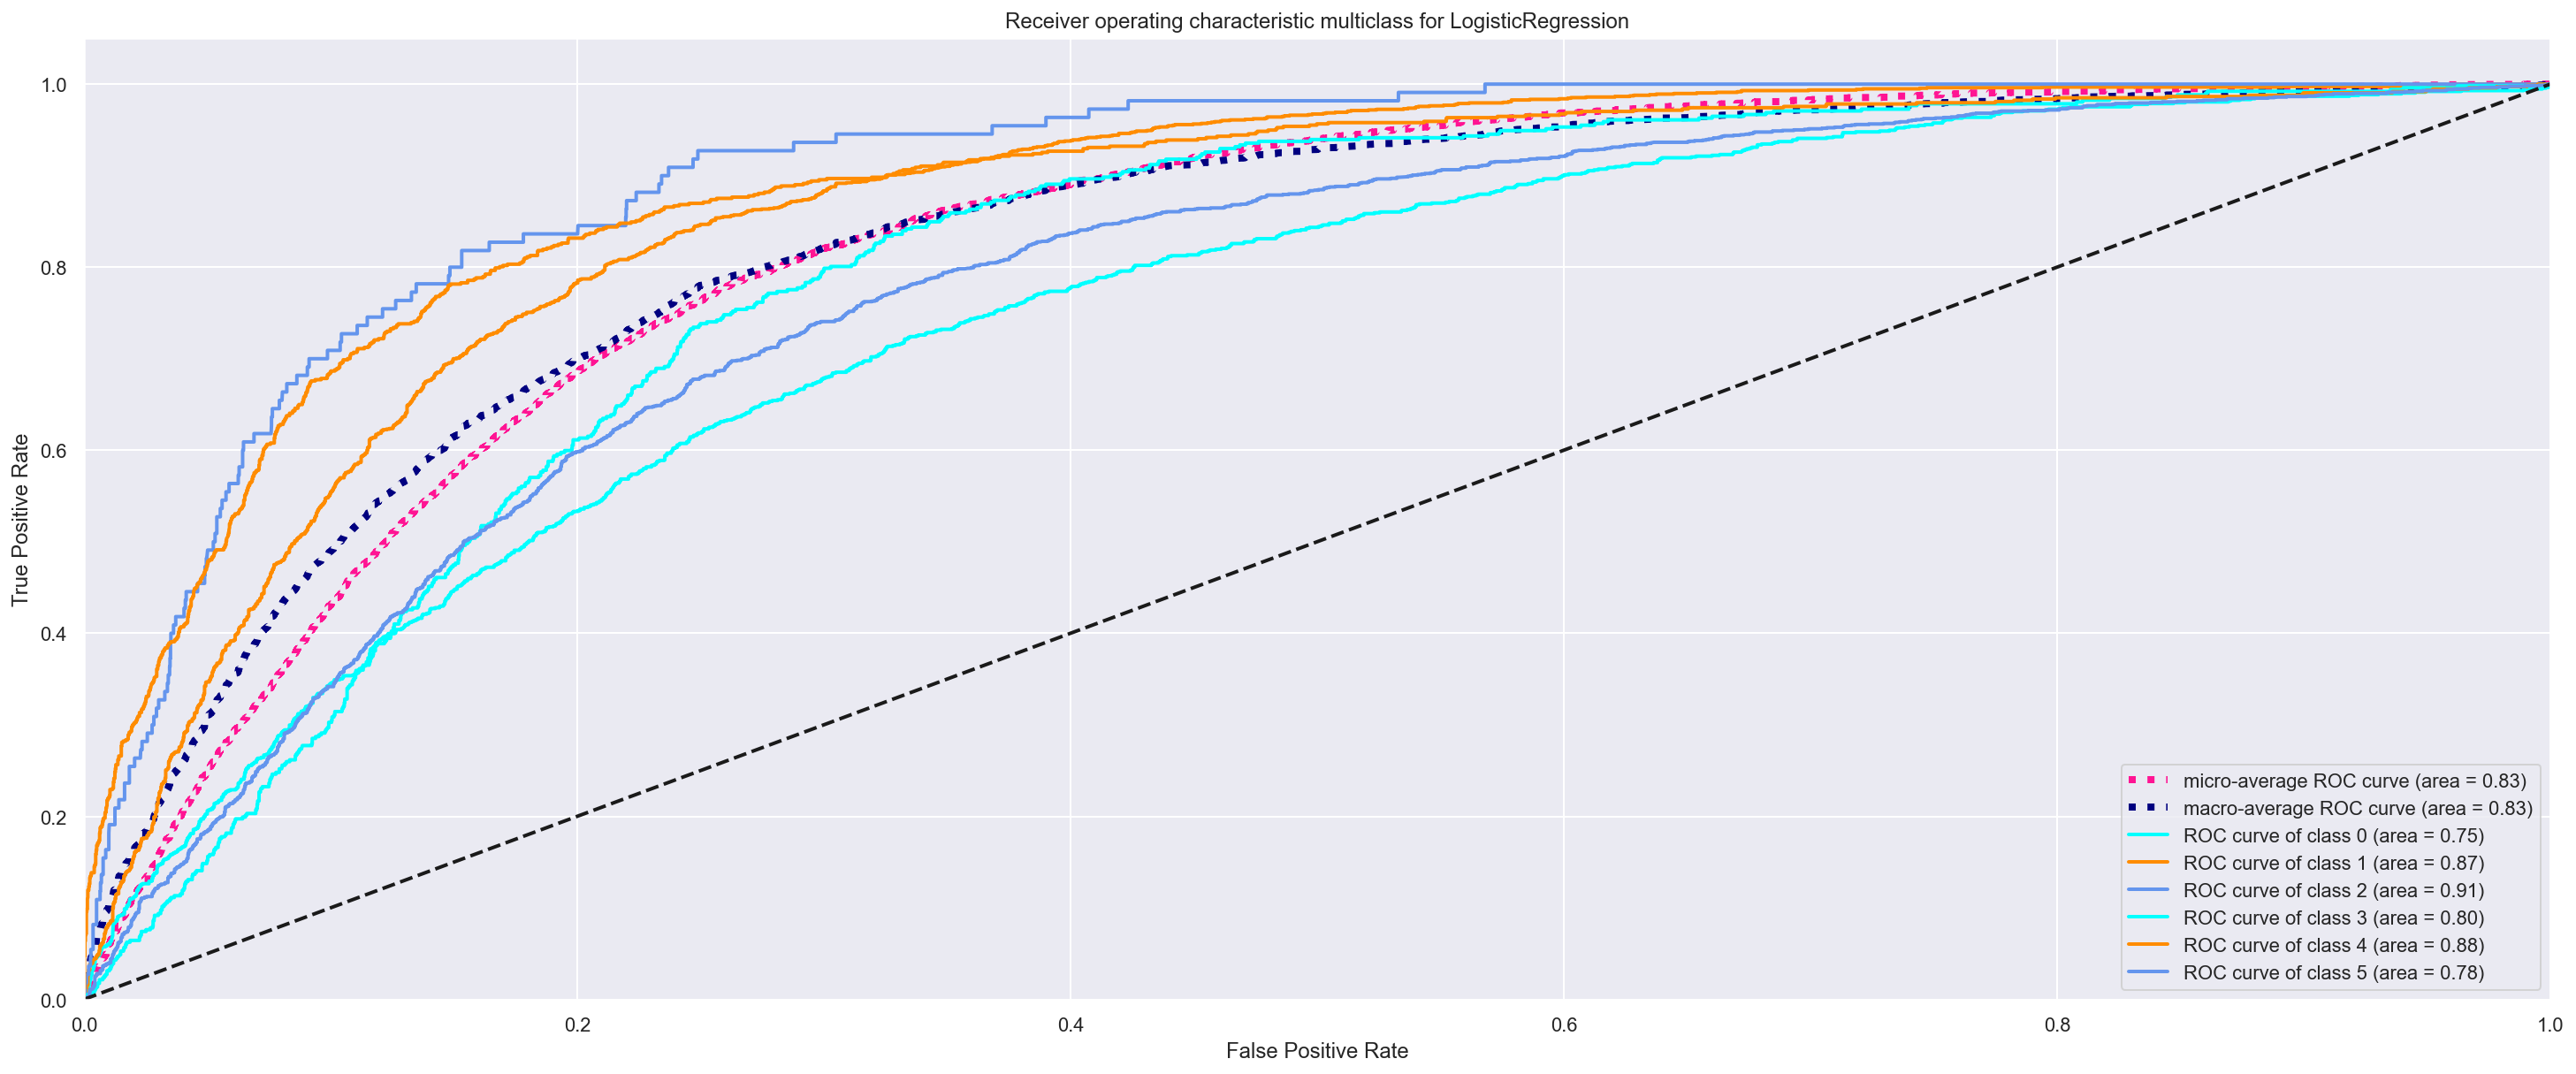

In [40]:
plot_aucroc(base_pipe_weight, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

We can see the situation improved.

### A RandomForest model

To start improving our classifier, we choose a more sofisticated model, _i.e._ the Random Forest.

The structure of the pipeline will remain the same, with some modification in order to encode the feature engineering transformers we built above.
However, endowed with such tools it becomes easy to compose a working pipeline.

To start, let's compose a new column transformer that will take care of preprocessing.
Briefly, we want to include the new features we have built (continent, sum of package, sum of nights, etc.) and operate one-hot encoding on categorical variables.

In [41]:
# RandomForest pipe

preprocessing = ColumnTransformer(transformers=[
                                ("get_continent", cont_transformer, [1]),
                                ("ord_age", OrdinalEncoder(categories=[['<18', '18-24', '25-44', '45-64', '65+']]), [2]),
                                ("ohe_travel_with", OneHotEncoder(sparse=False), [3]),
                                ("get_family", trav_transformer, [4, 5]),
                                ("ohe_purpose_activity", OneHotEncoder(sparse=False), [6, 7]),
                                ("ohe_info_source", OneHotEncoder(sparse=False), [8]),
                                ("ohe_binary", OneHotEncoder(drop="if_binary"), [9]),
                                ("package_cols", package_transformer, slice(10,17)),
                                ("number_nights", nights_transformer, [17, 18]),
                                ("scaling_nights", RobustScaler(), [17,18]),
                                ("ohe_first_trip", OneHotEncoder(drop="if_binary"), [19])
                                ])

rf_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", RandomForestClassifier(class_weight="balanced"))])

In [42]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('get_continent',
                                                  FunctionTransformer(func=<function get_continent_function at 0x285369040>),
                                                  [1]),
                                                 ('ord_age',
                                                  OrdinalEncoder(categories=[['<18',
                                                                              '18-24',
                                                                              '25-44',
                                                                              '45-64',
                                                                              '65+']]),
                                                  [2]),
                                                 ('ohe_travel_with',
                                                  OneHotEncoder(sparse=False),
                                                  [3]),
                                                 ('get_family',
                                                  FunctionTransformer(func=<function get_num_...
                                                 ('package_cols',
                                                  FunctionTransformer(func=<function get_total_package at 0x285369700>),
                                                  slice(10, 17, None)),
                                                 ('number_nights',
                                                  FunctionTransformer(func=<function get_num_nights at 0x285369670>),
                                                  [17, 18]),
                                                 ('scaling_nights',
                                                  RobustScaler(), [17, 18]),
                                                 ('ohe_first_trip',
                                                  OneHotEncoder(drop='if_binary'),
                                                  [19])])),
                ('model', RandomForestClassifier(class_weight='balanced'))])

#### Evaluation of the Random Forest

Let's start by classification report, then we plot ROC curves.

In [43]:
print(classification_report(rf_pipe.predict(X_devtest), y_devtest))

print("Random Forest model with balanced classes weighted f1-score: ", f1_score(rf_pipe.predict(X_devtest), y_devtest, average="weighted"))

              precision    recall  f1-score   support

   High Cost       0.35      0.46      0.40       869
 Higher Cost       0.75      0.63      0.69      1856
Highest Cost       0.07      0.17      0.10        48
    Low Cost       0.12      0.26      0.17       239
  Lower Cost       0.55      0.53      0.54       761
 Normal Cost       0.64      0.55      0.59      1977

    accuracy                           0.54      5750
   macro avg       0.41      0.43      0.41      5750
weighted avg       0.59      0.54      0.56      5750

Random Forest model with balanced classes weighted f1-score:  0.5632097812917415


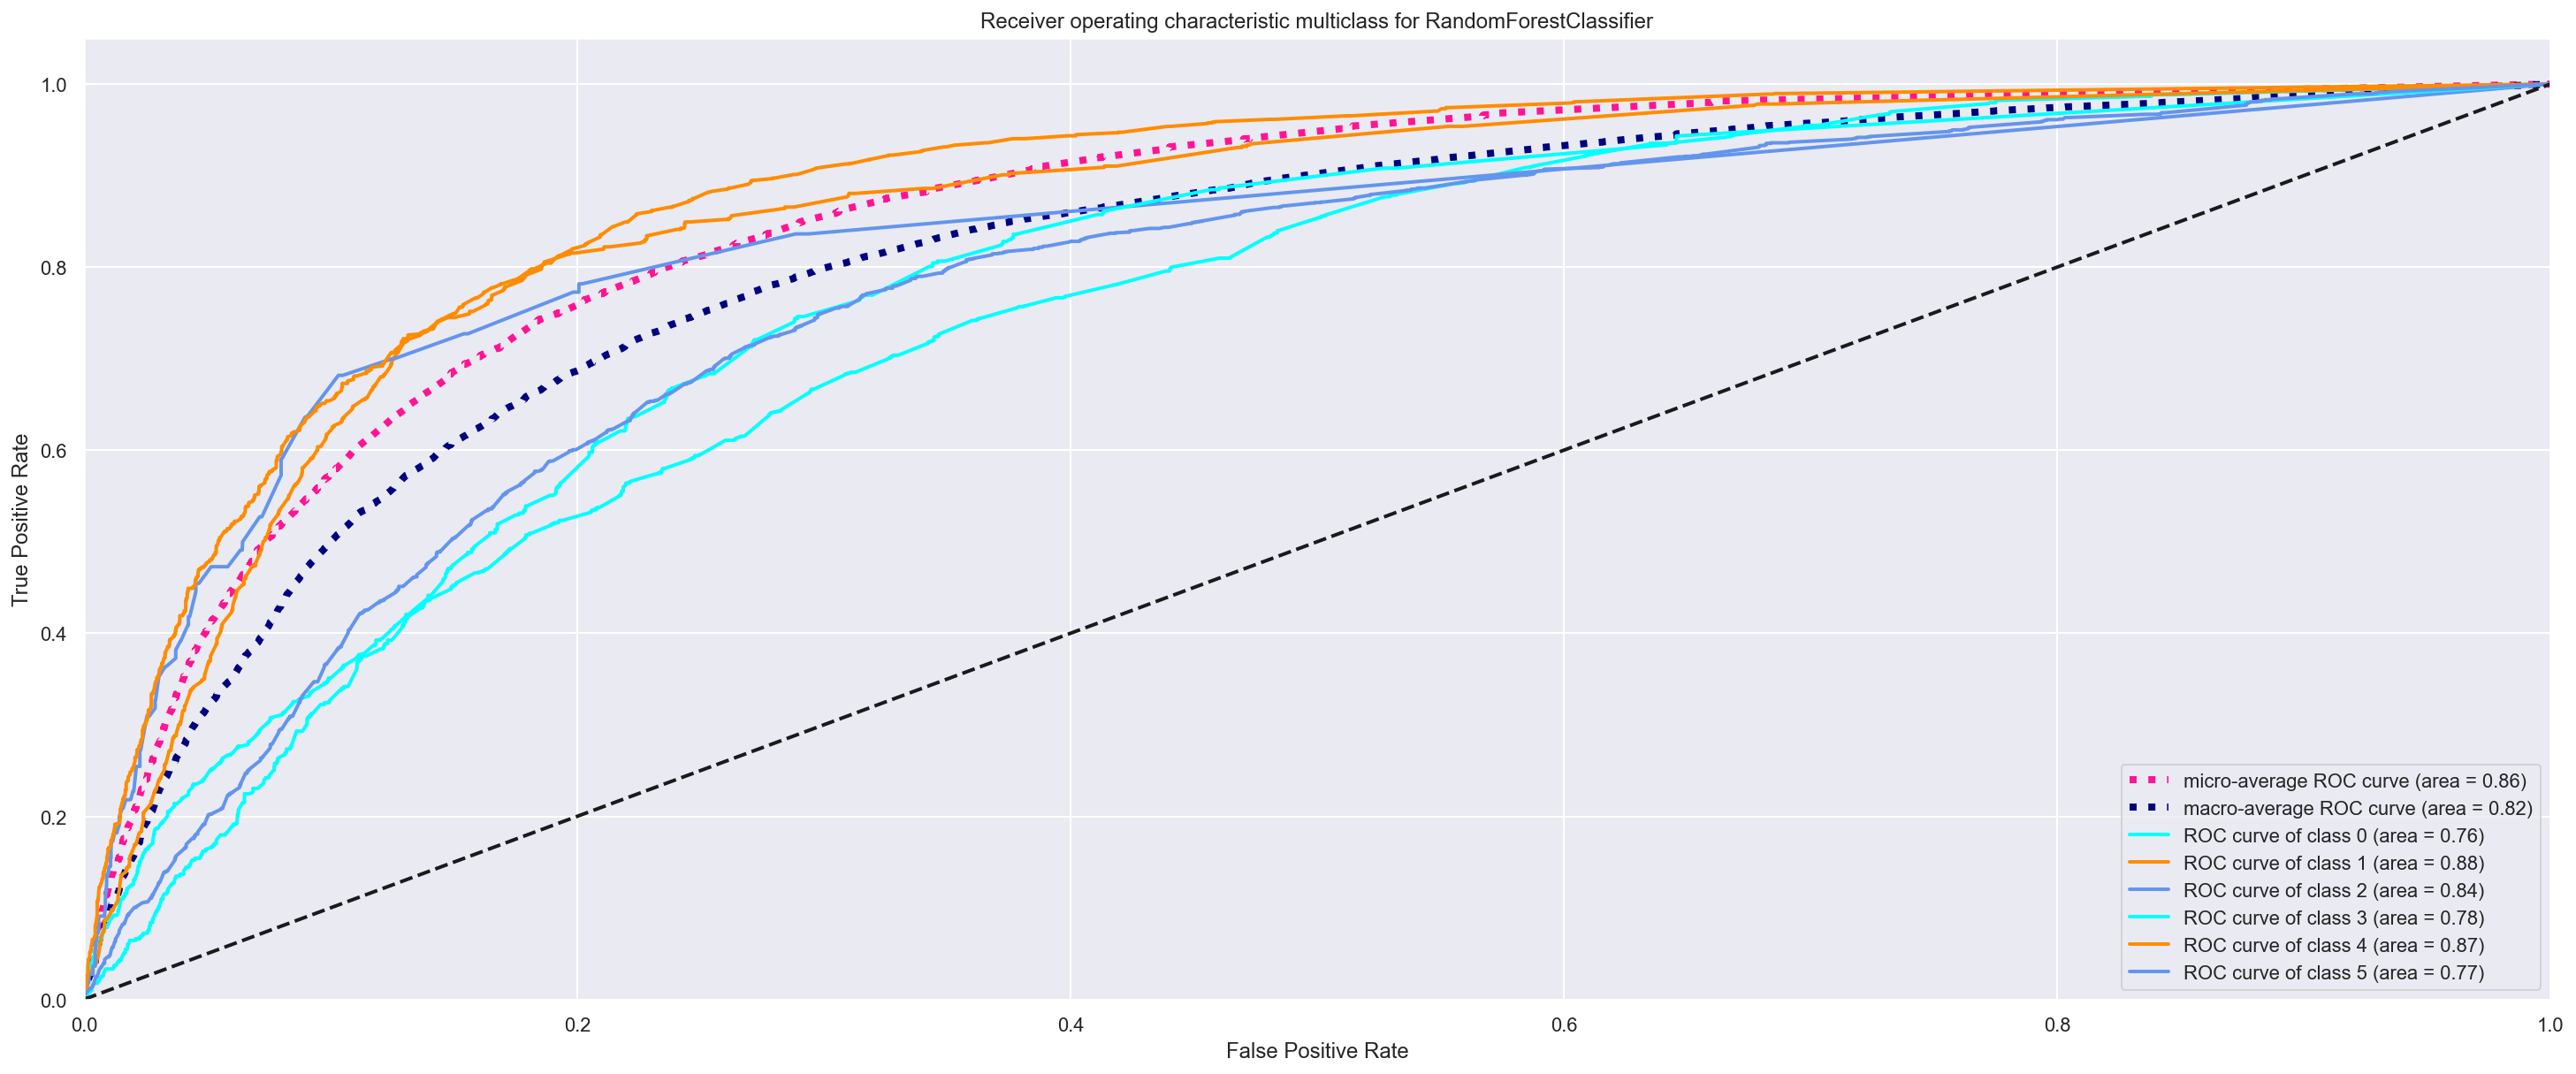

In [44]:
plot_aucroc(rf_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

Better, but we can go further.

### XGBoost

Let's try XGBoost and let's see how it goes, the preprocessing pipeline is the same as above.

In [45]:
# XGBoost pipeline

preprocessing = ColumnTransformer(transformers=[
                                ("get_continent", cont_transformer, [1]),
                                ("ord_age", OrdinalEncoder(categories=[['<18', '18-24', '25-44', '45-64', '65+']]), [2]),
                                ("ohe_travel_with", OneHotEncoder(sparse=False), [3]),
                                ("get_family", trav_transformer, [4, 5]),
                                ("ohe_purpose_activity", OneHotEncoder(sparse=False), [6, 7]),
                                ("ohe_info_source", OneHotEncoder(sparse=False), [8]),
                                ("ohe_binary", OneHotEncoder(drop="if_binary"), [9]),
                                ("package_cols", package_transformer, slice(10,17)),
                                ("number_nights", nights_transformer, [17, 18]),
                                ("scaling_nights", RobustScaler(), [17,18]),
                                ("ohe_first_trip", OneHotEncoder(drop="if_binary"), [19])
                                ])

classes_weights = compute_sample_weight(
    class_weight='balanced',
    y=y
)

xgb_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", xgb.XGBClassifier(class_weight=classes_weights))])

In [46]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
xgb_pipe.fit(X_train, y_train_encoded)

[17:31:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('get_continent',
                                                  FunctionTransformer(func=<function get_continent_function at 0x285369040>),
                                                  [1]),
                                                 ('ord_age',
                                                  OrdinalEncoder(categories=[['<18',
                                                                              '18-24',
                                                                              '25-44',
                                                                              '45-64',
                                                                              '65+']]),
                                                  [2]),
                                                 ('ohe_travel_with',
                                                  OneHotEncoder(sparse=False),
                                                  [3]),
                                                 ('get_family',
                                                  FunctionTransformer(func=<function get_num_...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

#### Evaluation of the XGBoost

As usual, let's start by classification report, then we plot ROC curves.

In [47]:
print(classification_report(xgb_pipe.predict(X_devtest), le.transform(y_devtest)))

print("XGBoost model with balanced classes weighted f1-score: ", f1_score(xgb_pipe.predict(X_devtest), le.transform(y_devtest), average="weighted"))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44       893
           1       0.77      0.65      0.70      1863
           2       0.11      0.27      0.15        45
           3       0.07      0.27      0.11       130
           4       0.59      0.53      0.56       818
           5       0.66      0.56      0.61      2001

    accuracy                           0.57      5750
   macro avg       0.43      0.46      0.43      5750
weighted avg       0.63      0.57      0.59      5750

XGBoost model with balanced classes weighted f1-score:  0.5904018717338793


[17:33:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




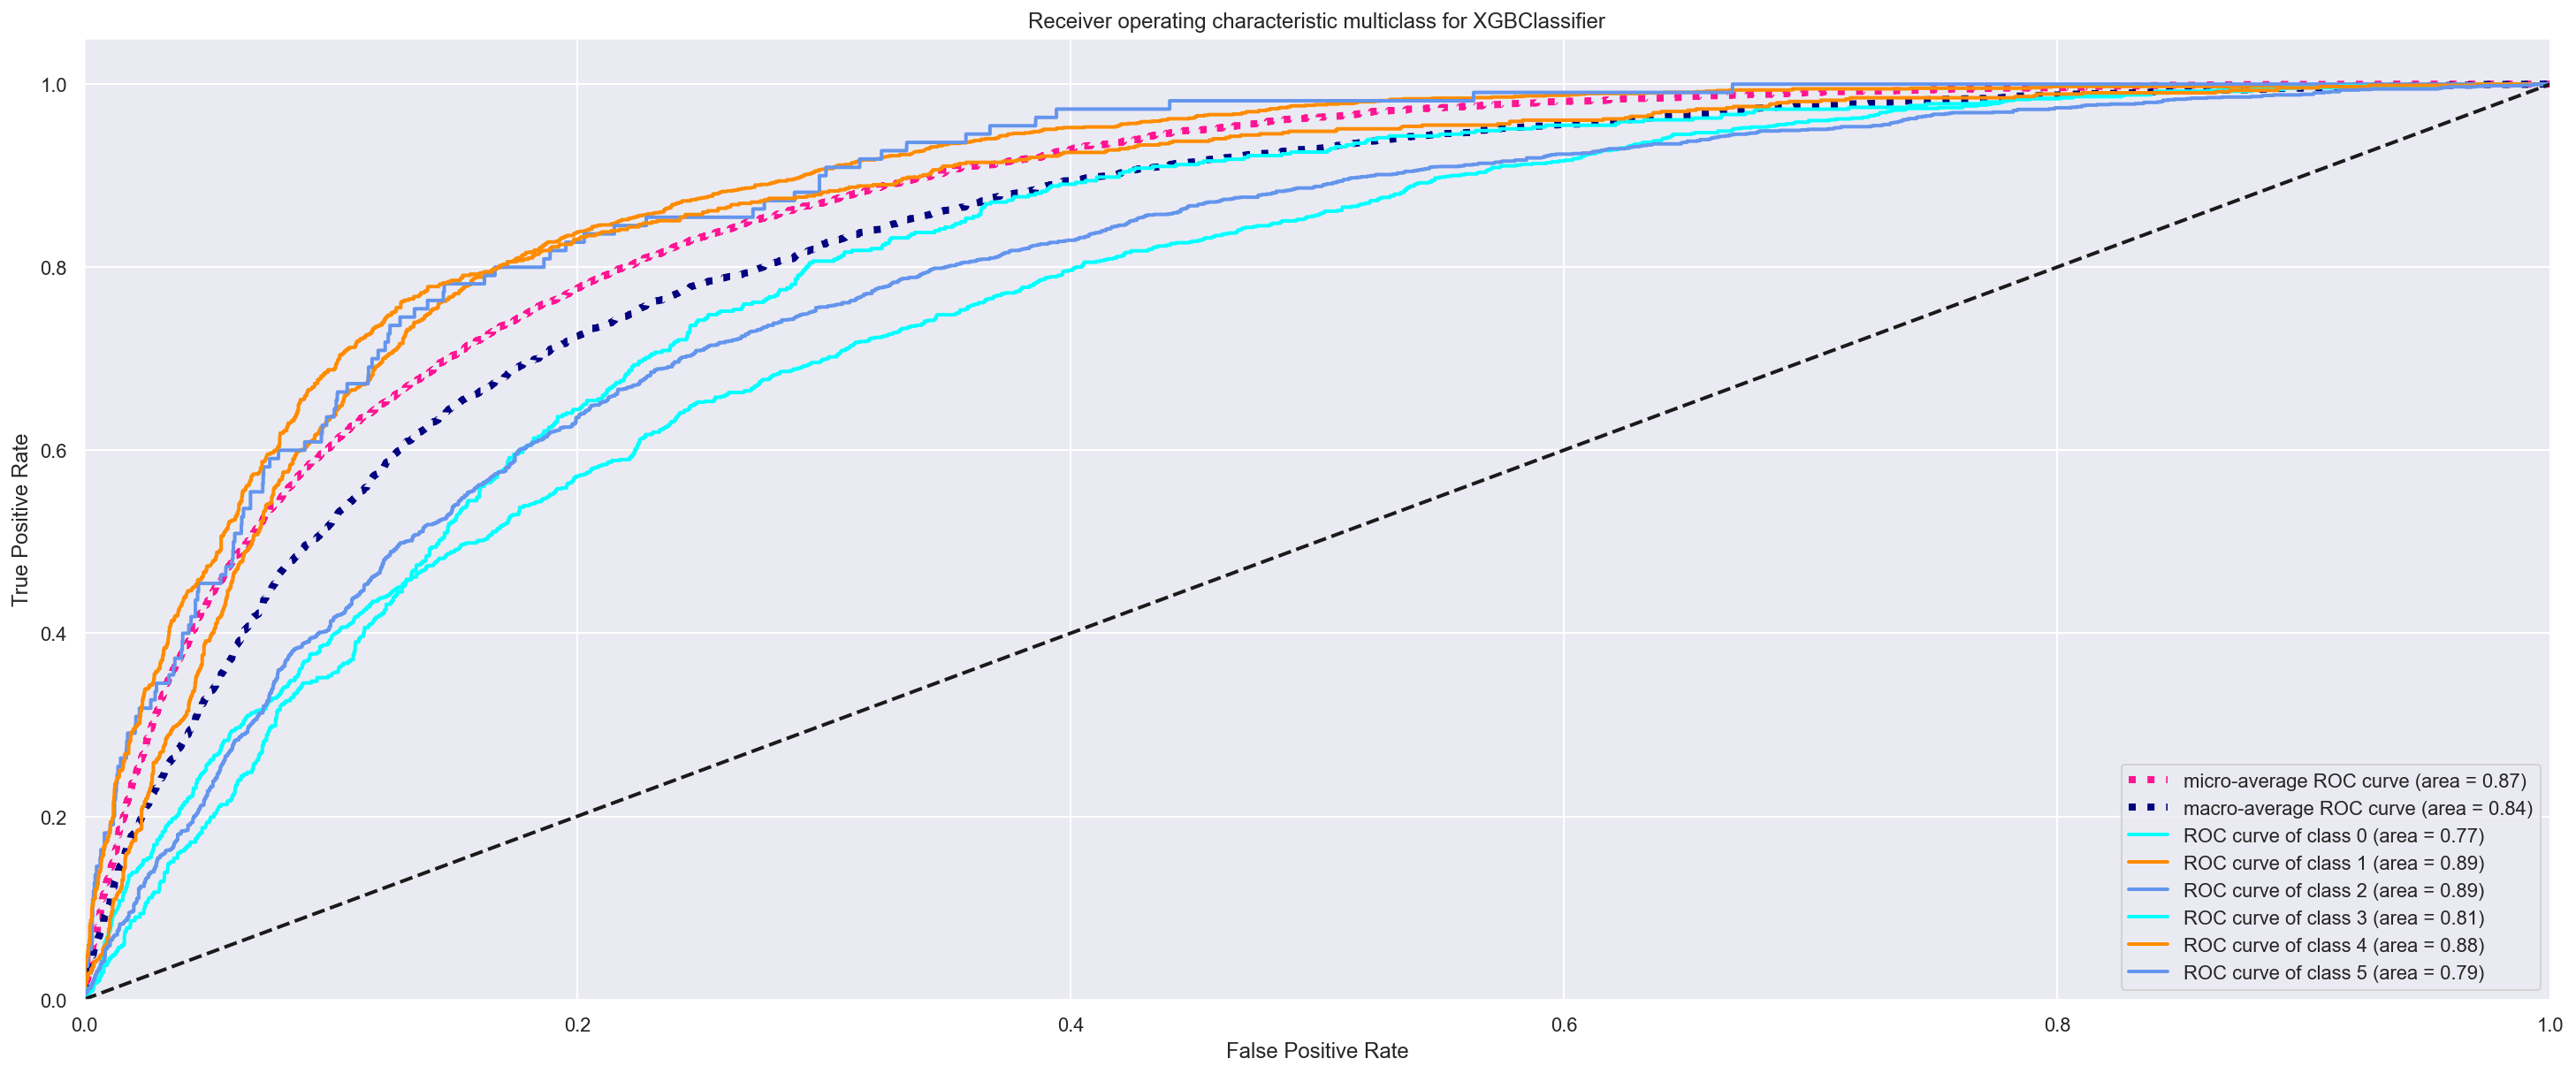

In [50]:
plot_aucroc(xgb_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

### CATBOOST

We train one last model before proceding to hyperparameter tuning.
CatBoost is an ensemble model based on boosting based on CAT trees, similar to XGBoost.

The curious reader can find more information about this model in [this nice reference](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm).

In [51]:
# XGBoost pipeline

preprocessing = ColumnTransformer(transformers=[
                                ("get_continent", cont_transformer, [1]),
                                ("ord_age", OrdinalEncoder(categories=[['<18', '18-24', '25-44', '45-64', '65+']]), [2]),
                                ("ohe_travel_with", OneHotEncoder(sparse=False), [3]),
                                ("get_family", trav_transformer, [4, 5]),
                                ("ohe_purpose_activity", OneHotEncoder(sparse=False), [6, 7]),
                                ("ohe_info_source", OneHotEncoder(sparse=False), [8]),
                                ("ohe_binary", OneHotEncoder(drop="if_binary"), [9]),
                                ("package_cols", package_transformer, slice(10,17)),
                                ("number_nights", nights_transformer, [17, 18]),
                                ("scaling_nights", RobustScaler(), [17,18]),
                                ("ohe_first_trip", OneHotEncoder(drop="if_binary"), [19])
                                ])

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
classes_weights = dict(zip(np.unique(y), weights))

cat_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", CatBoostClassifier(loss_function='MultiClass', class_weights=classes_weights))])

In [52]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
cat_pipe.fit(X_train, y_train_encoded)

Learning rate set to 0.089692
0:	learn: 1.7007759	total: 63.7ms	remaining: 1m 3s
1:	learn: 1.6353054	total: 71.1ms	remaining: 35.5s
2:	learn: 1.5784629	total: 77.8ms	remaining: 25.8s
3:	learn: 1.5327170	total: 84.4ms	remaining: 21s
4:	learn: 1.4915761	total: 91.8ms	remaining: 18.3s
5:	learn: 1.4562581	total: 98.5ms	remaining: 16.3s
6:	learn: 1.4265022	total: 105ms	remaining: 15s
7:	learn: 1.3970642	total: 112ms	remaining: 13.9s
8:	learn: 1.3718932	total: 119ms	remaining: 13.1s
9:	learn: 1.3501451	total: 126ms	remaining: 12.5s
10:	learn: 1.3320509	total: 132ms	remaining: 11.9s
11:	learn: 1.3156037	total: 140ms	remaining: 11.5s
12:	learn: 1.3006177	total: 147ms	remaining: 11.1s
13:	learn: 1.2867646	total: 156ms	remaining: 11s
14:	learn: 1.2744729	total: 163ms	remaining: 10.7s
15:	learn: 1.2628327	total: 171ms	remaining: 10.5s
16:	learn: 1.2536192	total: 177ms	remaining: 10.3s
17:	learn: 1.2420358	total: 184ms	remaining: 10s
18:	learn: 1.2322131	total: 190ms	remaining: 9.83s
19:	learn: 1.

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('get_continent',
                                                  FunctionTransformer(func=<function get_continent_function at 0x285369040>),
                                                  [1]),
                                                 ('ord_age',
                                                  OrdinalEncoder(categories=[['<18',
                                                                              '18-24',
                                                                              '25-44',
                                                                              '45-64',
                                                                              '65+']]),
                                                  [2]),
                                                 ('ohe_travel_with',
                                                  OneHotEncoder(sparse=False),
                                                  [3]),
                                                 ('get_family',
                                                  FunctionTransformer(func=<function get_num_...
                                                 ('package_cols',
                                                  FunctionTransformer(func=<function get_total_package at 0x285369700>),
                                                  slice(10, 17, None)),
                                                 ('number_nights',
                                                  FunctionTransformer(func=<function get_num_nights at 0x285369670>),
                                                  [17, 18]),
                                                 ('scaling_nights',
                                                  RobustScaler(), [17, 18]),
                                                 ('ohe_first_trip',
                                                  OneHotEncoder(drop='if_binary'),
                                                  [19])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x2b36598b0>)])

### Evaluation of the CATBoost

As usual, let's start by classification report, then we plot ROC curves.

In [53]:
print(classification_report(cat_pipe.predict(X_devtest), le.transform(y_devtest)))

print("CATBOOST model with balanced classes weighted f1-score: ", f1_score(cat_pipe.predict(X_devtest), le.transform(y_devtest), average="weighted"))

              precision    recall  f1-score   support

           0       0.46      0.47      0.46      1101
           1       0.67      0.67      0.67      1567
           2       0.38      0.18      0.24       236
           3       0.31      0.24      0.27       646
           4       0.56      0.51      0.53       811
           5       0.49      0.60      0.54      1389

    accuracy                           0.52      5750
   macro avg       0.48      0.44      0.45      5750
weighted avg       0.52      0.52      0.52      5750

CATBOOST model with balanced classes weighted f1-score:  0.5163501291272296


Learning rate set to 0.089692
0:	learn: 1.7007759	total: 7.5ms	remaining: 7.49s
1:	learn: 1.6353054	total: 16.1ms	remaining: 8.05s
2:	learn: 1.5784629	total: 24.6ms	remaining: 8.18s
3:	learn: 1.5327170	total: 31.9ms	remaining: 7.94s
4:	learn: 1.4915761	total: 44ms	remaining: 8.75s
5:	learn: 1.4562581	total: 50.8ms	remaining: 8.42s
6:	learn: 1.4265022	total: 58.8ms	remaining: 8.33s
7:	learn: 1.3970642	total: 66.5ms	remaining: 8.24s
8:	learn: 1.3718932	total: 74.1ms	remaining: 8.16s
9:	learn: 1.3501451	total: 81.2ms	remaining: 8.04s
10:	learn: 1.3320509	total: 87.6ms	remaining: 7.88s
11:	learn: 1.3156037	total: 94.6ms	remaining: 7.79s
12:	learn: 1.3006177	total: 102ms	remaining: 7.72s
13:	learn: 1.2867646	total: 109ms	remaining: 7.66s
14:	learn: 1.2744729	total: 115ms	remaining: 7.55s
15:	learn: 1.2628327	total: 122ms	remaining: 7.49s
16:	learn: 1.2536192	total: 128ms	remaining: 7.42s
17:	learn: 1.2420358	total: 135ms	remaining: 7.37s
18:	learn: 1.2322131	total: 142ms	remaining: 7.33s
19

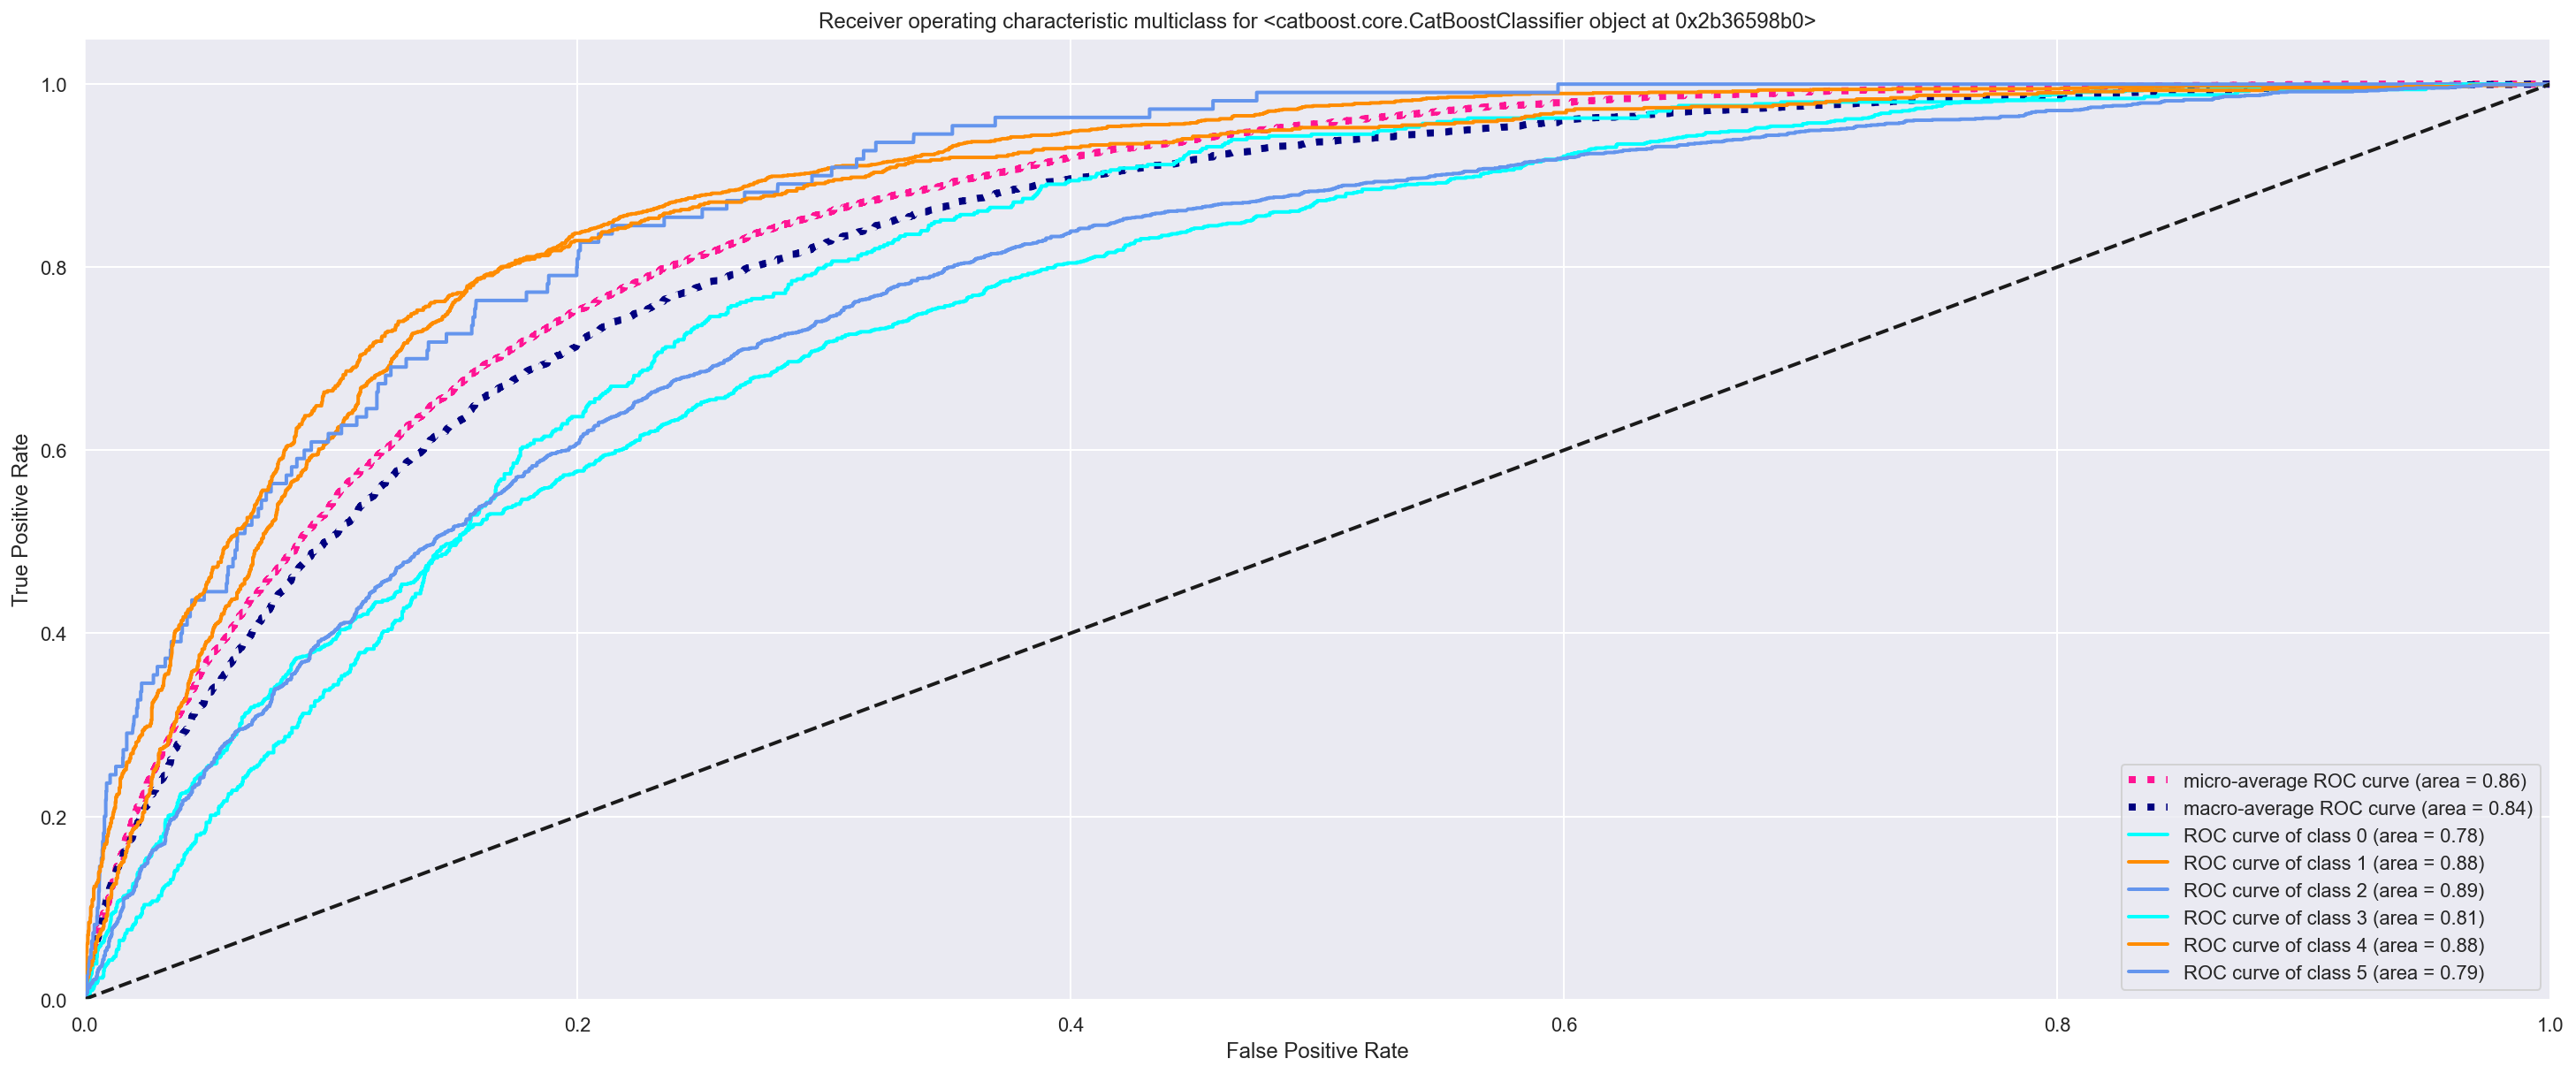

In [56]:
plot_aucroc(cat_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

## HyperParameter tuning

Our strategy is to perform hyperparameter tuning on the two best models and then create an ensemble model of the two.

Now, we need to choose the two best models above (they are unsurprisingly these are CATBOOST and XGBOOST) to tune their hyperparameters.
We start by XGBoost, then we move forward to CATBOOST.
The technique chose is RandomSearch for numerical and efficiency reasons.

### XGBoost RandomSearch

Here we proceed with RandomSearch to explore the XGBoost hyperparameter space.

A nice guide a courious reader might find useful is [here](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook).

In [85]:
# Hyperparameter space grid
classes_weights = compute_sample_weight(
    class_weight='balanced',
    y=y
)

param_grid = {
    "classes_weight": classes_weights,
    "booster": ["gbtree", "gblinear"],
    "max_depth": [3, 4, 5, 7, 8, 9, 10, 11],
    "learning_rate": [0.2, 0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 0.5, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.4, 0.5, 0.7, 0.8],
} # Hyperparameter space grid

In [86]:
# Careful: This might take a while.

# Init Classifier
xgb_clf = xgb.XGBClassifier(classes_weight=classes_weights)

# Init Random Search
rnd_cv = RandomizedSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=5, scoring="f1_weighted")

# Fit
X_train_pr = xgb_pipe.named_steps["preprocessing"].fit_transform(X_train)
_ = rnd_cv.fit(X_train_pr, le.fit_transform(y_train))

[17:44:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "classes_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:44:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "classes_weight", "colsample_bytree", "gamma", "max_depth", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:44:06] WARNING: /Users/runner/work/

In [87]:
rnd_cv.best_params_

{'subsample': 0.6,
 'reg_lambda': 0,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.4,
 'classes_weight': 0.5695234359678368,
 'booster': 'gbtree'}

In [88]:
rnd_cv.best_score_

0.5386858283016422

In [89]:
best_xgb = rnd_cv.best_estimator_

In [90]:
best_xgb_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", best_xgb)])
best_xgb_pipe.fit(X_train, le.fit_transform(y_train))

print(classification_report(best_xgb_pipe.predict(X_devtest), le.transform(y_devtest)))

print("Tuned XGBOOST model with balanced classes weighted f1-score: ", f1_score(best_xgb_pipe.predict(X_devtest), le.transform(y_devtest), average="weighted"))

[17:44:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "classes_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

           0       0.31      0.52      0.39       663
           1       0.81      0.63      0.71      1993
           2       0.05      0.31      0.08        16
           3       0.01      0.50      0.03        14
           4       0.64      0.57      0.60       824
           5       0.72      0.54      0.62      2240

    accuracy                           0.57      5750
   macro avg       0.42      0.51      0.40      5750
weighted avg       0.69      0.57      0.62      5750

Tune

[17:44:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "classes_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




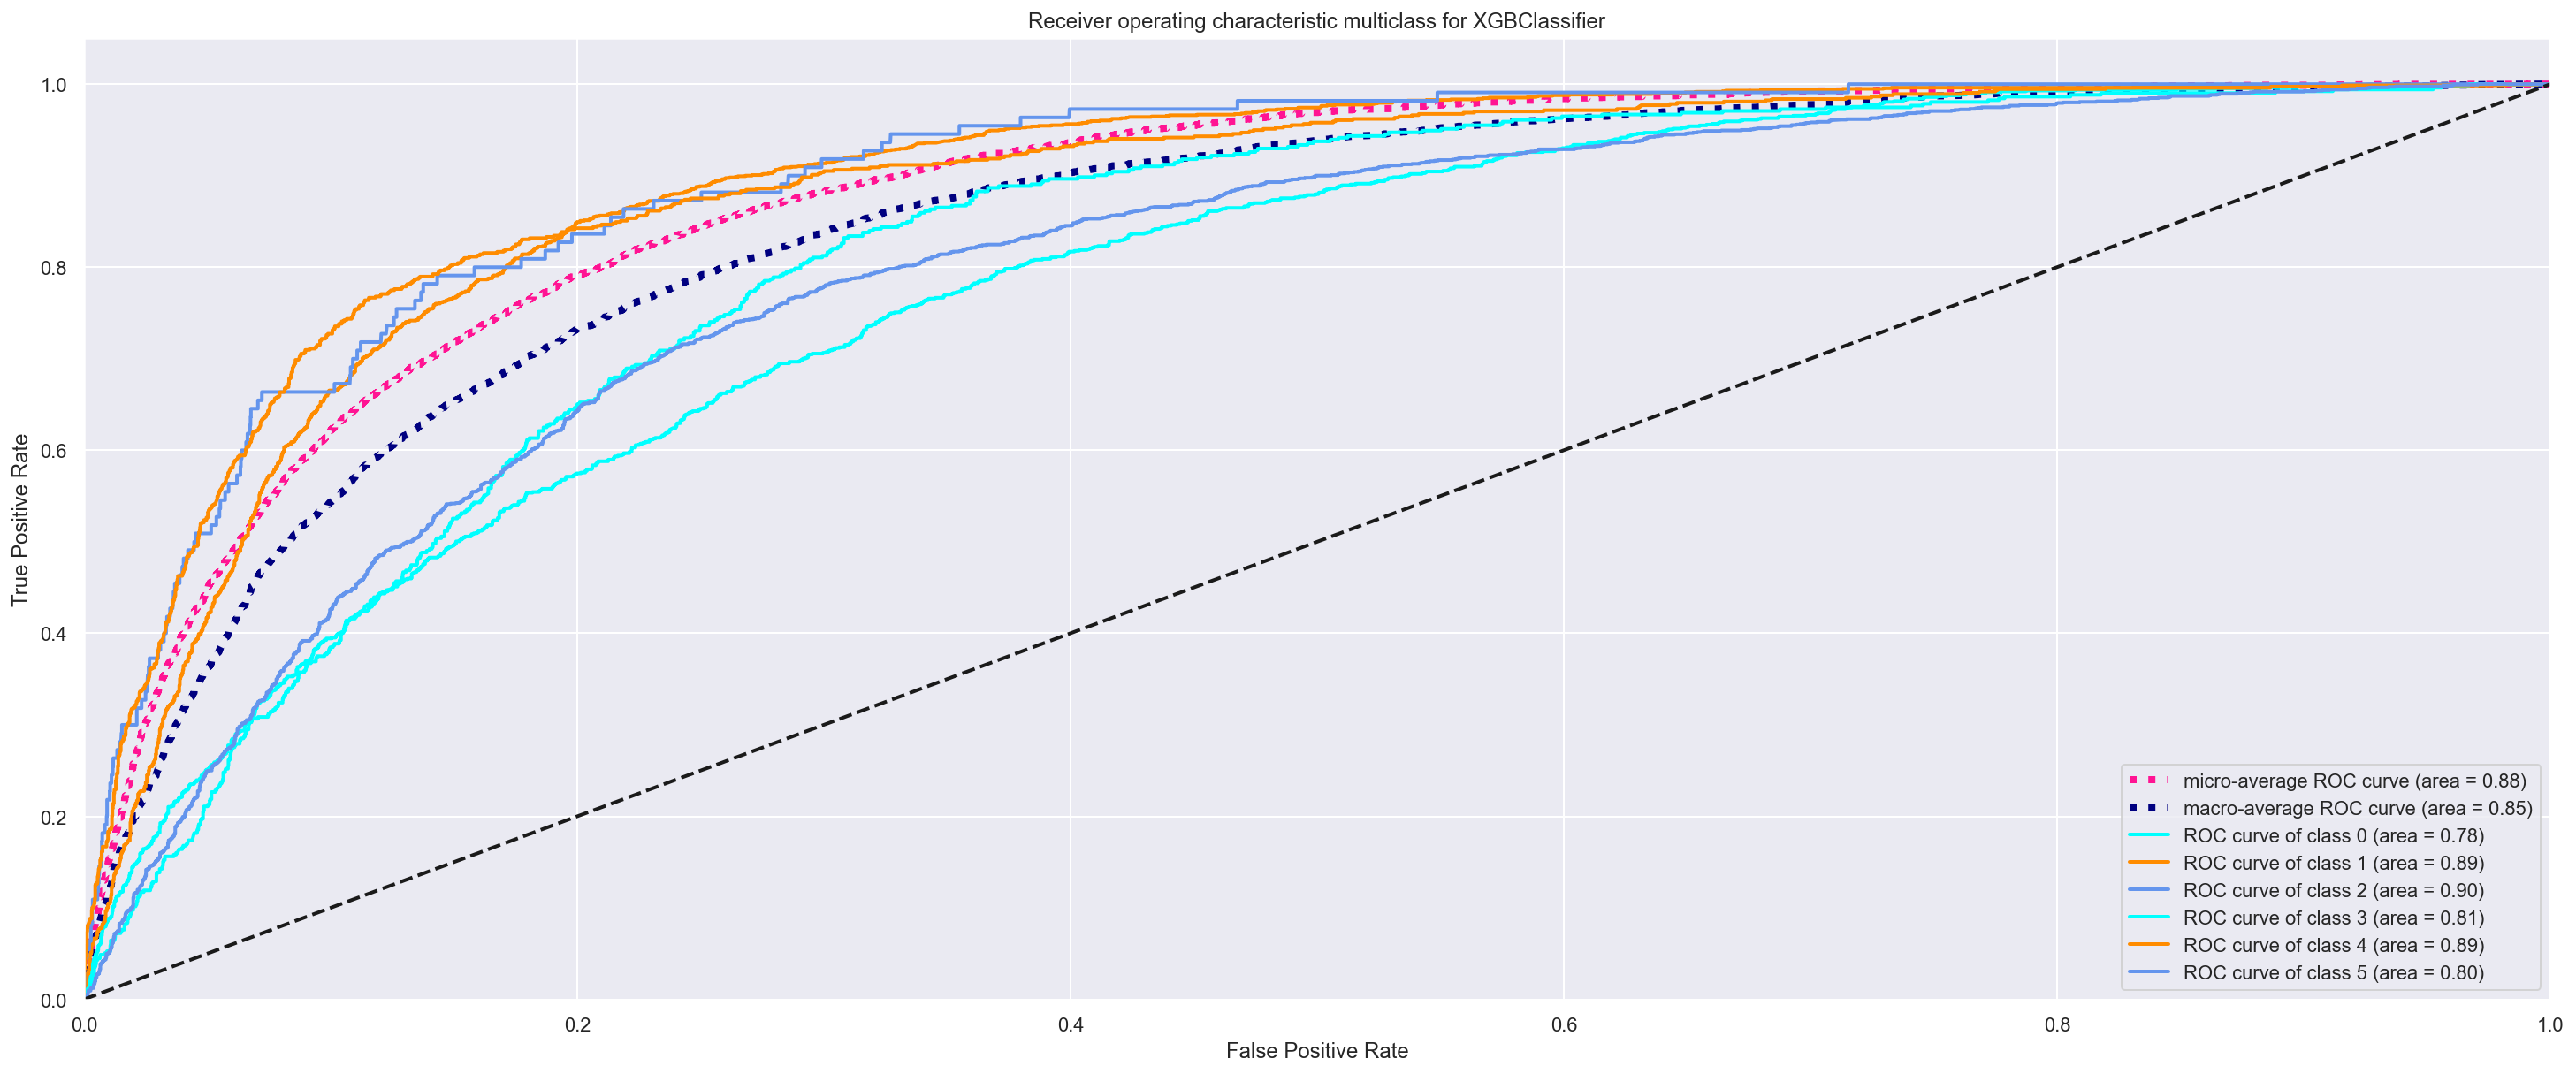

In [91]:
plot_aucroc(best_xgb_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

### CATBOOST RandomSearch

Here we proceed with RandomSearch to explore the CATBoost hyperparameter space.

In [66]:
# Hyperparameter space grid
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
classes_weights = dict(zip(np.unique(y), weights))

param_grid = {
    "class_weights": [classes_weights],
    "depth": [3, 4, 5, 7, 8, 9, 10, 11],
    "learning_rate": [0.2, 0.1, 0.01, 0.03, 0.05],
    "iterations": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "l2_leaf_reg": [0, 0.25, 0.5, 1],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "bootstrap_type": ["MVS"] # Use "Poisson" on GPU
} # Hyperparameter space grid

In [67]:
# Careful: This might take a while.

# Init Classifier
cat_clf = CatBoostClassifier(loss_function="MultiClass")

# Init Random Search
rnd_cv = RandomizedSearchCV(cat_clf, param_grid, n_jobs=-1, cv=5, scoring="f1_weighted")

# Fit
X_train_pr = cat_pipe.named_steps["preprocessing"].fit_transform(X_train)
_ = rnd_cv.fit(X_train_pr, le.fit_transform(y_train))

0:	learn: 1.7511478	total: 64.7ms	remaining: 4.46s
0:	learn: 1.7504266	total: 65ms	remaining: 4.48s
1:	learn: 1.7086460	total: 69.4ms	remaining: 2.36s
1:	learn: 1.7069914	total: 74.5ms	remaining: 2.53s
0:	learn: 1.7506039	total: 63.2ms	remaining: 4.36s
0:	learn: 1.7507923	total: 63.6ms	remaining: 4.39s
0:	learn: 1.7513292	total: 64.2ms	remaining: 4.43s
2:	learn: 1.6728557	total: 77.8ms	remaining: 1.74s
3:	learn: 1.6445177	total: 84.1ms	remaining: 1.39s
1:	learn: 1.7085163	total: 70.8ms	remaining: 2.41s
2:	learn: 1.6679124	total: 86.3ms	remaining: 1.93s
4:	learn: 1.6143149	total: 90ms	remaining: 1.17s
1:	learn: 1.7074961	total: 77.3ms	remaining: 2.63s
2:	learn: 1.6727562	total: 78.3ms	remaining: 1.75s
1:	learn: 1.7078048	total: 82.3ms	remaining: 2.8s
5:	learn: 1.5872066	total: 97.1ms	remaining: 1.04s
2:	learn: 1.6695904	total: 83.8ms	remaining: 1.87s
6:	learn: 1.5621524	total: 103ms	remaining: 928ms
2:	learn: 1.6718272	total: 90.3ms	remaining: 2.02s
3:	learn: 1.6451294	total: 92ms	remai

/Users/oscardefelice/miniconda3/envs/lectures/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


38:	learn: 1.4648873	total: 4.75s	remaining: 1.34s
37:	learn: 1.4678739	total: 4.9s	remaining: 1.55s
38:	learn: 1.4682119	total: 5.13s	remaining: 1.45s
49:	learn: 1.3691065	total: 8.81s	remaining: 0us
46:	learn: 1.3772884	total: 8.75s	remaining: 559ms
36:	learn: 1.4743088	total: 4.79s	remaining: 1.68s
39:	learn: 1.4592558	total: 4.84s	remaining: 1.21s
36:	learn: 1.4748269	total: 4.66s	remaining: 1.64s
38:	learn: 1.4622403	total: 5s	remaining: 1.41s
39:	learn: 1.4622055	total: 5.23s	remaining: 1.31s
37:	learn: 1.4681684	total: 4.89s	remaining: 1.54s
40:	learn: 1.4540447	total: 4.92s	remaining: 1.08s
39:	learn: 1.4565579	total: 5.08s	remaining: 1.27s
41:	learn: 1.4502485	total: 4.93s	remaining: 940ms
37:	learn: 1.4685314	total: 4.76s	remaining: 1.5s
40:	learn: 1.4569770	total: 5.31s	remaining: 1.17s
41:	learn: 1.4532139	total: 5.33s	remaining: 1.01s
47:	learn: 1.3725673	total: 8.92s	remaining: 372ms
38:	learn: 1.4626580	total: 4.97s	remaining: 1.4s
42:	learn: 1.4442619	total: 5.02s	remai

In [68]:
rnd_cv.best_params_

{'subsample': 0.9,
 'learning_rate': 0.2,
 'l2_leaf_reg': 0,
 'iterations': 90,
 'depth': 7,
 'class_weights': {0: 0.8214992927864215,
  1: 0.6077856843867727,
  2: 8.273504273504274,
  3: 2.033613445378151,
  4: 1.3004926108374384,
  5: 0.5695234359678368},
 'bootstrap_type': 'MVS'}

In [69]:
rnd_cv.best_score_

0.5272267138433001

In [70]:
best_cat = rnd_cv.best_estimator_

In [71]:
best_cat_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", best_cat)])
best_cat_pipe.fit(X_train, le.fit_transform(y_train))

print(classification_report(best_cat_pipe.predict(X_devtest), le.transform(y_devtest)))

print("Tuned CATBOOST model with balanced classes weighted f1-score: ", f1_score(best_cat_pipe.predict(X_devtest), le.transform(y_devtest), average="weighted"))

0:	learn: 1.5807221	total: 10.2ms	remaining: 911ms
1:	learn: 1.4632165	total: 20.8ms	remaining: 913ms
2:	learn: 1.3842364	total: 31ms	remaining: 900ms
3:	learn: 1.3251147	total: 41.7ms	remaining: 897ms
4:	learn: 1.2769205	total: 52.9ms	remaining: 900ms
5:	learn: 1.2398534	total: 64.3ms	remaining: 900ms
6:	learn: 1.2087648	total: 74.8ms	remaining: 888ms
7:	learn: 1.1840448	total: 85.4ms	remaining: 875ms
8:	learn: 1.1601991	total: 95.5ms	remaining: 860ms
9:	learn: 1.1425522	total: 106ms	remaining: 850ms
10:	learn: 1.1255224	total: 117ms	remaining: 839ms
11:	learn: 1.1123972	total: 129ms	remaining: 839ms
12:	learn: 1.1033114	total: 140ms	remaining: 829ms
13:	learn: 1.0876101	total: 151ms	remaining: 820ms
14:	learn: 1.0770596	total: 162ms	remaining: 811ms
15:	learn: 1.0657883	total: 173ms	remaining: 800ms
16:	learn: 1.0593326	total: 184ms	remaining: 791ms
17:	learn: 1.0528610	total: 195ms	remaining: 779ms
18:	learn: 1.0485036	total: 206ms	remaining: 770ms
19:	learn: 1.0399966	total: 217ms	

0:	learn: 1.5807221	total: 11.9ms	remaining: 1.06s
1:	learn: 1.4632165	total: 22.7ms	remaining: 998ms
2:	learn: 1.3842364	total: 33.7ms	remaining: 977ms
3:	learn: 1.3251147	total: 45.5ms	remaining: 979ms
4:	learn: 1.2769205	total: 56.7ms	remaining: 964ms
5:	learn: 1.2398534	total: 67.7ms	remaining: 948ms
6:	learn: 1.2087648	total: 79ms	remaining: 937ms
7:	learn: 1.1840448	total: 90ms	remaining: 923ms
8:	learn: 1.1601991	total: 101ms	remaining: 905ms
9:	learn: 1.1425522	total: 112ms	remaining: 893ms
10:	learn: 1.1255224	total: 122ms	remaining: 879ms
11:	learn: 1.1123972	total: 134ms	remaining: 869ms
12:	learn: 1.1033114	total: 145ms	remaining: 858ms
13:	learn: 1.0876101	total: 155ms	remaining: 843ms
14:	learn: 1.0770596	total: 166ms	remaining: 832ms
15:	learn: 1.0657883	total: 178ms	remaining: 822ms
16:	learn: 1.0593326	total: 189ms	remaining: 810ms
17:	learn: 1.0528610	total: 199ms	remaining: 796ms
18:	learn: 1.0485036	total: 210ms	remaining: 785ms
19:	learn: 1.0399966	total: 221ms	rem

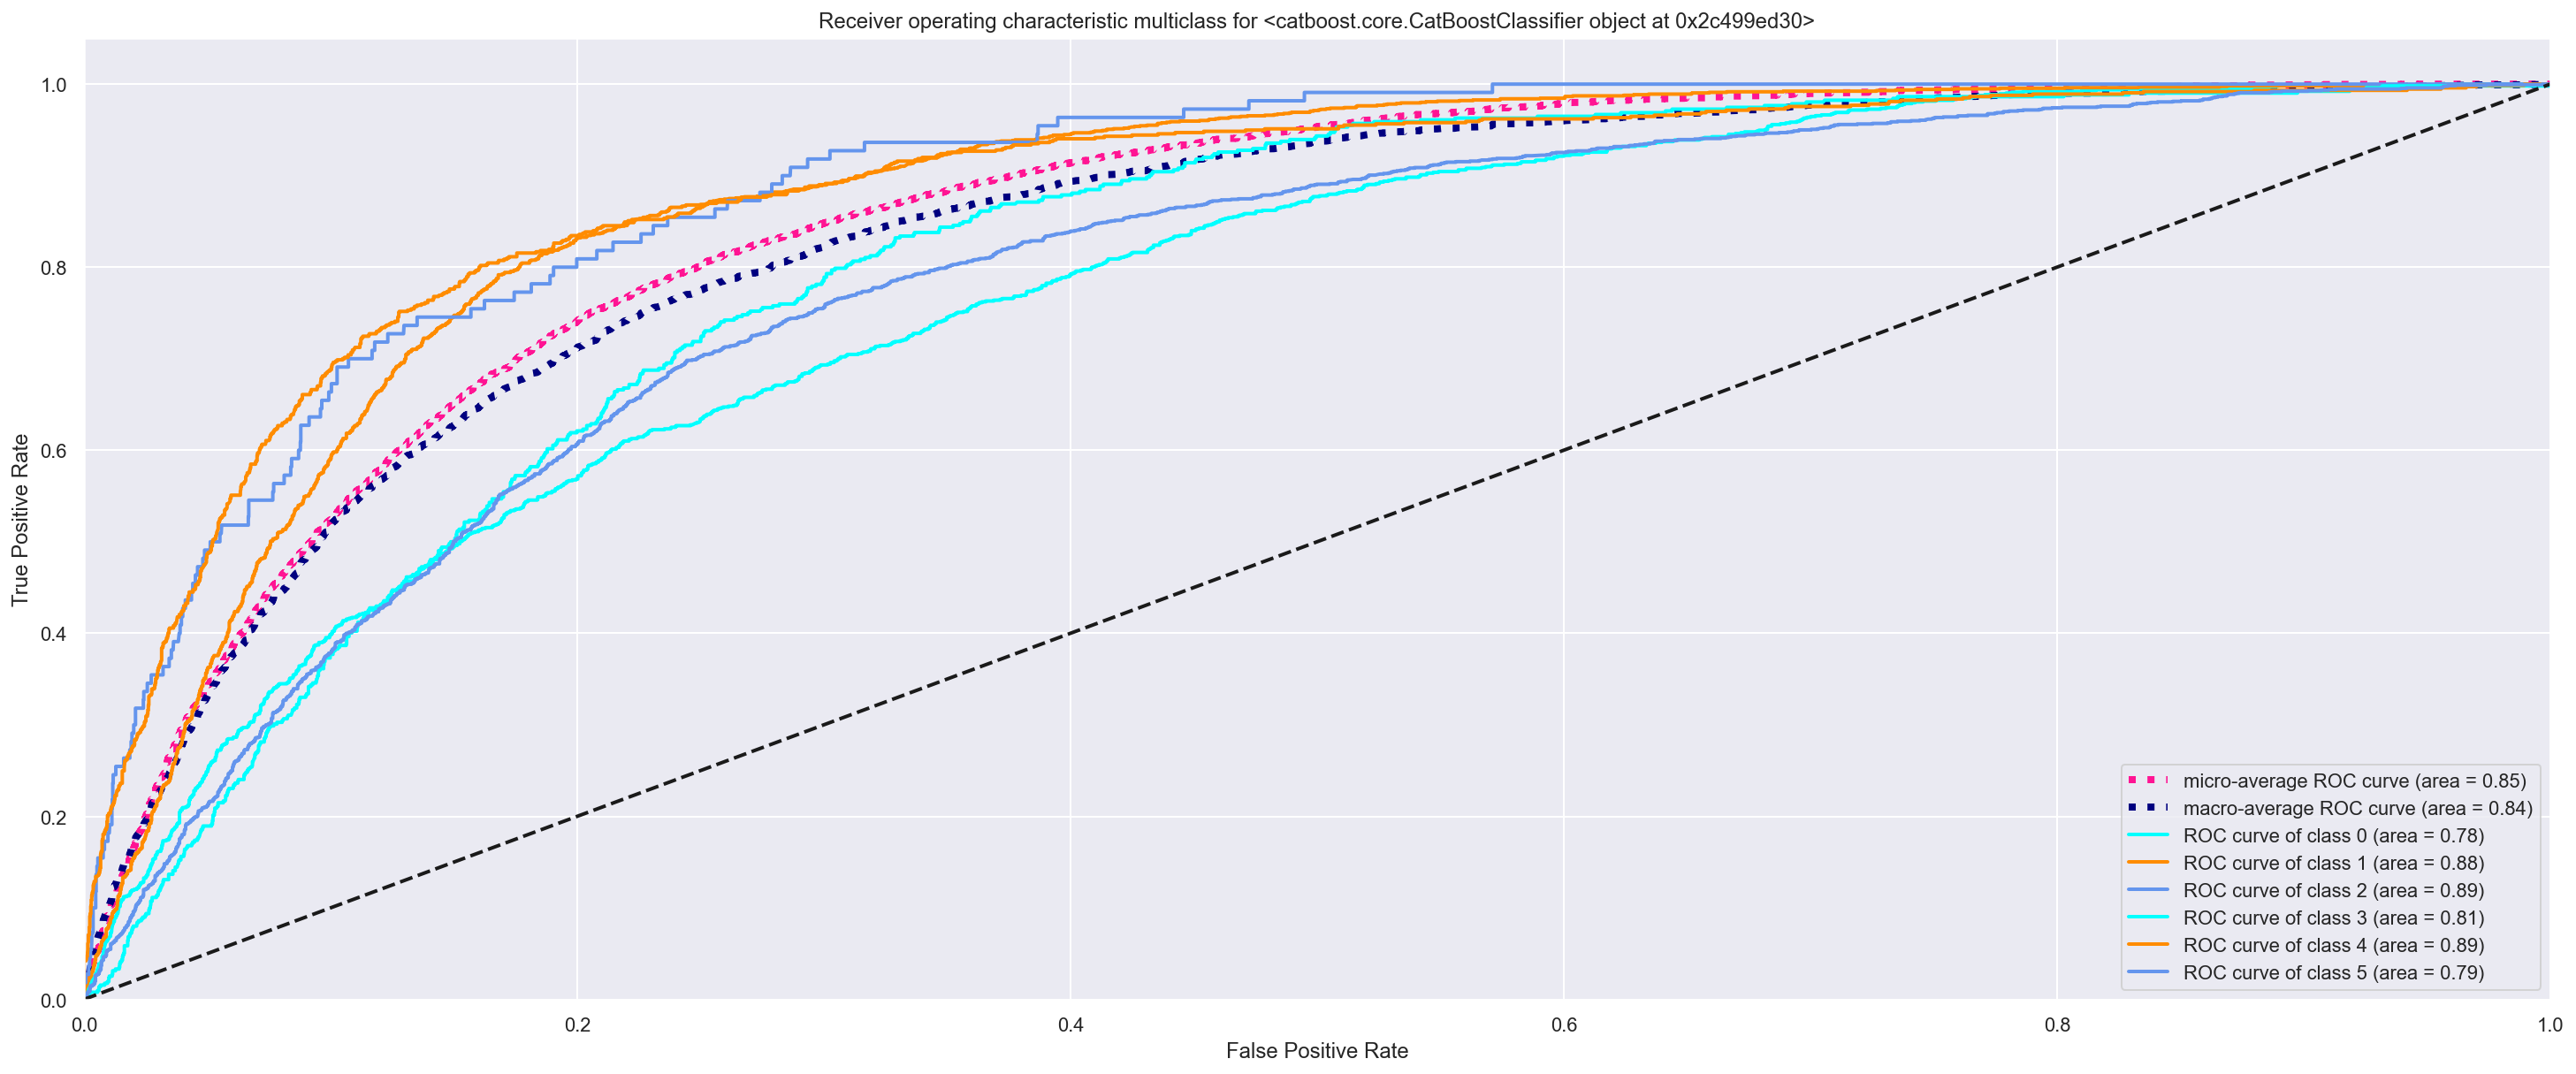

In [72]:
plot_aucroc(best_cat_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

### Bonus: RandomForest

We want to add a third model to have a well calibrated model later.

So we perform RandomSearch for Random Forest.

In [73]:
# Hyperparameter space grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
} 

In [74]:
# Careful: This might take a while.

# Init Classifier
rf_clf = RandomForestClassifier()

# Init Random Search
rnd_cv = RandomizedSearchCV(rf_clf, param_grid, n_jobs=-1, cv=7, scoring="f1_weighted")

# Fit
X_train_pr = rf_pipe.named_steps["preprocessing"].fit_transform(X_train)
_ = rnd_cv.fit(X_train_pr, le.fit_transform(y_train))

/Users/oscardefelice/miniconda3/envs/lectures/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [75]:
rnd_cv.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 110,
 'bootstrap': False}

In [76]:
rnd_cv.best_score_

0.5518840980273059

In [77]:
best_rf = rnd_cv.best_estimator_

In [78]:
best_rf_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", best_rf)])
best_rf_pipe.fit(X_train, y_train)

print(classification_report(best_rf_pipe.predict(X_devtest), y_devtest))

print("Tuned RandomForest model with balanced classes weighted f1-score: ", f1_score(best_rf_pipe.predict(X_devtest), y_devtest, average="weighted"))

              precision    recall  f1-score   support

   High Cost       0.37      0.50      0.42       821
 Higher Cost       0.79      0.64      0.71      1925
Highest Cost       0.05      0.33      0.09        18
    Low Cost       0.08      0.33      0.13       132
  Lower Cost       0.60      0.56      0.58       791
 Normal Cost       0.67      0.56      0.61      2063

    accuracy                           0.57      5750
   macro avg       0.43      0.49      0.42      5750
weighted avg       0.64      0.57      0.60      5750

Tuned RandomForest model with balanced classes weighted f1-score:  0.5996897159890022


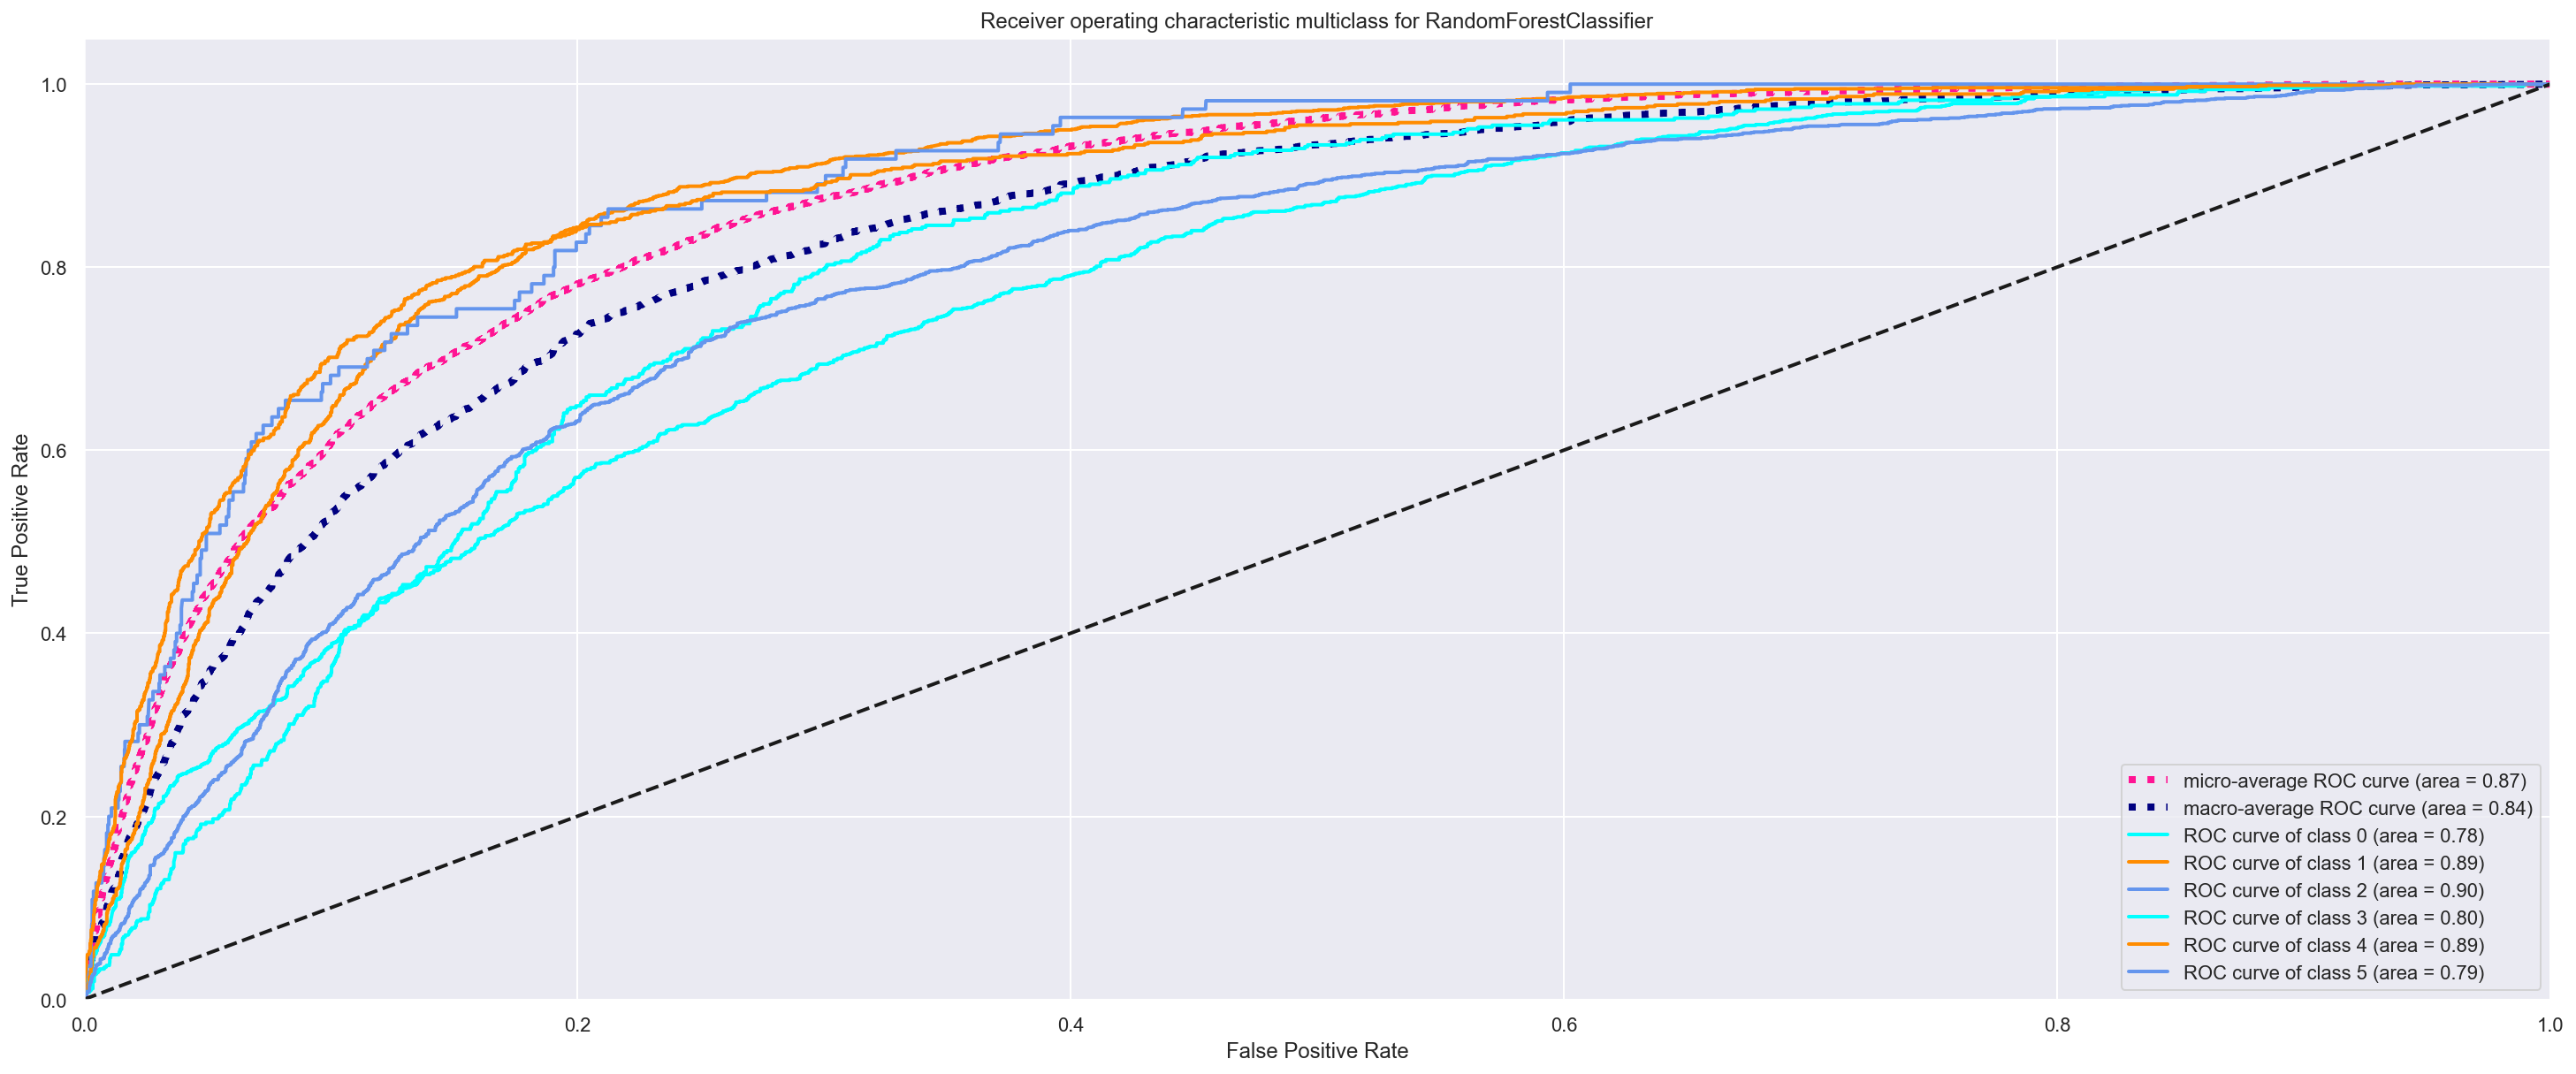

In [79]:
plot_aucroc(best_rf_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest)

## Ensemble the models

Here we are going to create a meta model thanks to the ensemble techniques.

In particular, we are going to ensemble the two best models above and the random forest one.

In [92]:
model_rf = best_rf
model_xgb = best_xgb
model_cat = best_cat

# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb), ('cat', model_cat)], voting='soft')

final_pipe = Pipeline(steps=[("preprocessing", preprocessing), ("model", final_model)])
final_pipe.fit(X_train, le.fit_transform(y_train))

[17:45:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "classes_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0:	learn: 1.5807221	total: 11.3ms	remaining: 1.01s
1:	learn: 1.4632165	total: 23ms	remaining: 1.01s
2:	learn: 1.3842364	total: 34.7ms	remaining: 1.01s
3:	learn: 1.3251147	total: 45.7ms	remaining: 983ms
4:	learn: 1.2769205	total: 56.6ms	remaining: 962ms
5:	learn: 1.2398534	total: 67.6ms	remaining: 946ms
6:	learn: 1.2087648	total: 78.4ms	remaining: 930ms
7:	learn: 1.1840448	total: 89.3ms	remaining: 915ms
8:	learn: 1.1601991	total: 101ms	remaining: 912ms
9:	learn: 1.1425522	total: 112ms	remaining: 892ms
10:	learn: 1.1255224	total: 122ms	remaini

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('get_continent',
                                                  FunctionTransformer(func=<function get_continent_function at 0x285369040>),
                                                  [1]),
                                                 ('ord_age',
                                                  OrdinalEncoder(categories=[['<18',
                                                                              '18-24',
                                                                              '25-44',
                                                                              '45-64',
                                                                              '65+']]),
                                                  [2]),
                                                 ('ohe_travel_with',
                                                  OneHotEncoder(sparse=False),
                                                  [3]),
                                                 ('get_family',
                                                  FunctionTransformer(func=<function get_num_...
                                                             interaction_constraints='',
                                                             learning_rate=0.05,
                                                             max_bin=256,
                                                             max_cat_to_onehot=4,
                                                             max_delta_step=0,
                                                             max_depth=5,
                                                             max_leaves=0,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints='()',
                                                             n_estimators=100,
                                                             n_jobs=0,
                                                             num_parallel_tree=1,
                                                             objective='multi:softprob',
                                                             predictor='auto',
                                                             random_state=0, ...)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x2c499ed30>)],
                                  voting='soft'))])

In [93]:
print(classification_report(final_pipe.predict(X_devtest), le.transform(y_devtest)))

print("Final model with balanced classes weighted f1-score: ", f1_score(final_pipe.predict(X_devtest), le.transform(y_devtest), average="weighted"))

              precision    recall  f1-score   support

           0       0.39      0.51      0.44       854
           1       0.78      0.66      0.71      1857
           2       0.22      0.32      0.26        74
           3       0.10      0.32      0.16       165
           4       0.65      0.55      0.60       879
           5       0.65      0.57      0.61      1921

    accuracy                           0.58      5750
   macro avg       0.46      0.49      0.46      5750
weighted avg       0.63      0.58      0.60      5750

Final model with balanced classes weighted f1-score:  0.5973158846236636


[17:46:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "classes_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0:	learn: 1.5807221	total: 11.9ms	remaining: 1.06s
1:	learn: 1.4632165	total: 24ms	remaining: 1.06s
2:	learn: 1.3842364	total: 40ms	remaining: 1.16s
3:	learn: 1.3251147	total: 55.8ms	remaining: 1.2s
4:	learn: 1.2769205	total: 70.3ms	remaining: 1.2s
5:	learn: 1.2398534	total: 83ms	remaining: 1.16s
6:	learn: 1.2087648	total: 97.1ms	remaining: 1.15s
7:	learn: 1.1840448	total: 111ms	remaining: 1.13s
8:	learn: 1.1601991	total: 125ms	remaining: 1.12s
9:	learn: 1.1425522	total: 137ms	remaining: 1.1s
10:	learn: 1.1255224	total: 149ms	remaining: 1.07

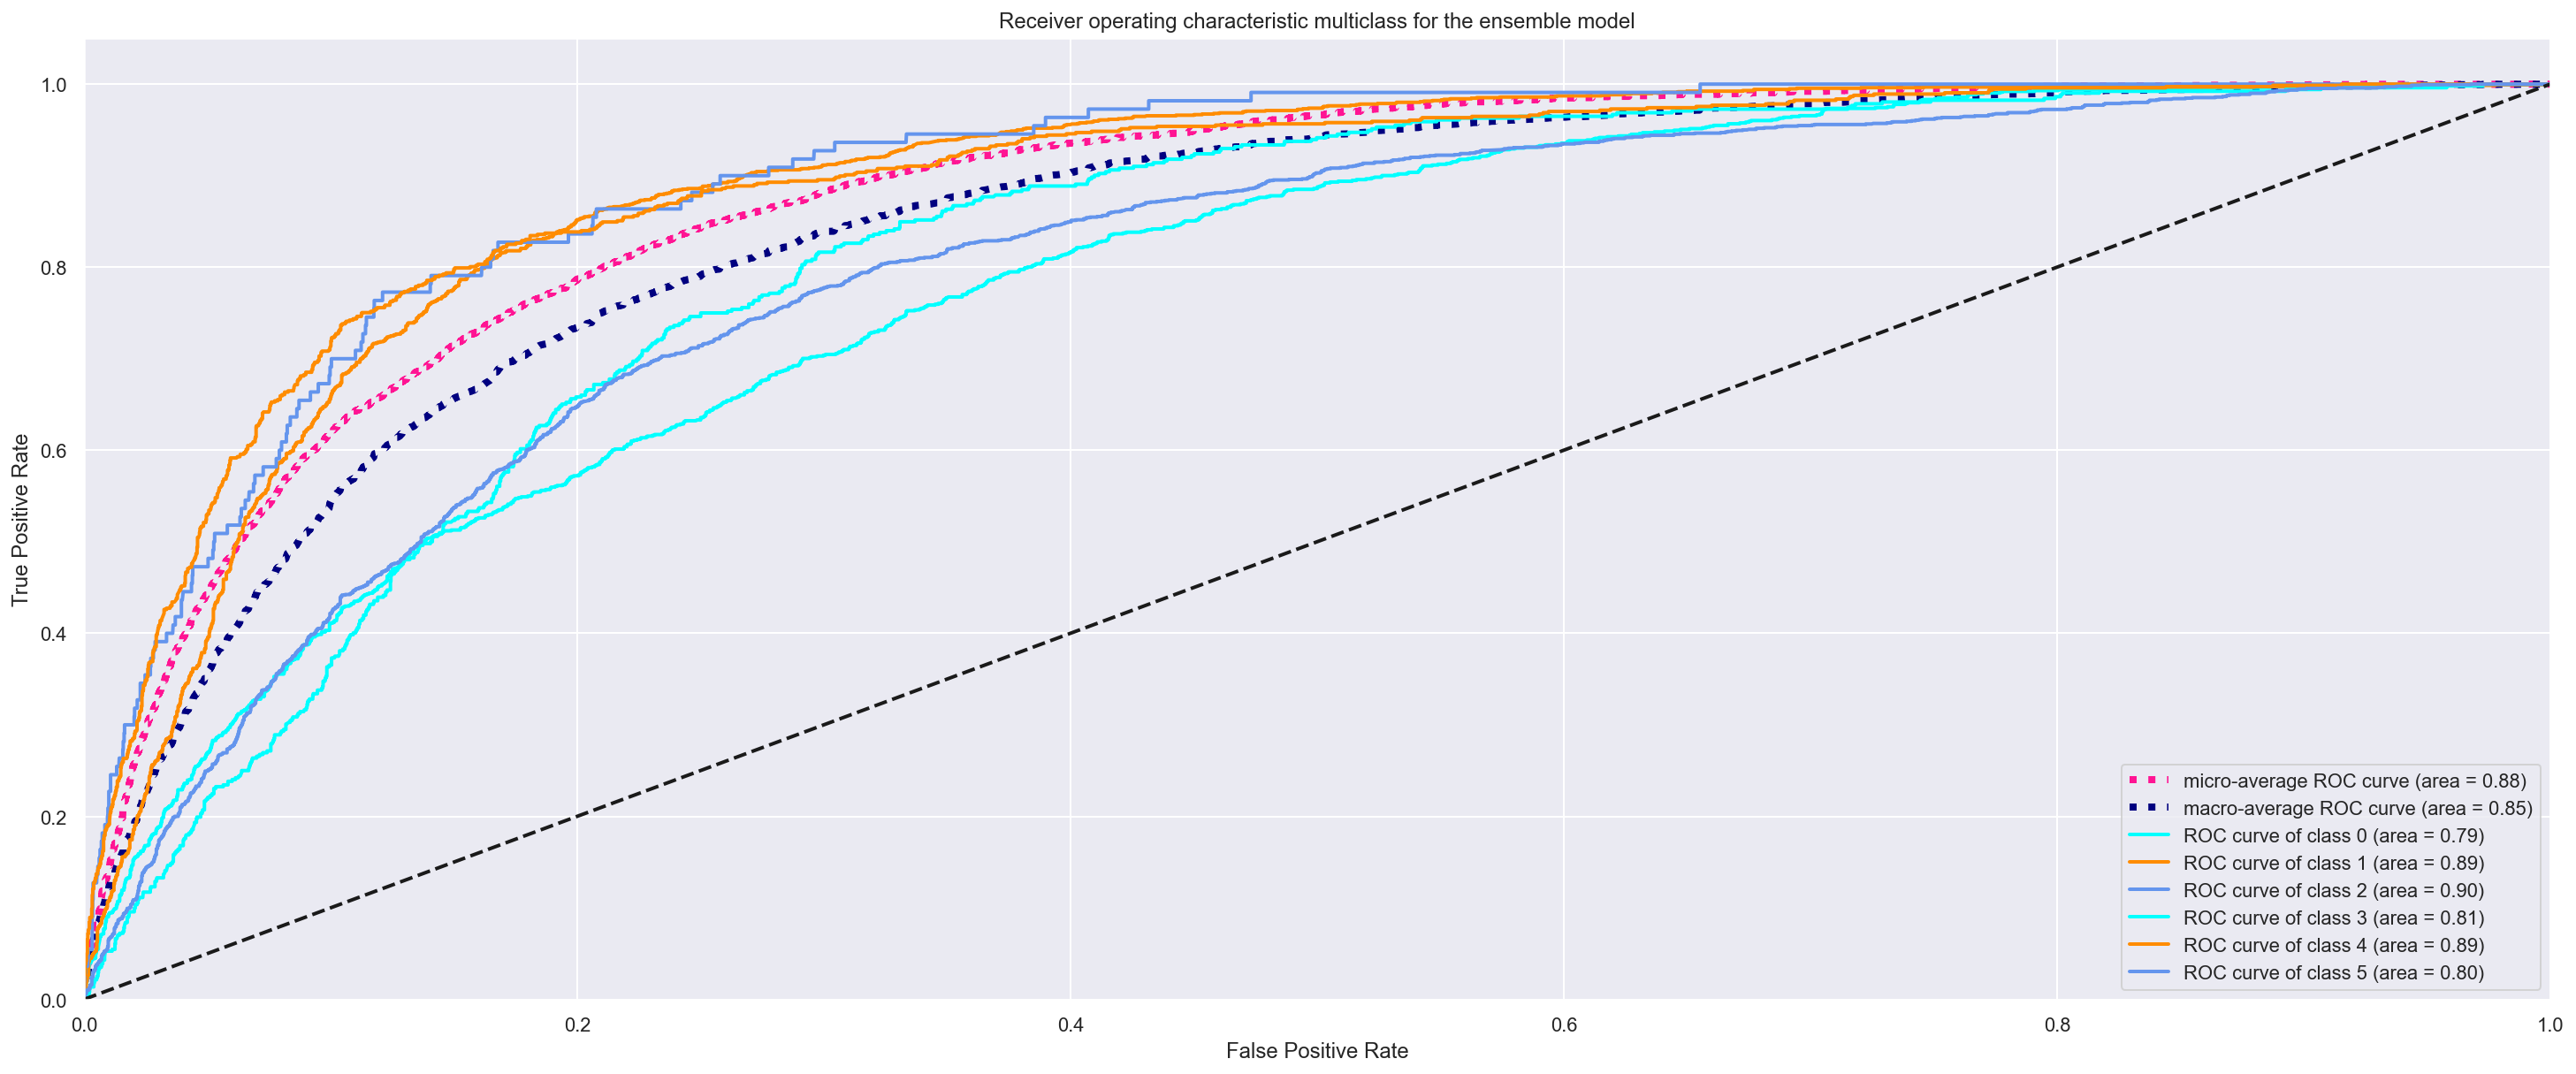

In [96]:
plot_aucroc(final_pipe, X_train=X_train, y_train=y_train, X_test=X_devtest, y_test=y_devtest, title="Receiver operating characteristic multiclass for the ensemble model")

## Final: Save the pipeline

We are ready to save the pipeline, this can be done by the library joblib.

In [ ]:
joblib.dump(final_pipe, "OSCAR_model.joblib");

Congratulations, be proud of yourself because this is done!

<p align="center">
    <img src="https://media.tenor.com/NgGtOYw27q8AAAAd/looney-tunes-thats-all-folks.gif">
</p>